In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy.stats import shapiro, anderson, kstest, normaltest, jarque_bera, normaltest, boxcox, yeojohnson
from statsmodels.stats.diagnostic import lilliefors
from rapidfuzz import process, fuzz
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler, Normalizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

/home/hollow/anaconda3/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
df = pd.read_csv("dataset/autos.csv")

In [3]:
df = df.sample(frac=0.2, random_state=42)

In [4]:
df.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
348986,348986,2016-03-25 19:57:53,Opel_Calibra,privat,Angebot,10000,test,coupe,1992,manuell,...,calibra,150000,10,benzin,opel,nein,2016-03-25 00:00:00,0,94269,2016-04-05 00:17:25
183474,183474,2016-04-04 15:56:41,Mercedes_Benz_C180_Kombi,privat,Angebot,850,test,kombi,1998,manuell,...,c_klasse,150000,11,benzin,mercedes_benz,NaN,2016-04-04 00:00:00,0,68526,2016-04-04 15:56:41
367615,367615,2016-03-24 20:58:52,Auto_an_Bastler,privat,Angebot,150,test,NaN,2000,manuell,...,almera,150000,0,NaN,nissan,NaN,2016-03-24 00:00:00,0,17213,2016-04-03 14:47:37
32810,32810,2016-03-24 12:57:58,Audi_A3_1.6_Ambiente,privat,Angebot,3398,test,limousine,2003,manuell,...,a3,150000,3,benzin,audi,nein,2016-03-24 00:00:00,0,36043,2016-04-07 04:45:42
342339,342339,2016-03-29 08:55:03,Verkaufe_Mercedes_Benz_C_180.,privat,Angebot,1400,control,limousine,1996,manuell,...,c_klasse,150000,6,benzin,mercedes_benz,NaN,2016-03-29 00:00:00,0,38162,2016-04-05 18:18:29


### Predicting values more than 200,000 and below 1,000 is not useful.
### In order to make our model effectively predict prices 1,000 - 200,000 we will exclude all rows with prices outside this range.

In [5]:
print(df.shape)
df = df.drop(df[(df['price'] < 1000) | (df['price'] > 200_000)].index, axis='index')
print(df.shape)

(18576, 21)
(14392, 21)


In [6]:
# Count of unique values in offerType
df.groupby('offerType').count()

,index,dateCrawled,name,seller,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
offerType,,,,,,,,,,,,,,,,,,,,
Angebot,14392,14392,14392,14392,14392,14392,13360,14392,13877,14392,13787,14392,14392,13526,14392,12317,14392,14392,14392,14392


In [7]:
# Count of unique values in seller
df.groupby('seller').count()

,index,dateCrawled,name,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
seller,,,,,,,,,,,,,,,,,,,,
privat,14392,14392,14392,14392,14392,14392,13360,14392,13877,14392,13787,14392,14392,13526,14392,12317,14392,14392,14392,14392


In [8]:
# Count of unique values in nrOfPictures
df.groupby('nrOfPictures').count()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
nrOfPictures,,,,,,,,,,,,,,,,,,,,
0,14392,14392,14392,14392,14392,14392,14392,13360,14392,13877,14392,13787,14392,14392,13526,14392,12317,14392,14392,14392


#### Irrelevant parameters
* offerType
* seller
* nrOfPictures

For each param one value dominates. Since each column has essentially one value, it is irrelevant as a param

In [9]:
# First remove the few rows affected
df = df.drop(df[(df['offerType'] == 'Gesuch') | (df['seller'] == 'gewerblich')].index, axis='index')

# Now remove the irrelevant columns
df = df.drop(['offerType', 'seller', 'nrOfPictures', 'index'], axis='columns')
df.dtypes

dateCrawled            object
name                   object
price                   int64
abtest                 object
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS                 int64
model                  object
kilometer               int64
monthOfRegistration     int64
fuelType               object
brand                  object
notRepairedDamage      object
dateCreated            object
postalCode              int64
lastSeen               object
dtype: object

In [10]:
df.shape

(14392, 17)

In [11]:
missing_values = df.isnull().sum()
print("Missing Values per Column:")
missing_values

Missing Values per Column:


dateCrawled               0
name                      0
price                     0
abtest                    0
vehicleType            1032
yearOfRegistration        0
gearbox                 515
powerPS                   0
model                   605
kilometer                 0
monthOfRegistration       0
fuelType                866
brand                     0
notRepairedDamage      2075
dateCreated               0
postalCode                0
lastSeen                  0
dtype: int64

In [12]:
df.head()

,dateCrawled,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
348986,2016-03-25 19:57:53,Opel_Calibra,10000,test,coupe,1992,manuell,0,calibra,150000,10,benzin,opel,nein,2016-03-25 00:00:00,94269,2016-04-05 00:17:25
32810,2016-03-24 12:57:58,Audi_A3_1.6_Ambiente,3398,test,limousine,2003,manuell,102,a3,150000,3,benzin,audi,nein,2016-03-24 00:00:00,36043,2016-04-07 04:45:42
342339,2016-03-29 08:55:03,Verkaufe_Mercedes_Benz_C_180.,1400,control,limousine,1996,manuell,0,c_klasse,150000,6,benzin,mercedes_benz,NaN,2016-03-29 00:00:00,38162,2016-04-05 18:18:29
206349,2016-03-12 18:53:47,Volkswagen_Polo_1.4_CrossPolo,6900,test,kleinwagen,2006,manuell,80,polo,70000,7,benzin,volkswagen,nein,2016-03-12 00:00:00,22941,2016-03-16 00:47:02
337351,2016-03-08 14:48:42,Volvo_940_GL,1600,test,kombi,1992,automatik,131,andere,150000,3,benzin,volvo,nein,2016-03-08 00:00:00,28844,2016-03-08 14:48:42


In [13]:
def generate_phrases(tokens, max_len=3):
    """
    Generates all n-grams (1 to max_len) from the token list.
    """
    phrases = []
    for n in range(1, max_len + 1):
        for i in range(len(tokens) - n + 1):
            phrase = " ".join(tokens[i:i+n])
            phrases.append(phrase)
    return phrases


def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase, remove non-alphanumeric characters, collapse whitespace
    return re.sub(r'\s+', ' ', re.sub(r'[^a-z0-9]', ' ', text.lower())).strip()


def fuzzy_match_model(name, known_models, threshold=50):
    scored = [(model, fuzz.token_set_ratio(name, model)) for model in known_models]
    best_match, best_score = max(scored, key=lambda x: x[1])
    return best_match if best_score >= threshold else None


def match_model(row):
    
    if pd.notnull(row['model']):
        return row['model']
        
    brand = clean_text(row.get('brand'))
    name = clean_text(row.get('name'))
    candidates = brand_model_map.get(brand)
        
    if candidates is None or len(candidates) == 0:
        return None
        
    # Split name into tokens and generate 1–3 word phrases
    tokens = name.split()
    phrases = generate_phrases(tokens)

    best_match = None
    best_score = 0

    for phrase in phrases:
        match = fuzzy_match_model(phrase, candidates)
        if match:
            score = fuzz.token_set_ratio(phrase, match)
            if score > best_score:
                best_score = score
                best_match = match

    #return best_match if best_score >= 70 else None
    return re.sub(" ", "_", best_match) if best_score >= 70 else None

In [14]:
brand_model_df = pd.read_csv("dataset/all-brand-models.csv")
brand_model_df

,brand,model
0,acura,cl
1,acura,csx
2,acura,el
3,acura,ilx
4,acura,integra
...,...,...
6467,yamaha,yzf600r
6468,yamaha,yzf-r1
6469,yamaha,yzf-r1 le
6470,yamaha,yzf-r6


In [15]:
# Build the brand -> list of models mapping
brand_model_map = defaultdict(list)

for _, row in brand_model_df.iterrows():
    brand = clean_text(row['brand'])
    model = clean_text(row['model'])
    brand_model_map[brand].append(model)

brand_model_map = dict(brand_model_map)
# convert into numpy array to use fuzzy search later
for brand in brand_model_map:
    brand_model_map[brand] = np.array(sorted(brand_model_map[brand]))
brand_model_map

{'acura': array(['cl', 'csx', 'el', 'ilx', 'integra', 'legend', 'mdx',
        'mdx sport hybrid', 'nsx', 'rdx', 'rl', 'rlx', 'rlx sport hybrid',
        'rsx', 'slx', 'tl', 'tlx', 'tsx', 'vigor', 'zdx'], dtype='<U16'),
 'alfa romeo': array(['147', '156', '159', '164', '4c', '4c spider', '8c', 'brera',
        'giulia', 'giulietta', 'gt', 'mito', 'spider', 'stelvio', 'tonale'],
       dtype='<U9'),
 'american ironhorse': array(['bandera', 'classic', 'classic chop', 'judge', 'legend', 'lsc',
        'outlaw', 'ranger', 'ranger t', 'slammer', 'stalker', 'tejas',
        'texas chopper', 'thunder'], dtype='<U13'),
 'american lafrance': array(['alf eagle', 'condor'], dtype='<U9'),
 'am general': array(['hummer'], dtype='<U6'),
 'aprilia': array(['atlantic 500', 'caponord 1200', 'dorsoduro 1200', 'dorsoduro 750',
        'dorsoduro 750 abs', 'etv 1000 caponord', 'mana 850',
        'mana 850 gt abs', 'mojito 150', 'mojito custom 50',
        'mojito retro 50', 'pegaso 650', 'pegaso 650 fact

In [16]:
df['model'].isnull().sum()

605

In [17]:
df['original_model'] = df['model'].copy()

df['model'] = df.apply(match_model, axis=1)

filled_mask = df['original_model'].isnull() & df['model'].notnull()
unfilled_mask = df['original_model'].isnull() & df['model'].isnull()
filled_df = df[filled_mask][['name', 'model', 'brand']]
unfilled_df = df[unfilled_mask][['name', 'model', 'brand', 'price']]

In [18]:
df['model'].isnull().sum()

208

In [19]:
df[df['brand'] == 'sonstige_autos'].count()

dateCrawled            148
name                   148
price                  148
abtest                 148
vehicleType            131
yearOfRegistration     148
gearbox                128
powerPS                148
model                    0
kilometer              148
monthOfRegistration    148
fuelType               129
brand                  148
notRepairedDamage      127
dateCreated            148
postalCode             148
lastSeen               148
original_model           0
dtype: int64

In [20]:
unfilled_df

,name,model,brand,price
363932,Sparsamer_Flitzer_tiefer__breiter_VW_UP_1_0_Hi...,None,volkswagen,7500
136276,HYUNDAI__100%_good,None,hyundai,2300
262999,Auto_W123Coupe,None,mercedes_benz,4500
256077,Citroeen_Jumper_Kastenwagen,None,citroen,2100
30515,Triumph_TR6__Oldtimer__Cabrio_,None,sonstige_autos,25500
...,...,...,...,...
300594,mini_one_blau,None,mini,5800
183612,US_CAR_Buick_Park_Avenue,None,sonstige_autos,6600
167964,Ligier_Mopedauto,None,sonstige_autos,3950
245636,Ein_schoener_Porsche,None,porsche,7900


In [21]:
unfilled_df[unfilled_df['brand'] != 'sonstige_autos'][['name', 'model', 'brand']]

,name,model,brand
363932,Sparsamer_Flitzer_tiefer__breiter_VW_UP_1_0_Hi...,None,volkswagen
136276,HYUNDAI__100%_good,None,hyundai
262999,Auto_W123Coupe,None,mercedes_benz
256077,Citroeen_Jumper_Kastenwagen,None,citroen
335147,Renault_Master_2.5_dti,None,renault
30116,Suche_ganz_Dringend_Auto_auf_Ratenzahlung,None,opel
285132,ich_verkaufe,None,hyundai
35650,VW_Vento._Beschreibung_lesen,None,volkswagen
168153,Fiat_126p,None,fiat
152338,Hyundai_Terracan_2.9_CRDI_+_TÜV_10.2017_*EURO*4*,None,hyundai


<Axes: xlabel='model', ylabel='price'>

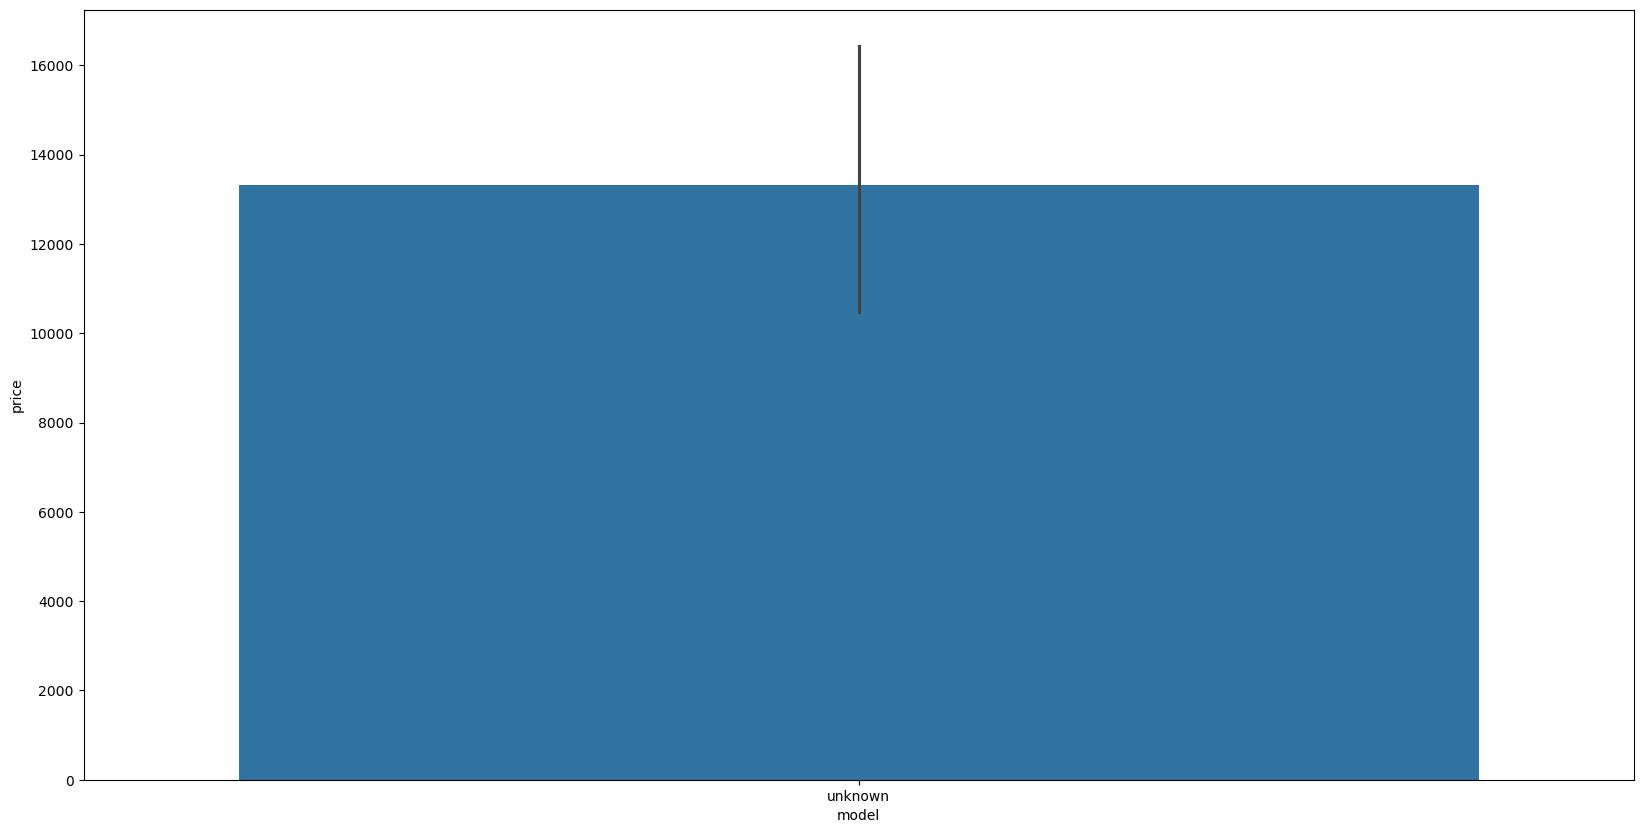

In [22]:
unfilled_df['model'] = "unknown"
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(y='price', x='model', data=unfilled_df, ax=ax)

In [23]:
filled_df

,name,model,brand
171168,Astra_mach_mir_Angebote_?,astra,opel
89224,Ford_Mondeo,mondeo,ford
222077,Nissan_350Z___Neue_Kupplung_und_Bremsen__,350z,nissan
87176,Peugeot_207_Tendance_90_1.4_16V_1Hand_TÜV_01/18,207,peugeot
366272,Verkaufe_meinen_golf_5_2.0l_fsi,e_golf,volkswagen
...,...,...,...
248118,Peugeot_206,206,peugeot
30634,B_klasse_mit_frontschaden,b_class,mercedes_benz
23528,Zwei_BMW_735i,135i,bmw
245328,Thunderbird_351cui_V8_//TÜV_neu_+H_Zulassung//...,thunderbird,ford


In [24]:
df.drop(columns=['original_model', 'name'], inplace=True)

In [25]:
df = df.dropna(subset=['model'])
df.shape

(14184, 16)

## Target Variable Analysis (`price`)

The dataset contains the price of the car (`price`) as the primary target variable. We can perform the following tasks as part of the EDA:

* Distribution of `price`:
    * Plot a histogram or density plot to observe the price distribution.
    * Check for normality, skewness and outliers.
* Bin `price` into categories:
    * Create categories like "Low," "Average," and "High" price to analyze patterns.

Text(0, 0.5, 'Frequency')

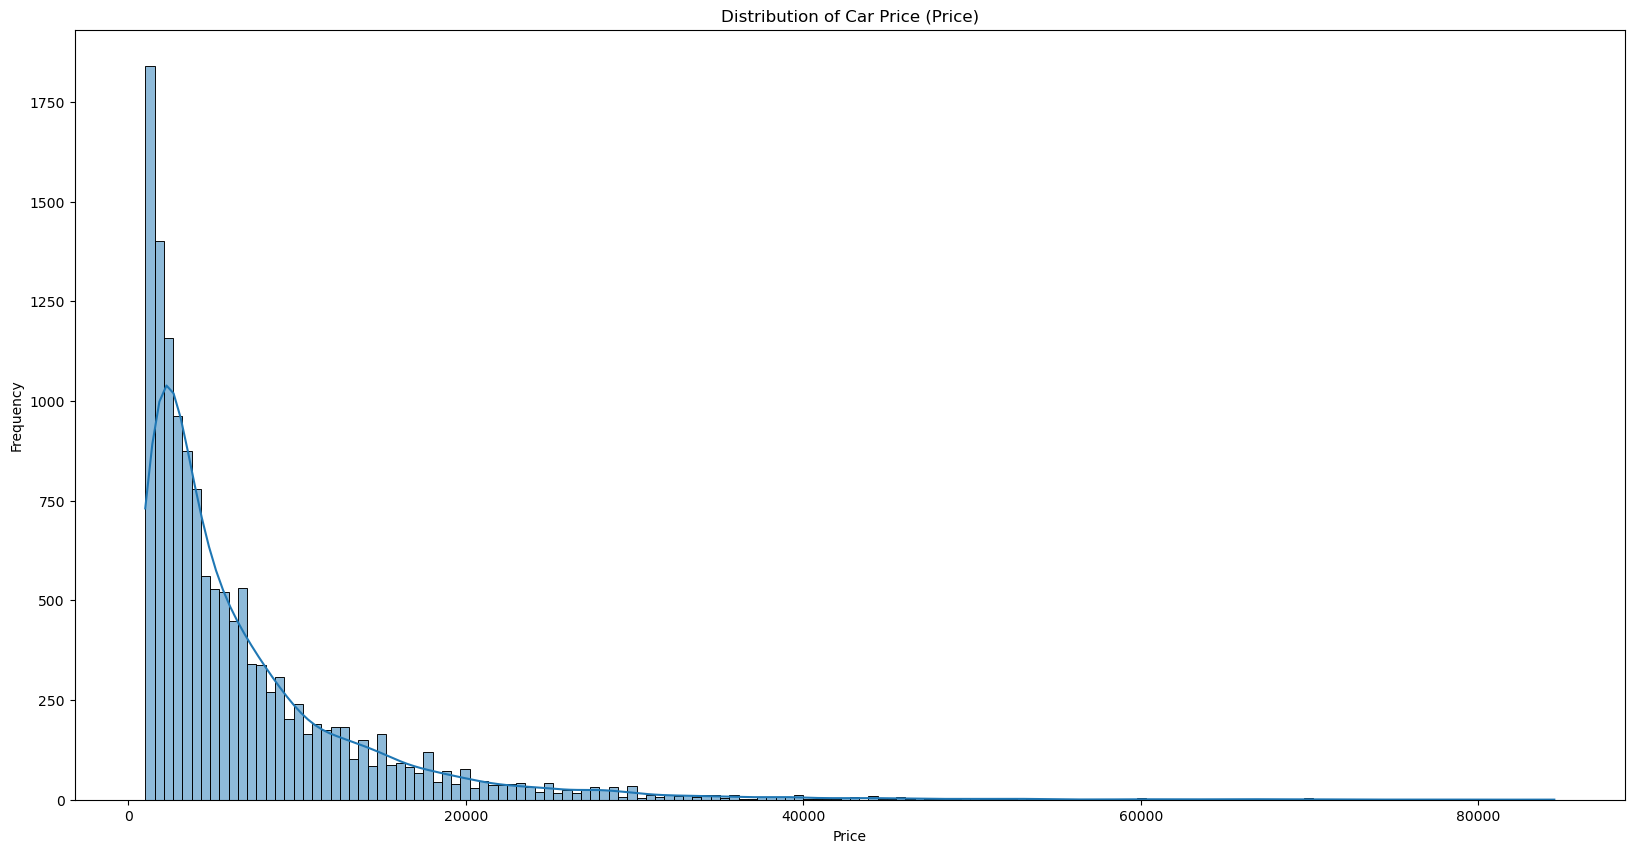

In [26]:
# distribution
# `price` has extreme values that make rendering the histogram impossible
# thus, we exclude them just for the chart
q_low, q_high = df['price'].quantile([0.001, 0.999])
df_trimmed = df[(df['price'] >= q_low) & (df['price'] <= q_high)]

fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(df_trimmed['price'], kde=True)
ax.set_title("Distribution of Car Price (Price)")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")

The target variable involves a large amount of outliers. Extreme outliers. This visual observation is confirmed by the following boxplot:

<Axes: ylabel='price'>

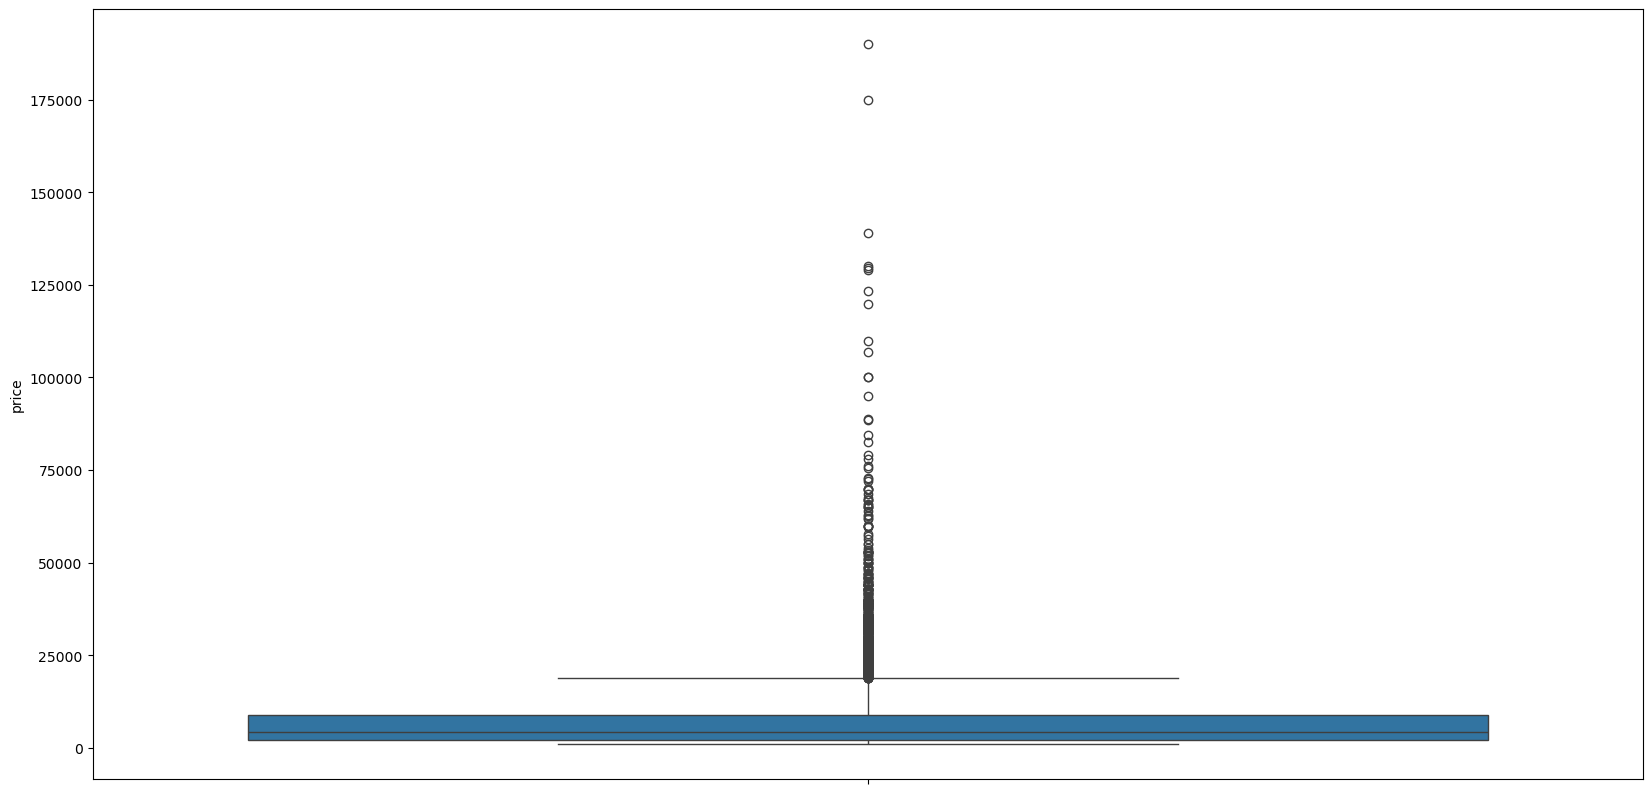

In [27]:
# boxplot
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, y='price')

<Axes: ylabel='price'>

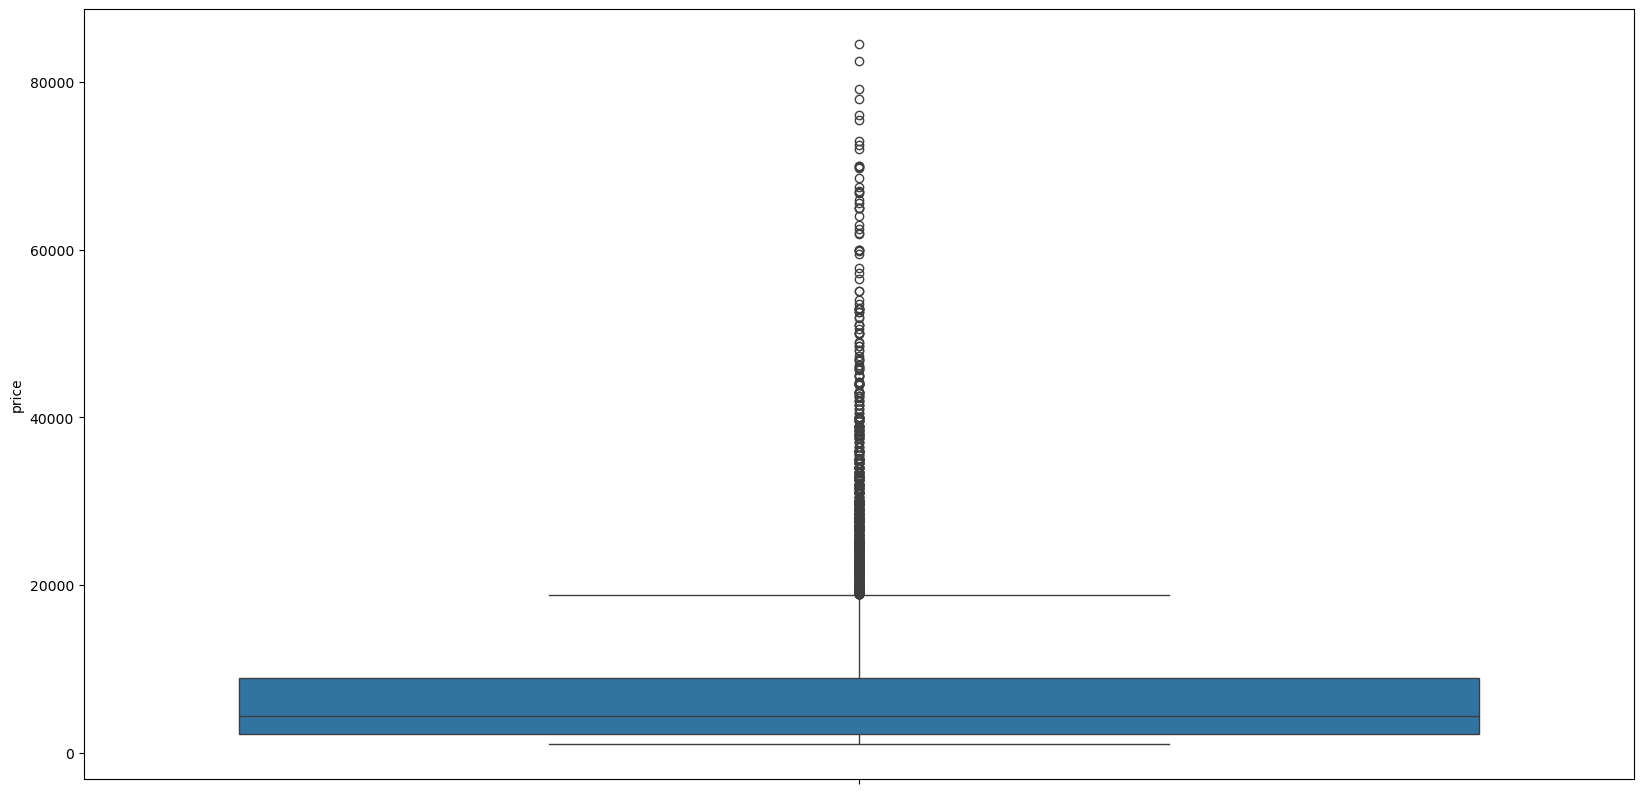

In [28]:
# boxplot
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df_trimmed, y='price')

<Axes: ylabel='price'>

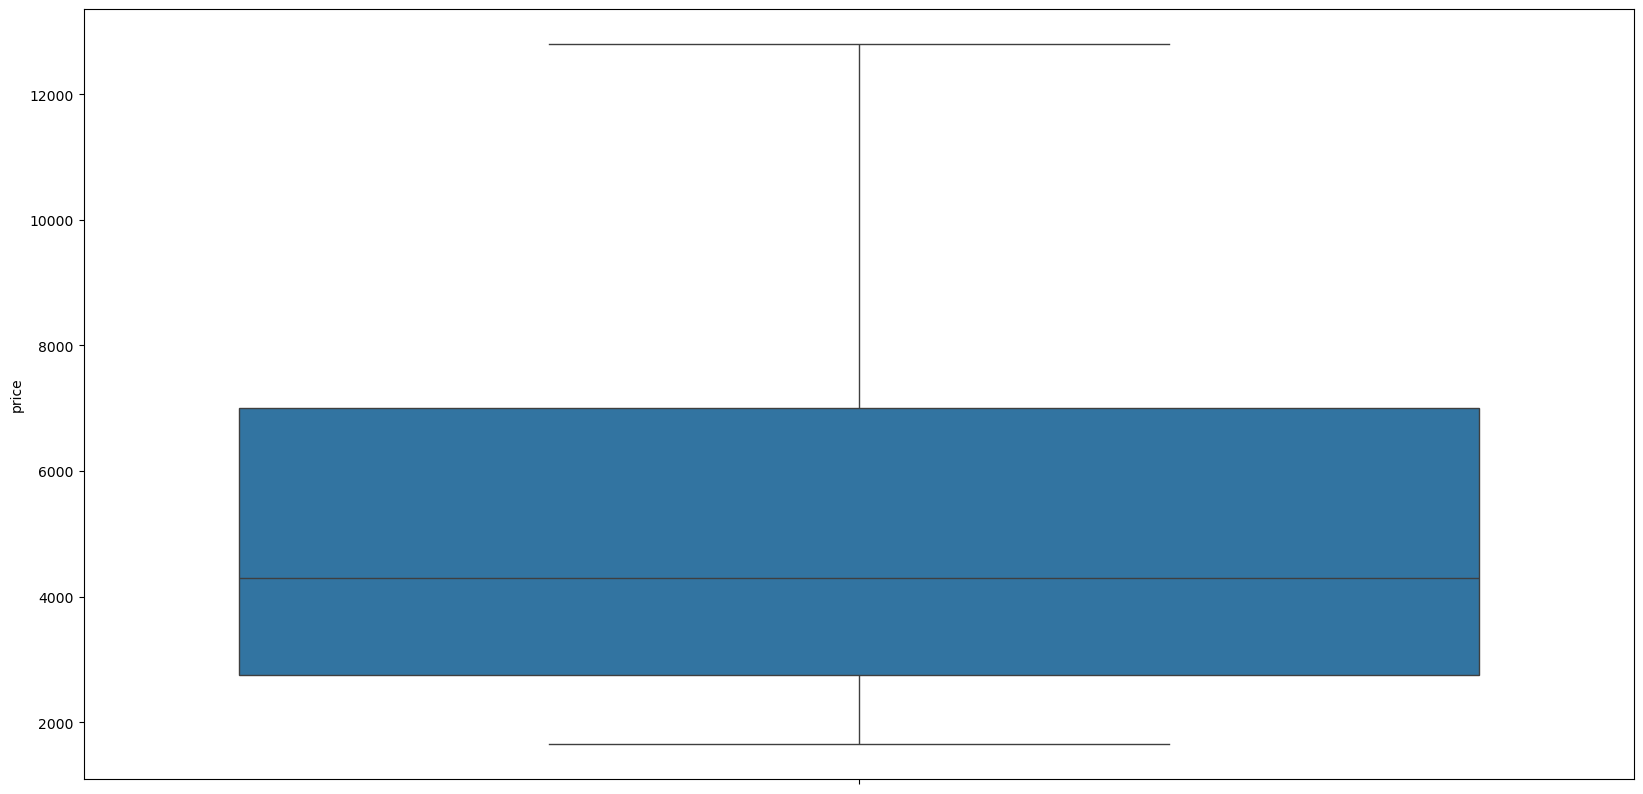

In [29]:
q_low, q_high = df['price'].quantile([0.15, 0.85])
df_trimmed = df[(df['price'] >= q_low) & (df['price'] <= q_high)]

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df_trimmed, y='price')

The target variable can be said that it does not follow the normal distribution based on the output of the normality tests shown below. All of them are

In [30]:
def run_normality_tests(data):
    """
    Perform various normality tests (Shapiro-Wilk, Anderson-Darling, Kolmogorov-Smirnov, D'Agostino and Pearson, Jarque-Bera, and Lilliefors) on a given dataset.
    Choosing the Right Test:
        * For small sample sizes (< 50), the Shapiro-Wilk Test is recommended.
        * For larger samples, use the D’Agostino and Pearson’s Test or Jarque-Bera Test.
        * If you need critical values, use the Anderson-Darling Test.
        * Use the Kolmogorov-Smirnov Test or Lilliefors Test for additional validation, especially when comparing with a reference distribution.
    
    All tests compute a p-value. The p-value (probability value) is a statistical measure that helps you determine whether the observed data is consistent with a 
    null hypothesis. In the context of normality tests, the null hypothesis is usually: "The data follows a normal distribution."
    
    How to Interpret the p-value:
        * High p-value (>= 0.05): There is not enough evidence to reject the null hypothesis. This suggests that the data might follow a normal distribution.
        * Low p-value (< 0.05): The null hypothesis is rejected. This indicates that the data does not follow a normal distribution.
        
    In Practice
        * If a test returns a p-value of 0.03, it means there is a 3% probability that the data could have arisen under the assumption of a normal distribution. In this case, you would reject the null hypothesis (assuming a 5% significance threshold).
        * If a test returns a p-value of 0.2, it suggests there is no strong evidence against the data being normal.

    Caveats
        * A high p-value does not prove normality, it simply suggests that the data is not inconsistent with a normal distribution.
        * A low p-value indicates a deviation from normality but does not specify the nature of that deviation (e.g., skewness, kurtosis).

    Parameters:
        data (array-like): The dataset to test for normality.

    Returns:
        dict: A dictionary containing test results with the test name, statistic, p-value, and whether the data is considered normal at a 5% significance level.
    """
    results = {}

    # Shapiro-Wilk Test
    # this test is commented out since it provides unreliable results for N > 5000
    """
    try:
        stat, p = shapiro(data)
        results['Shapiro-Wilk Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Shapiro-Wilk Test'] = {'Error': str(e)}
    """

    # Anderson-Darling Test
    try:
        result = anderson(data, dist='norm')
        results['Anderson-Darling Test'] = {
            'Statistic': result.statistic,
            'Critical Values': result.critical_values,
            'Significance Levels': result.significance_level,
            'Normal': result.statistic < result.critical_values[2]  # At 5% level
        }
    except Exception as e:
        results['Anderson-Darling Test'] = {'Error': str(e)}

    # Kolmogorov-Smirnov Test
    try:
        standardized_data = (data - np.mean(data)) / np.std(data)
        stat, p = kstest(standardized_data, 'norm')
        results['Kolmogorov-Smirnov Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Kolmogorov-Smirnov Test'] = {'Error': str(e)}

    # D’Agostino and Pearson’s Test
    try:
        stat, p = normaltest(data)
        results['D’Agostino and Pearson’s Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['D’Agostino and Pearson’s Test'] = {'Error': str(e)}

    # Jarque-Bera Test
    try:
        stat, p = jarque_bera(data)
        results['Jarque-Bera Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Jarque-Bera Test'] = {'Error': str(e)}

    # Lilliefors Test
    try:
        stat, p = lilliefors(data)
        results['Lilliefors Test'] = {'Statistic': stat, 'p-value': p, 'Normal': p > 0.05}
    except Exception as e:
        results['Lilliefors Test'] = {'Error': str(e)}

    return results

In [31]:
results = run_normality_tests(df['price'])
for test, result in results.items():
    print(f"{test}: {result}")

Anderson-Darling Test: {'Statistic': 1217.5480552997287, 'Critical Values': array([0.576, 0.656, 0.787, 0.918, 1.092]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal': False}
Kolmogorov-Smirnov Test: {'Statistic': 0.2370578890236386, 'p-value': 0.0, 'Normal': False}
D’Agostino and Pearson’s Test: {'Statistic': 15184.90240249105, 'p-value': 0.0, 'Normal': False}
Jarque-Bera Test: {'Statistic': 2005291.6017719915, 'p-value': 0.0, 'Normal': False}
Lilliefors Test: {'Statistic': 0.23706568058546912, 'p-value': 0.0009999999999998899, 'Normal': False}


From the aforementioned resuts, **price deviates from normality**.

From the histogram and the kernel density estimate (KDE) curve shown above, we can say that the distribution appears to be very asymmetric around its left peak, which is approximately 0-2000. There is an extreme tail elongation on the right side. Since the distribution is approximately asymmetric, it suggests that the skewness value would be large. However, the exact skewness value would need to be calculated. Below, we are using the .skew() function to reveal if the target variable is skewed:

* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
* If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately left-skewed or right-skewed respectively
* If the skewness is less than -1 or greater than 1, the data are highly left-skewed or right-skewed respectively

In [32]:
print('skewness:', df['price'].skew())

skewness: 5.2184664025557135


As show above, the **target variable is extremely right-skewed**, therefore unskewing techniques such as Log, Sqrt, Box-Cox and Yeo-Johnson can be applied. Since `price` consists only of positive values, we can use every technique mentioned.

In [33]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,postalCode
count,14184.000000,14184.000000,14184.000000,14184.000000,14184.000000,14184.000000
mean,7132.102298,2004.465172,128.766004,122971.658206,6.023618,51563.730964
std,8567.101583,13.846187,242.685501,40472.944897,3.563597,25749.225048
min,1000.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,2200.000000,2001.000000,80.000000,100000.000000,3.000000,31020.000000
50%,4350.000000,2005.000000,116.000000,150000.000000,6.000000,50858.500000
75%,8900.000000,2009.000000,160.000000,150000.000000,9.000000,72491.250000
max,190000.000000,3000.000000,20000.000000,150000.000000,12.000000,99986.000000


Text(0, 0.5, 'Frequency')

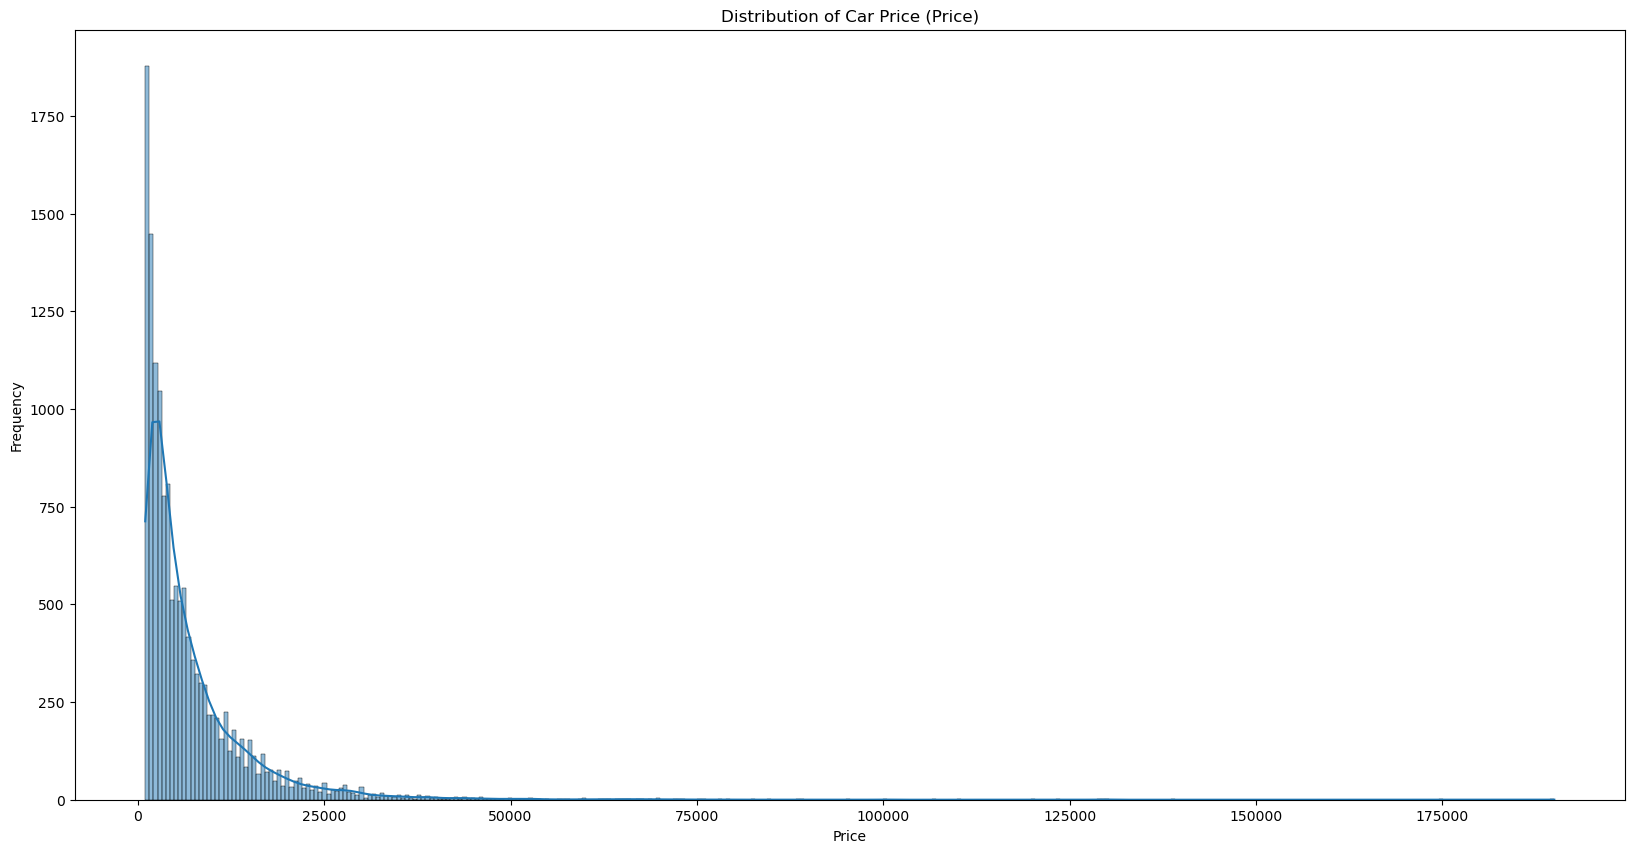

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(df['price'], kde=True)
ax.set_title("Distribution of Car Price (Price)")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")

<Axes: ylabel='price'>

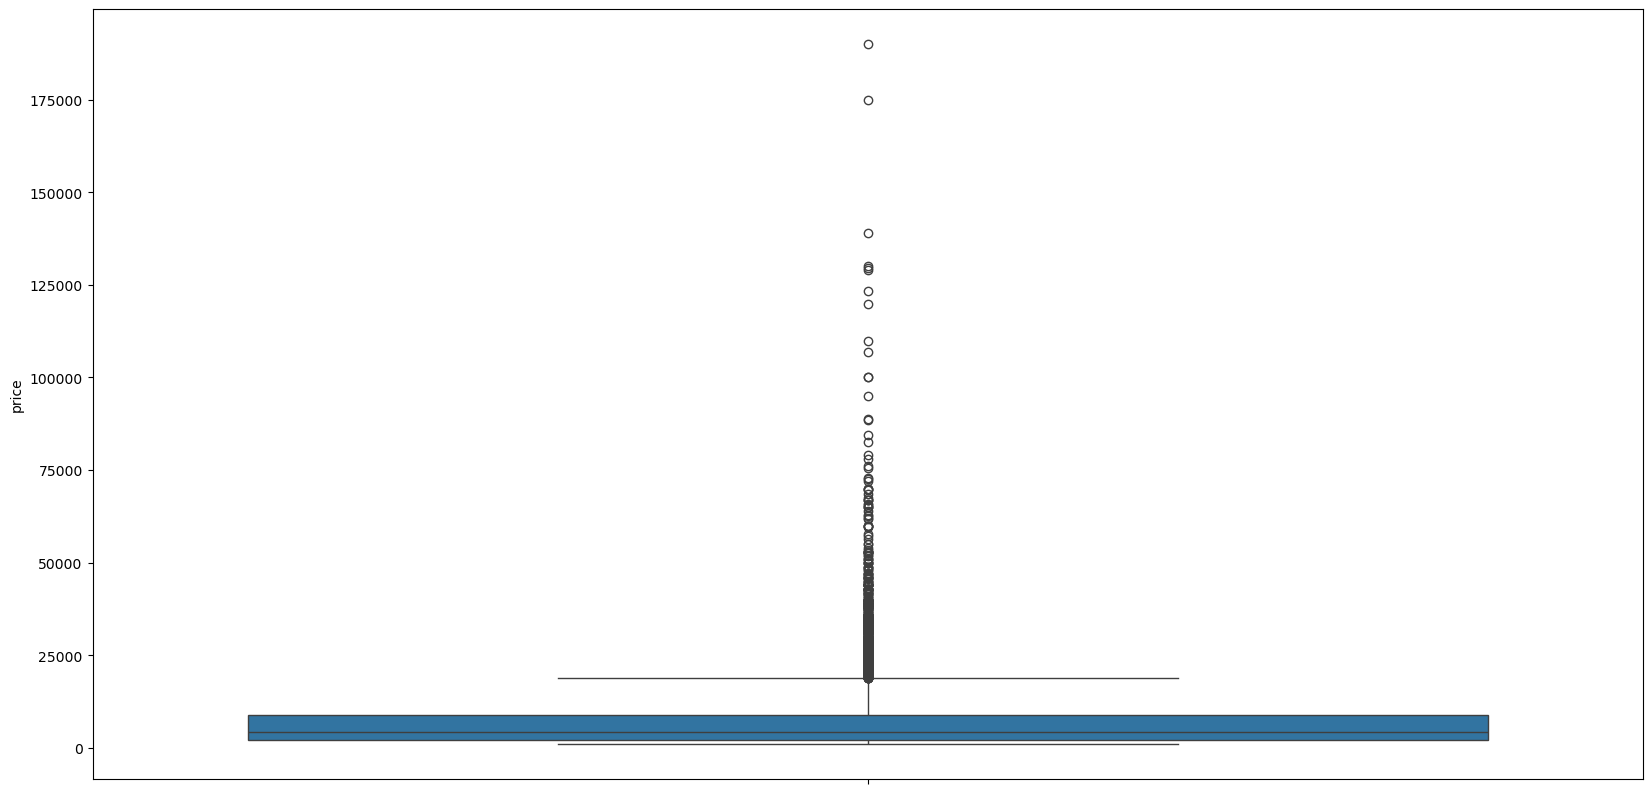

In [35]:
# boxplot
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df, y='price')

<Axes: ylabel='price'>

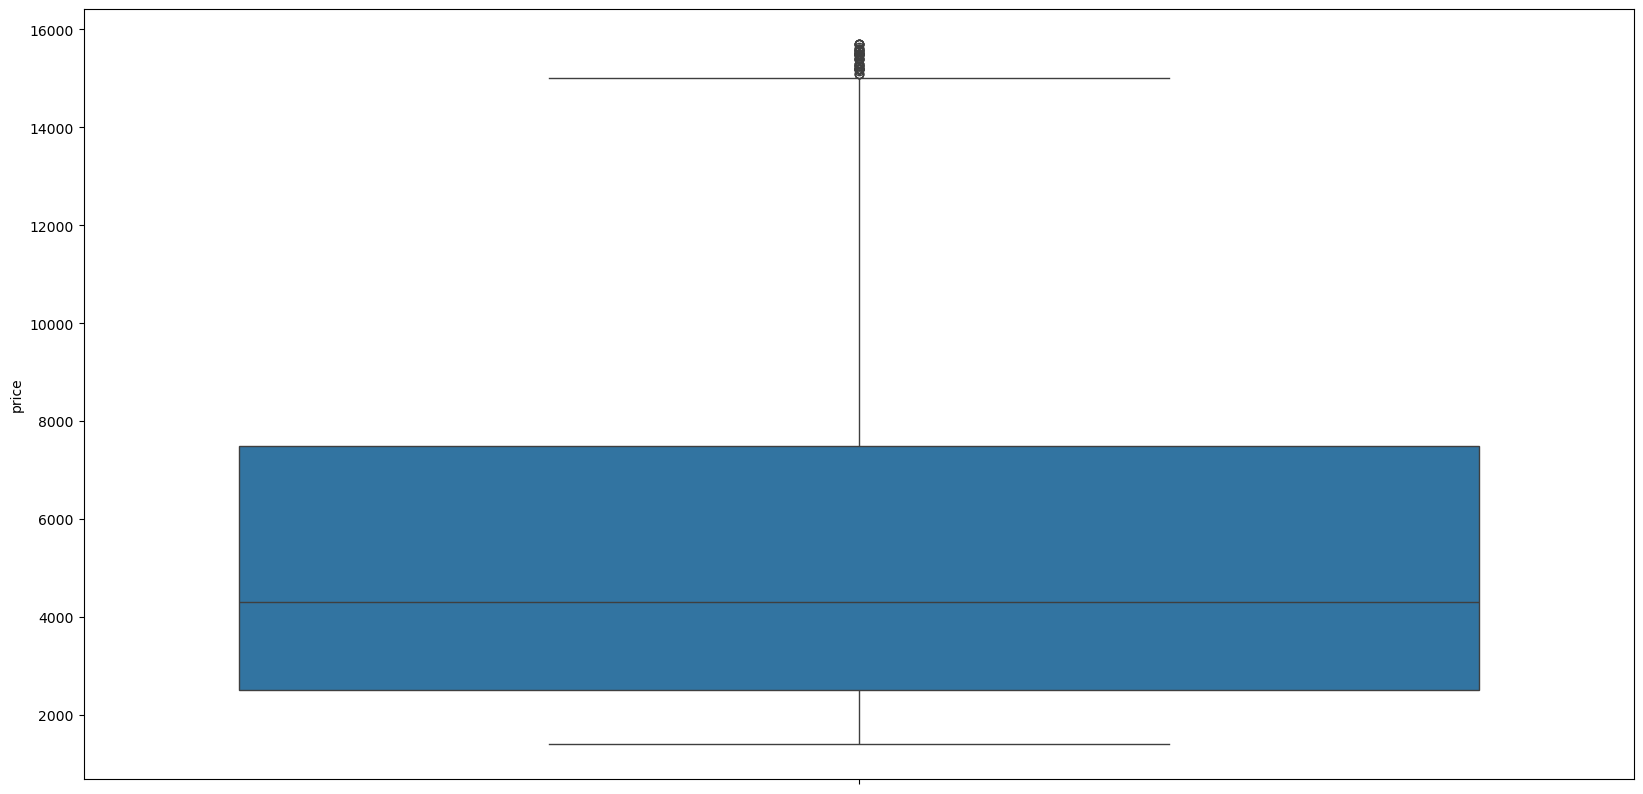

In [36]:
q_low, q_high = df['price'].quantile([0.1, 0.9])
df_trimmed = df[(df['price'] >= q_low) & (df['price'] <= q_high)]

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df_trimmed, y='price')

Dominant bin is low, meaning our model will perform better on cars with lower prices, also decent on average prices. Since we have very few high instances, our model will sruggle for such prices

## Categorical Features Analysis

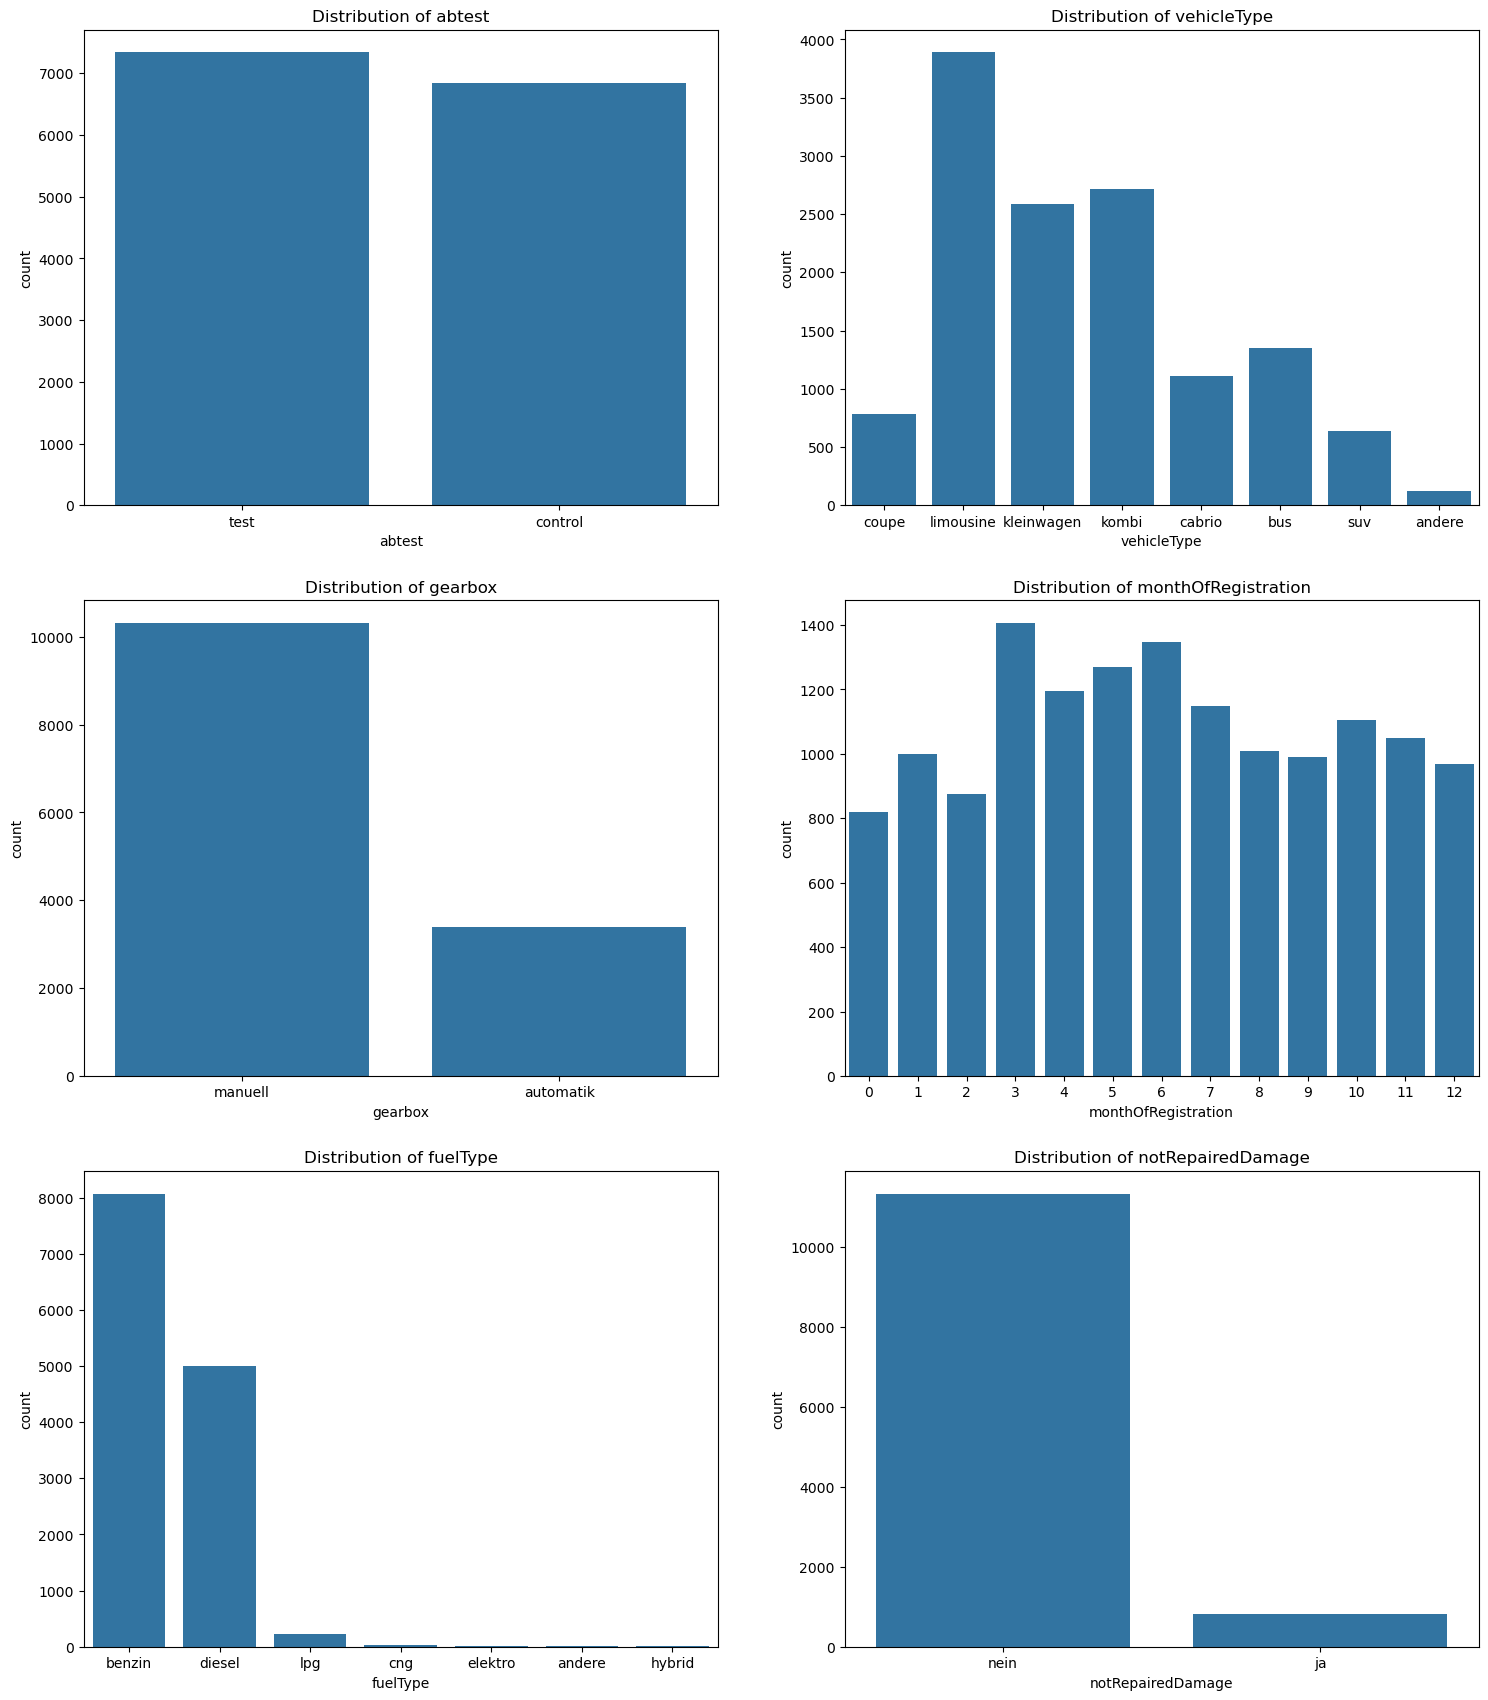

In [37]:
categorical_features = ['abtest', 'vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage']
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in categorical_features:
    sns.countplot(x=feature, data=df, ax=axs[i,j])
    axs[i,j].set_title(f"Distribution of {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

The bar plots shown above depict the distributions of several categorical variables in the dataset. Here are observations and insights for each feature:

1. ABtest (abtest)
   * both values (test and control) have similar distributions, while test appears more often
   * this variable can be useful for understanding the role of ABtest on price
2. Vehicle type (vehicleType)
   * three of the vehicle types dominate the distribution (kleinwagen, limousine, kombi)
   * the rest appear often enough to matter
   * andere appears too few times, perhaps oversampling could be used
3. gearbox (gearbox)
   * the majority of gearbox values are manual (manuell), though a signifigant portion is automatic (automatik)
   * the value of gearbox could help play a major role in determining the value of price
4. month of registration (monthOfRegistration)
   * each month has more or less similar amount of car registrations
   * months have 13th value, maybe 0 value is for null/NaN (dataset documentation does not specify)
5. fuel type (fuelType)
   * benzin appears, by far, the most often
   * desel appears often enough to impact learning
   * the rest of the values (lpg, andere, hybrid, cng, elektro) are extremely rare, perhaps we should join all these values into an `other` category
6. not repaired damage (notRepairedDamage)
   * nein dominates as a value
   * ja does appear, though maybe not enough
   * this could impact training

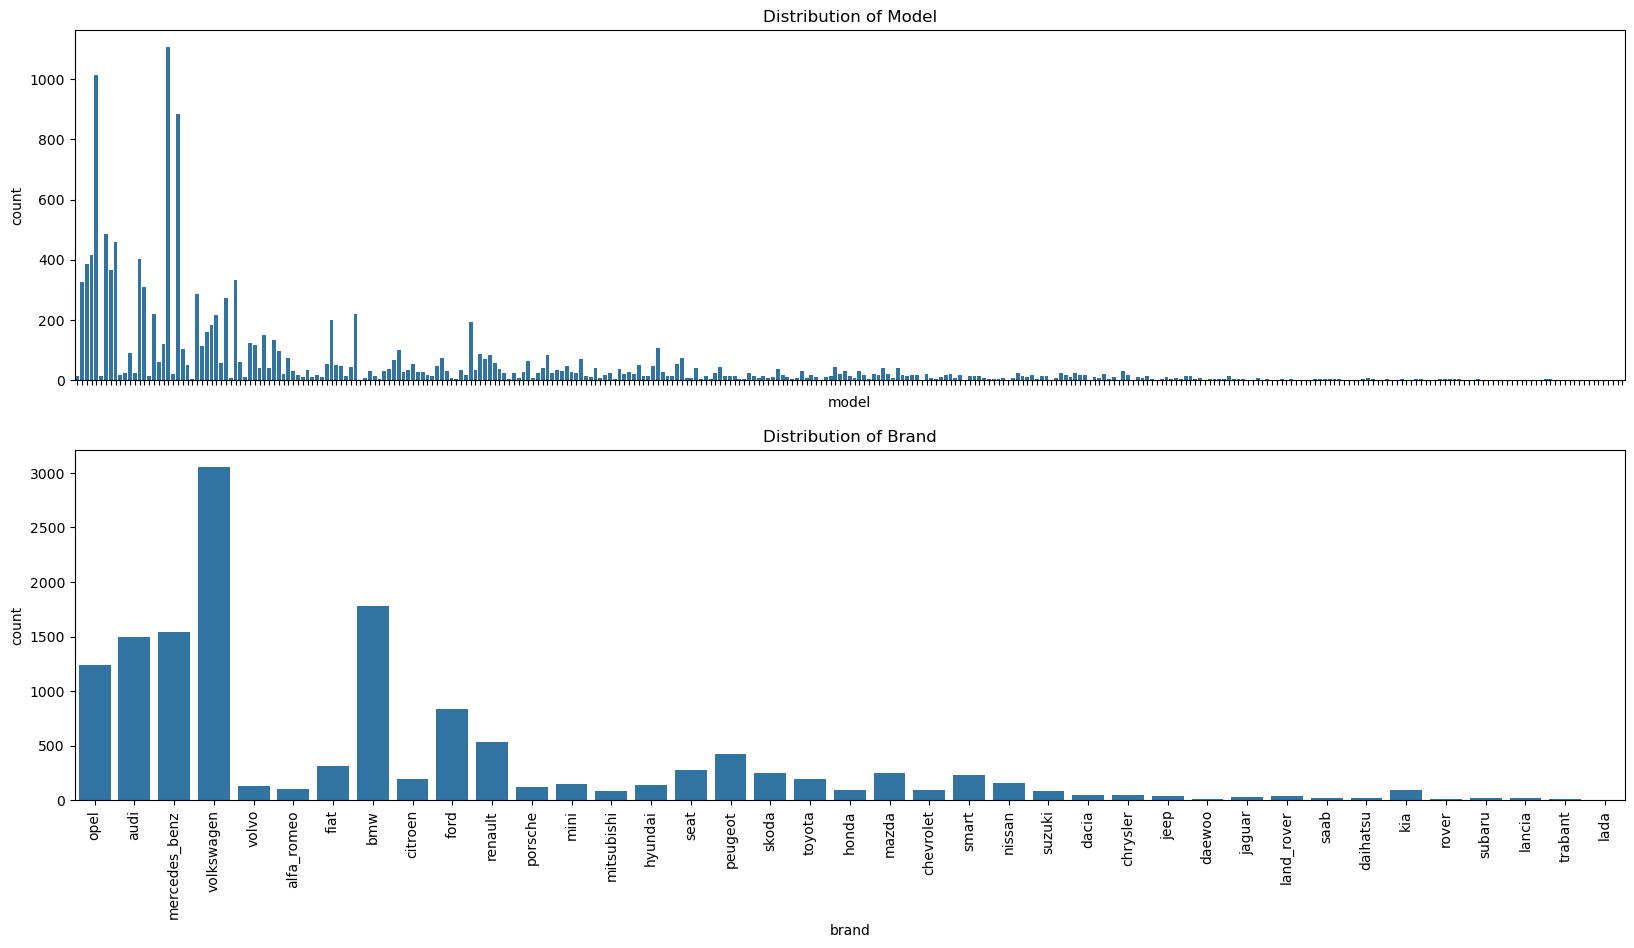

In [38]:
# model brand
nrows, ncols = 2, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

# Plot model distribution
sns.countplot(x='model', data=df, ax=axs[0])
axs[0].set_title("Distribution of Model")
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_xticklabels([])

sns.countplot(x='brand', data=df, ax=axs[1])
axs[1].set_title("Distribution of Brand")
axs[1].tick_params(axis='x', rotation=90)

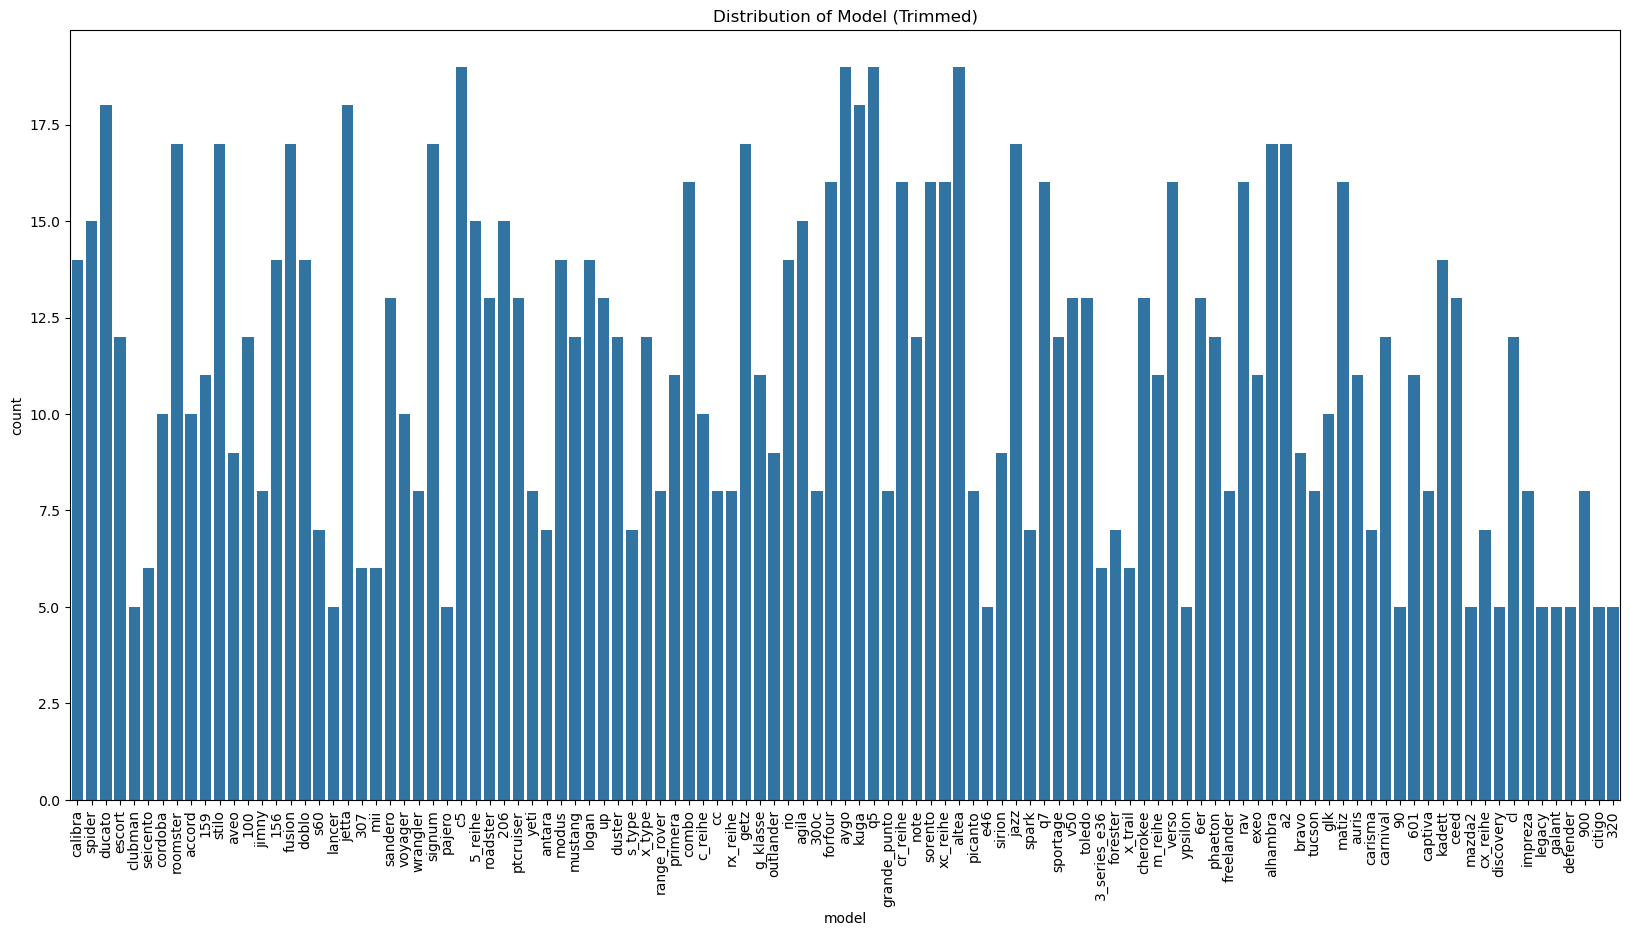

In [39]:

# Count how many times each model appears
model_counts = df['model'].value_counts()

# Determine quantile thresholds
q_low, q_high = model_counts.quantile([0.35, 0.65])

# Keep models within those frequency bounds
valid_models = model_counts[(model_counts >= q_low) & (model_counts <= q_high)].index

# Filter the DataFrame
df_trimmed = df[df['model'].isin(valid_models)]

# Plotting
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

# Model plot
sns.countplot(x='model', data=df_trimmed)
axs.set_title("Distribution of Model (Trimmed)")
axs.tick_params(axis='x', rotation=90)


#### General observations:
* Features like vehicleType, gearbox, fuelType and notRepairedDamage have unbalanced distributions, we should consider using stratified sampling during data splitting for more fair comparisons
* Use grouped bar plots to better visualize the relationship between categorical features (since we cannot apply heatmap method)
* Search for correlation between features and target by comparing distributions with the 'cetegorical' version of out target (via binning method)

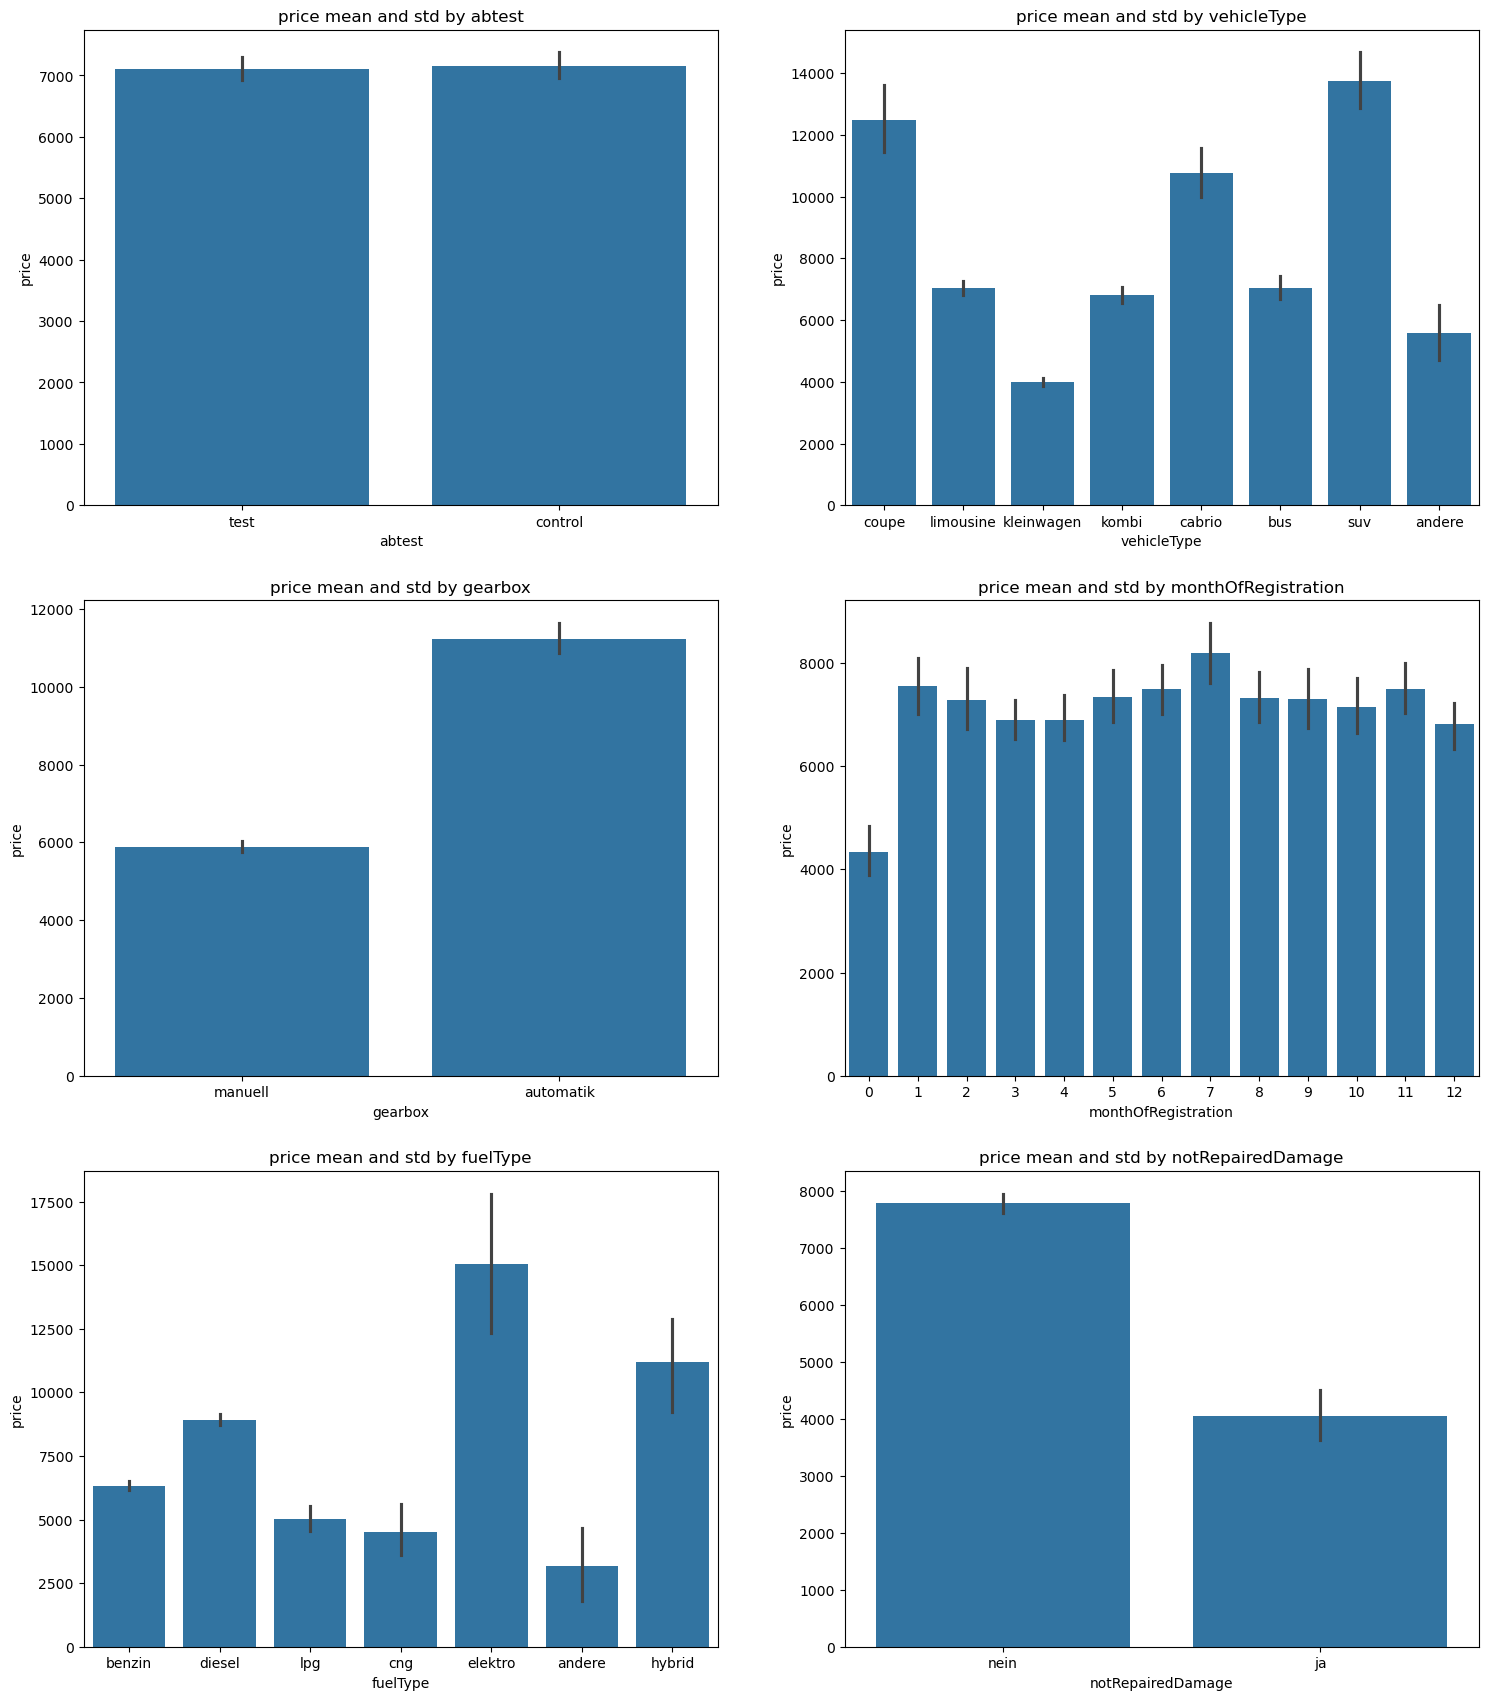

In [40]:
# Barplots: Visualize statistical measures (mean, std, median) of price for each category of a categorical variable.
categorical_features = ['abtest', 'vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage']
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in categorical_features:
    sns.barplot(y='price', x=feature, data=df, ax=axs[i,j])
    axs[i,j].set_title(f"price mean and std by {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

1. abtest (abtest)
   * either category of abtest seems to have no influence over the price, since the mean depending on each category is the same of that of price.
   * meaning, this feature has no correlation with the target
   * perhaps we should remove this feature as it may have no influence on the target
2. type of vehicle (vehicleType)
   * each category plays a role in the value of price with rather small deviation
   * we can assume a large correlation between vehicle type and price
3. gearbox (gearbox)
   * the category of gearbox matters significantly to the price value
   * very high correlation with target
4. month of registration (monthOfRegistration)
   * all months except '0' have similar mean price. We need to investigate further into why '0' has different mean... 
5. type of fuel (fuelType)
   * very clearly the type of fuel has high correlation, since price values vary a lot by type.
   * we cannot condense hybrid and elektro into 'other' category, since the value of price changes significantly for those values.
   * is hybrid and elektro a value we wish to keep? maybe we should discard them alltogether 
   * lpg andere and cng could be condensed into 'other'
6. not repaired damge (notRepairedDamage)
   * this is another feature with high correlation since there's a huge difference in value depending on the category
  
#### General observations:
* all of the correlations found make a lot of sense
* except for month...

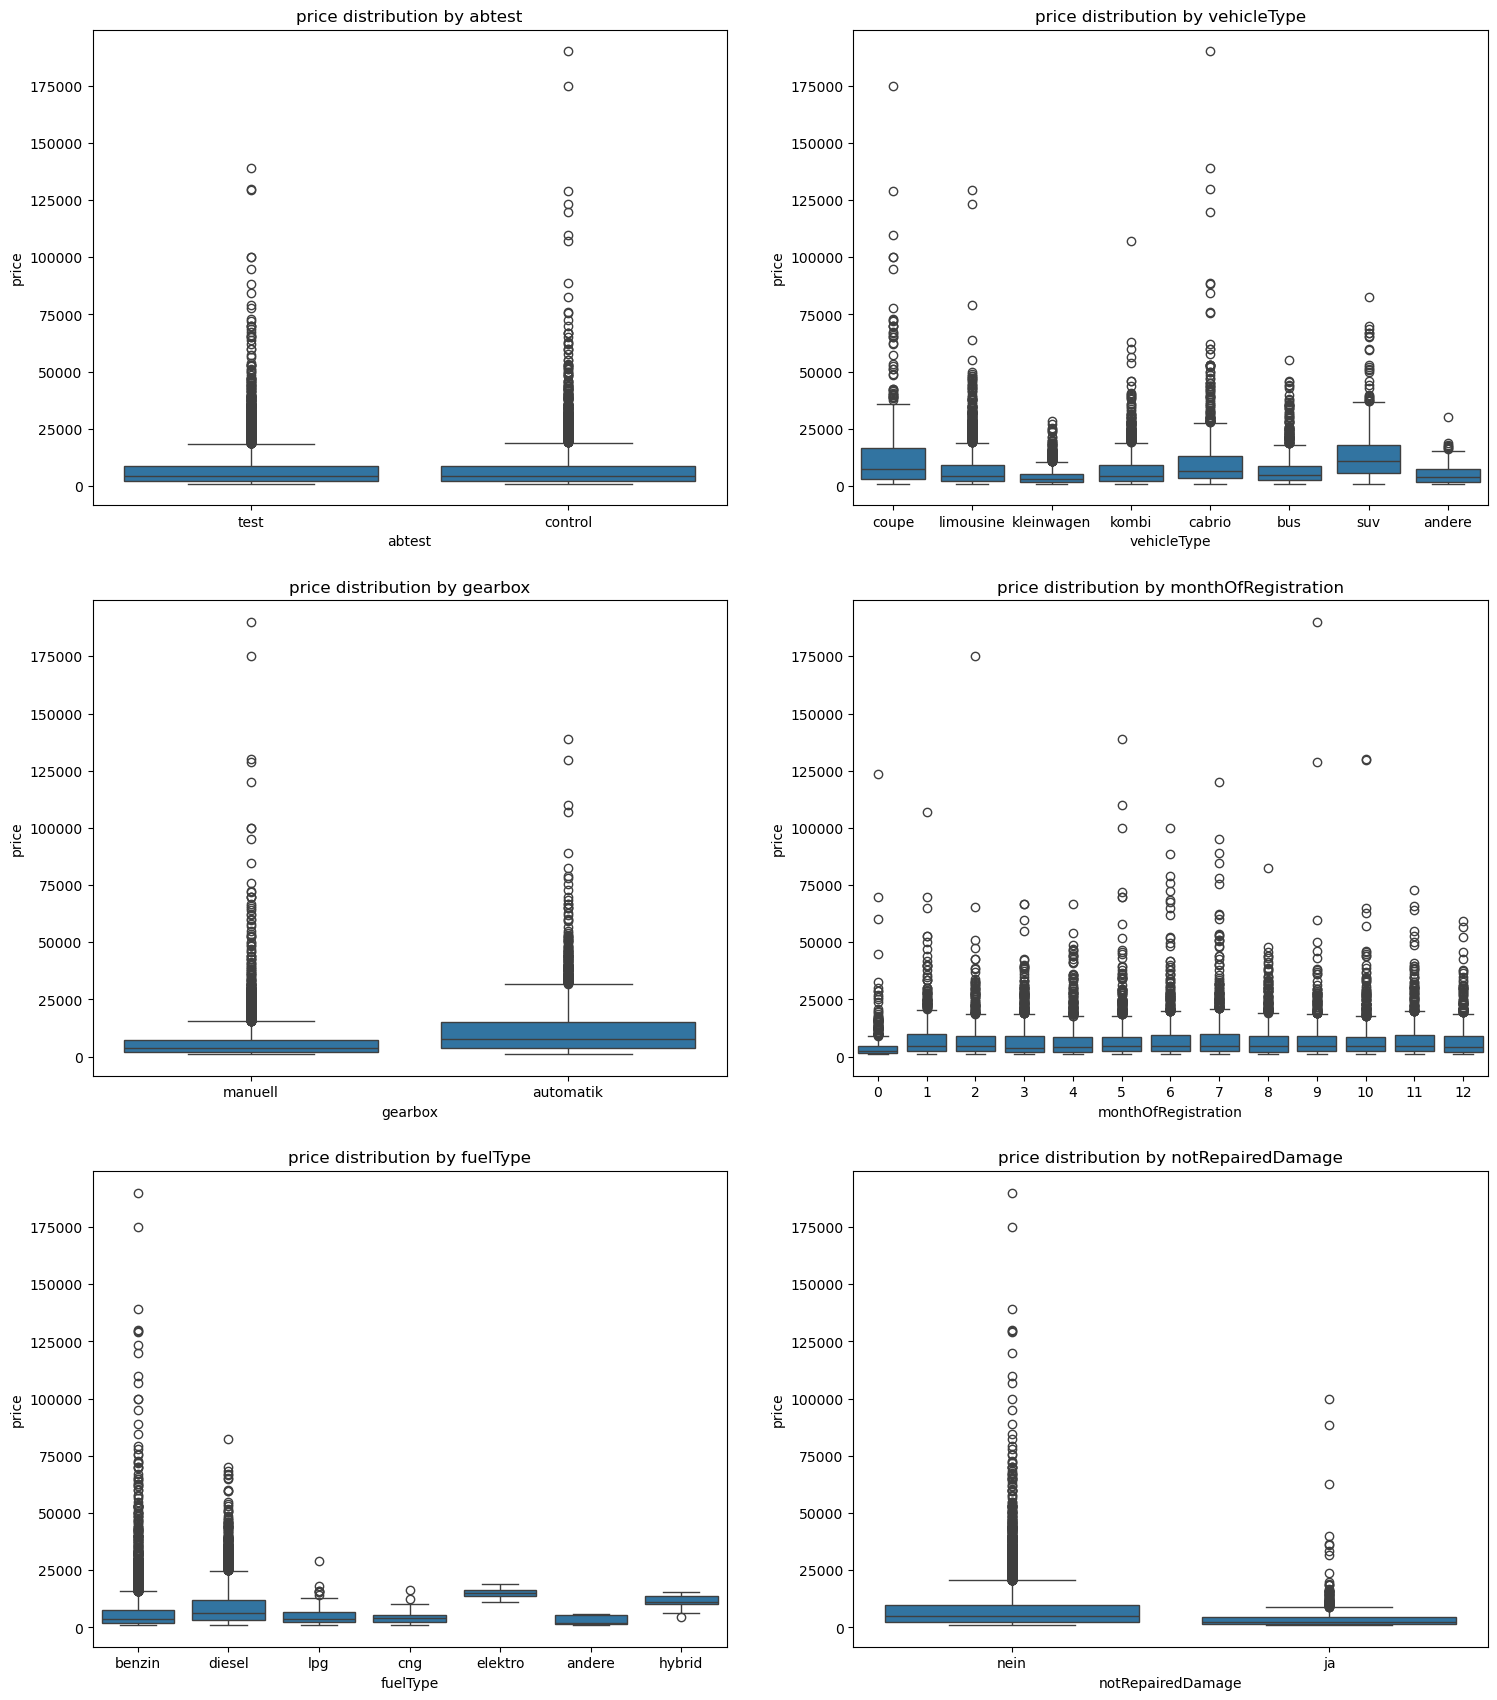

In [41]:
# Barplots: Visualize statistical measures (mean, std, median) of price for each category of a categorical variable.
categorical_features = ['abtest', 'vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage']
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in categorical_features:
    sns.boxplot(y='price', x=feature, data=df, ax=axs[i,j])
    axs[i,j].set_title(f"price distribution by {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

* From the above boxplots, we observe similar behaviours as the barplots. 
* We should note, that every category value has a large amount of outliers

# We do the same for brand and model:

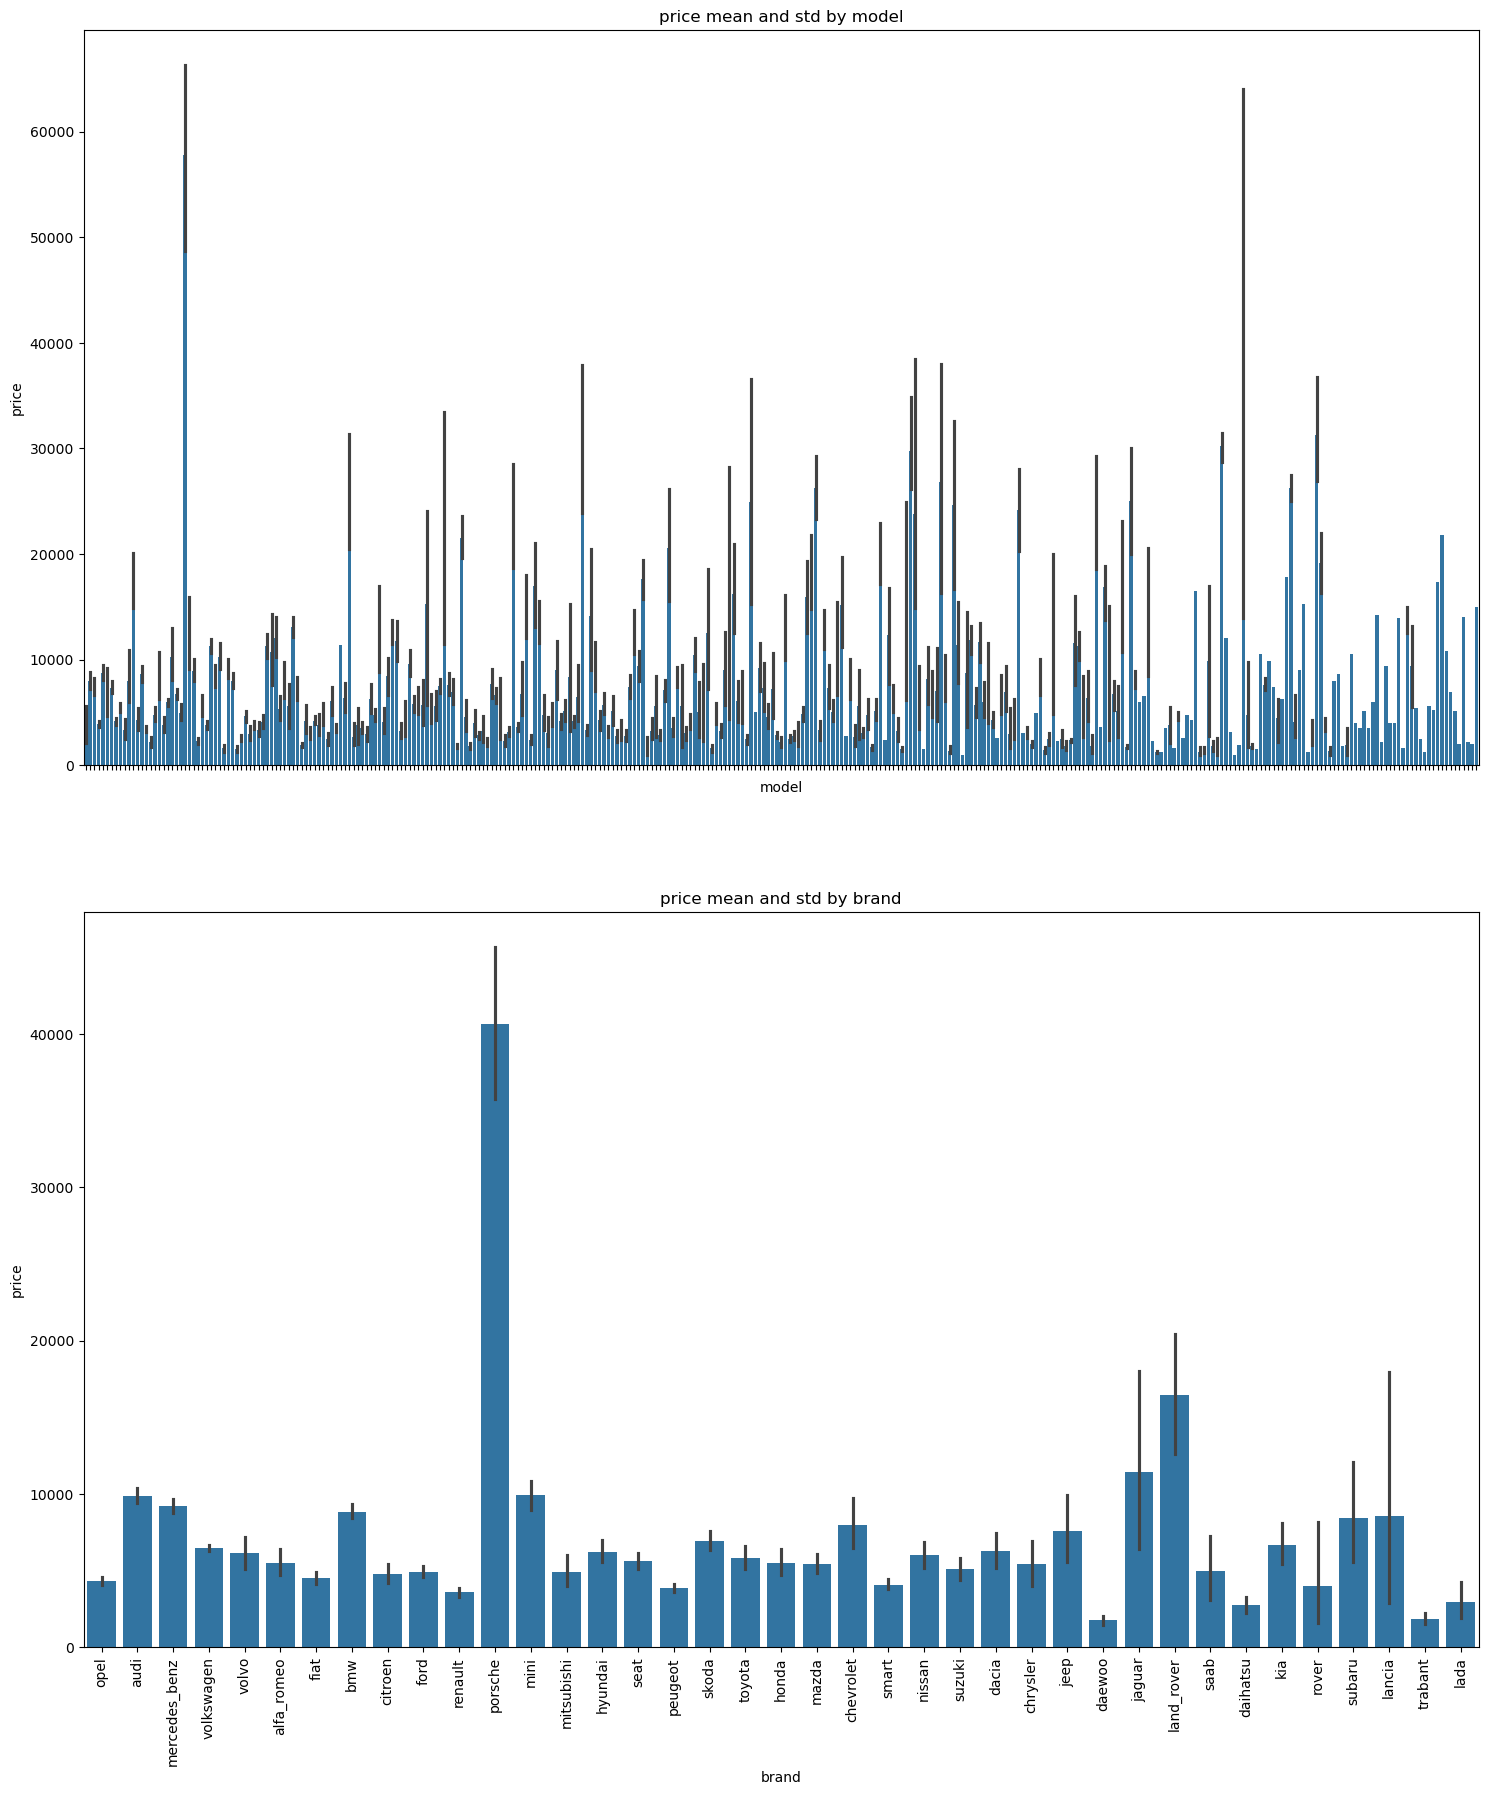

In [42]:
# model brand
nrows, ncols = 2, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))

# Plot model distribution
sns.barplot(y='price', x='model', data=df, ax=axs[0])
axs[0].set_title("price mean and std by model")
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_xticklabels([])

sns.barplot(y='price', x='brand', data=df, ax=axs[1])
axs[1].set_title("price mean and std by brand")
axs[1].tick_params(axis='x', rotation=90)

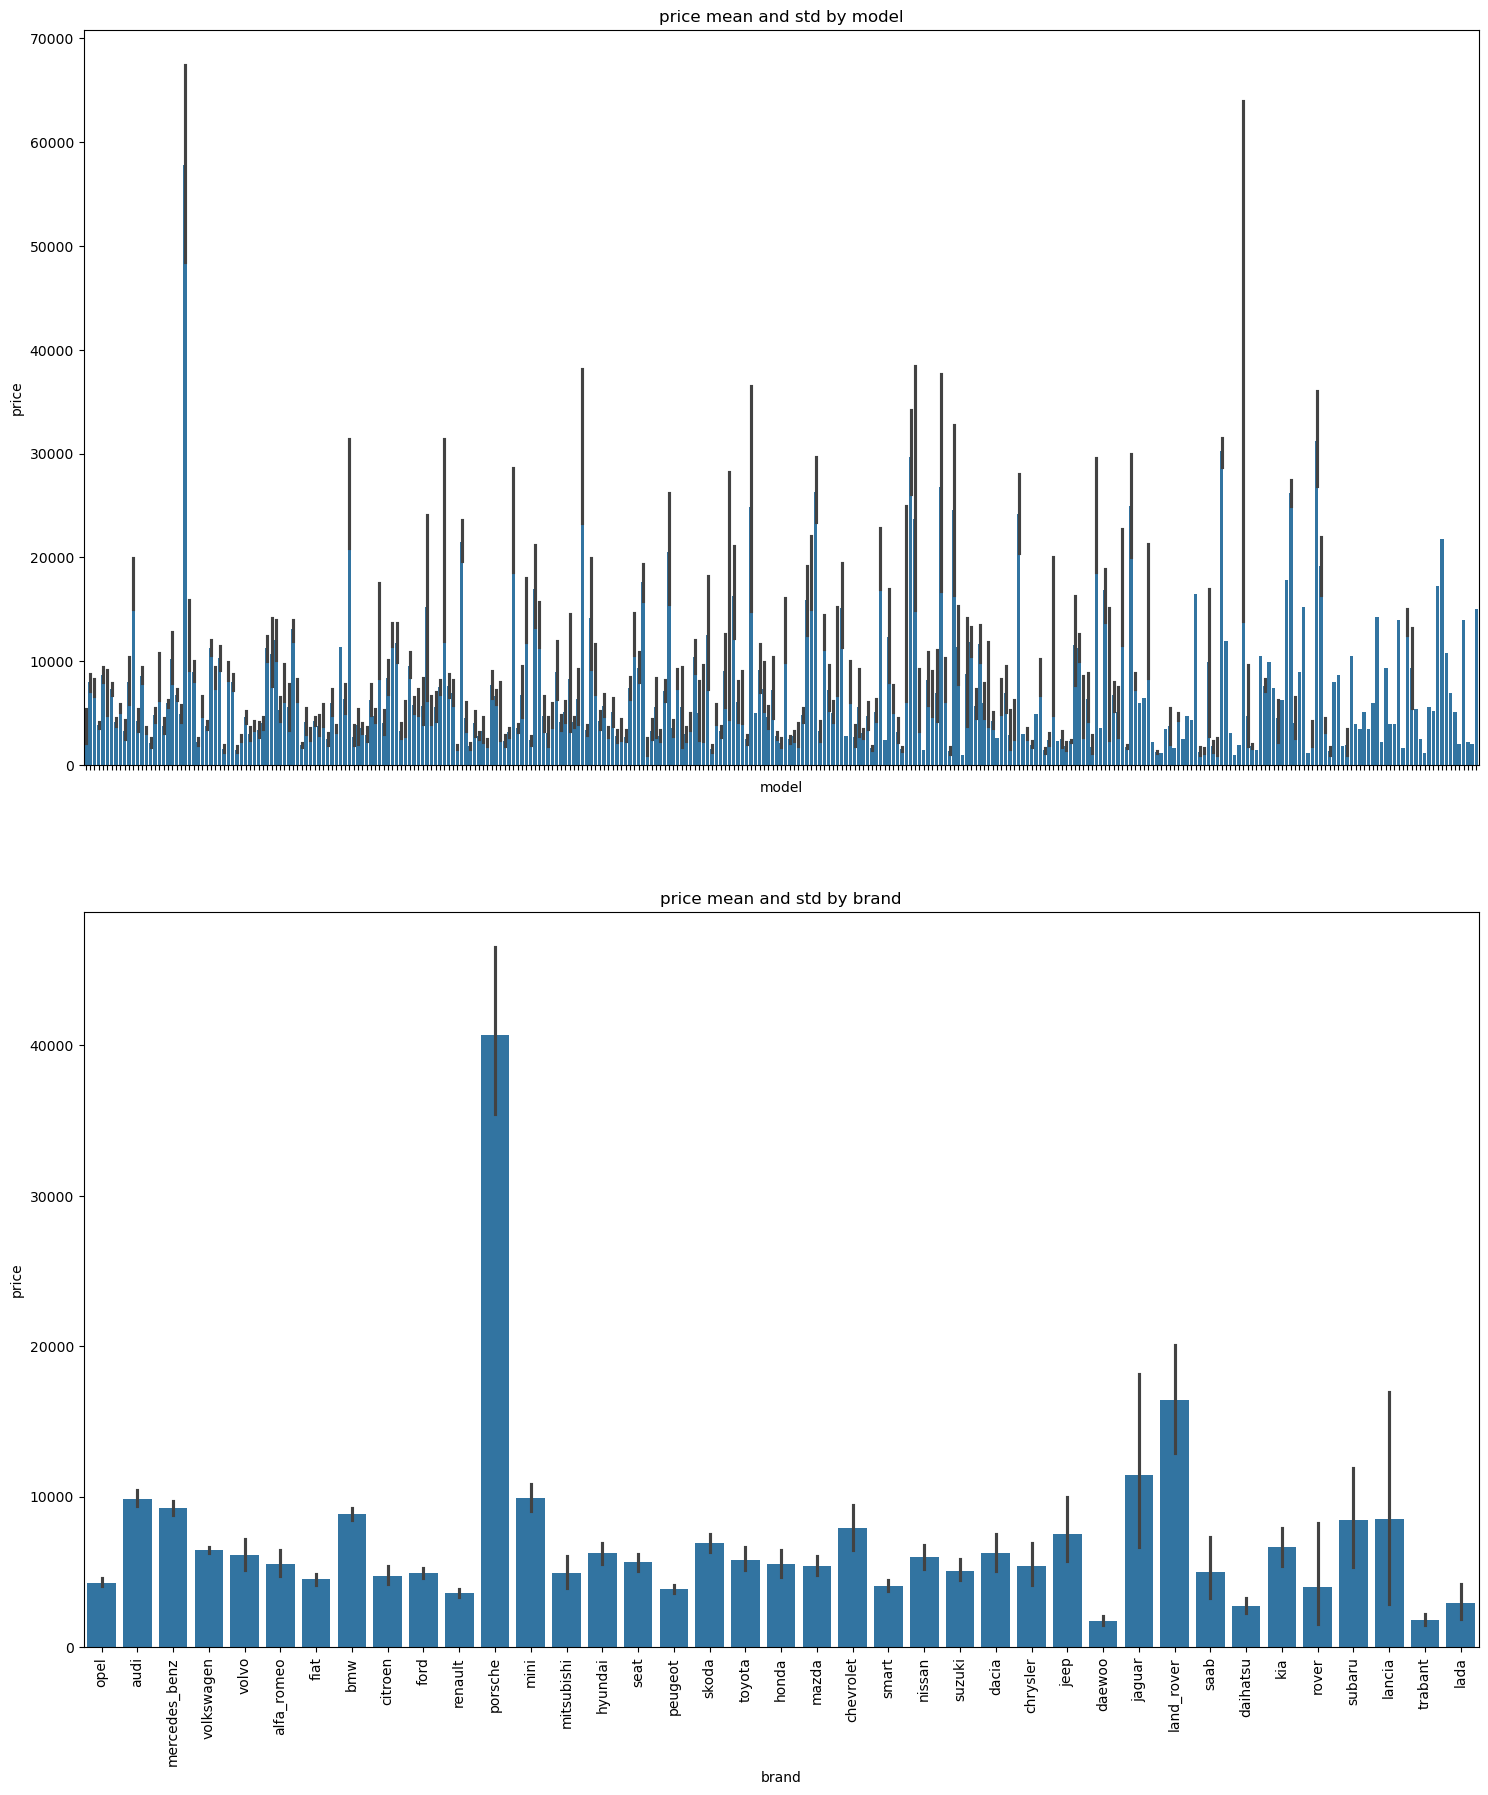

In [43]:
# model brand
nrows, ncols = 2, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))

# plot model distribution
sns.barplot(y='price', x='model', data=df, ax=axs[0])
axs[0].set_title("price mean and std by model")
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_xticklabels([])

# plot brand distribution
sns.barplot(y='price', x='brand', data=df, ax=axs[1])
axs[1].set_title("price mean and std by brand")
axs[1].tick_params(axis='x', rotation=90)

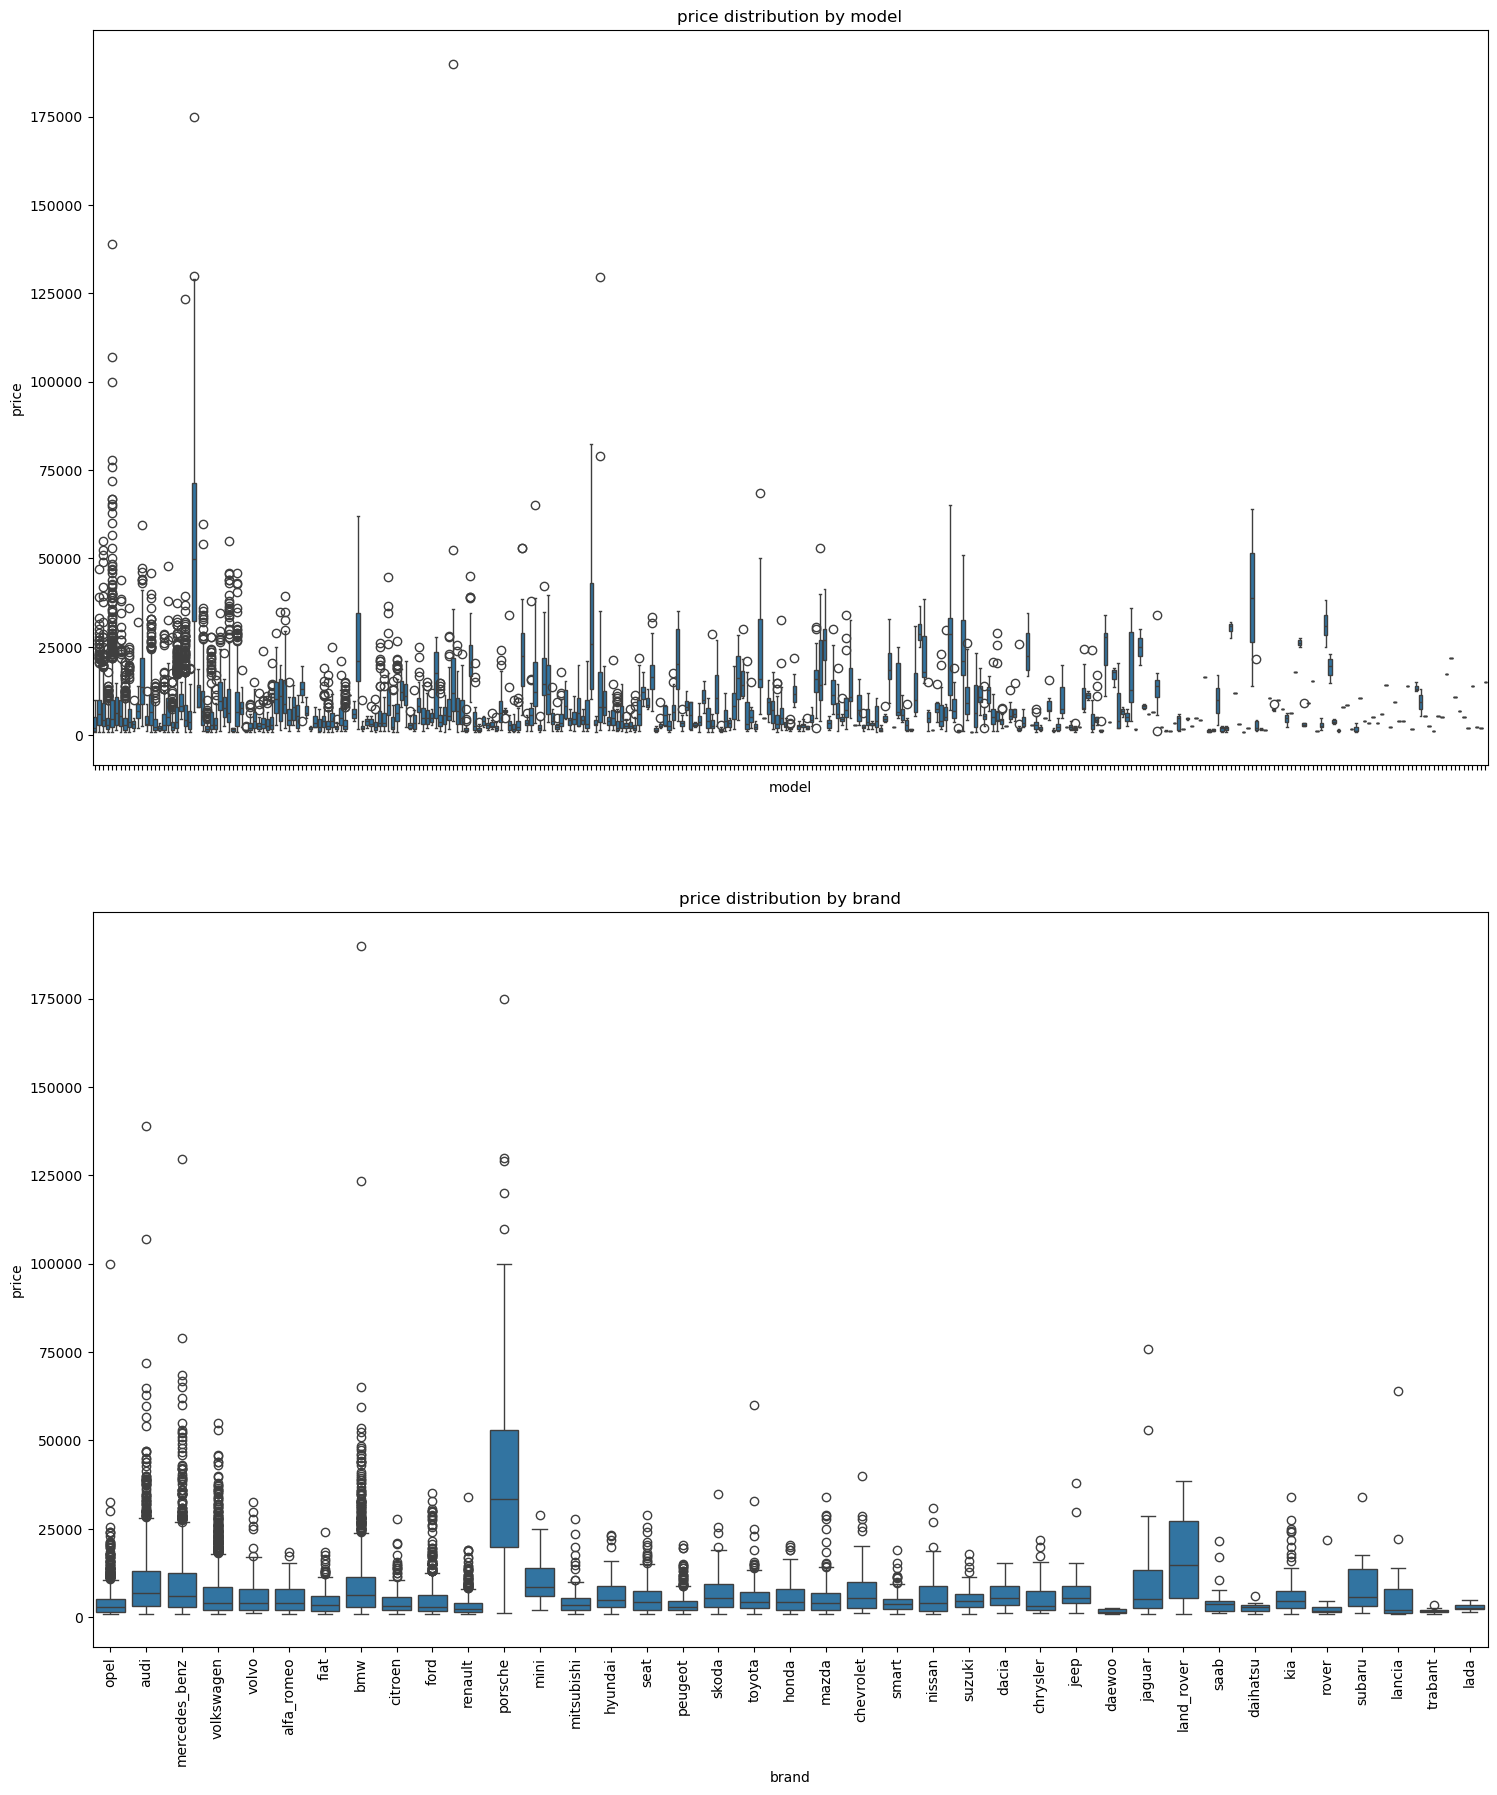

In [44]:
# model brand
nrows, ncols = 2, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))

# plot model distribution
sns.boxplot(y='price', x='model', data=df, ax=axs[0])
axs[0].set_title("price distribution by model")
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_xticklabels([])

# plot brand distribution
sns.boxplot(y='price', x='brand', data=df, ax=axs[1])
axs[1].set_title("price distribution by brand")
axs[1].tick_params(axis='x', rotation=90)

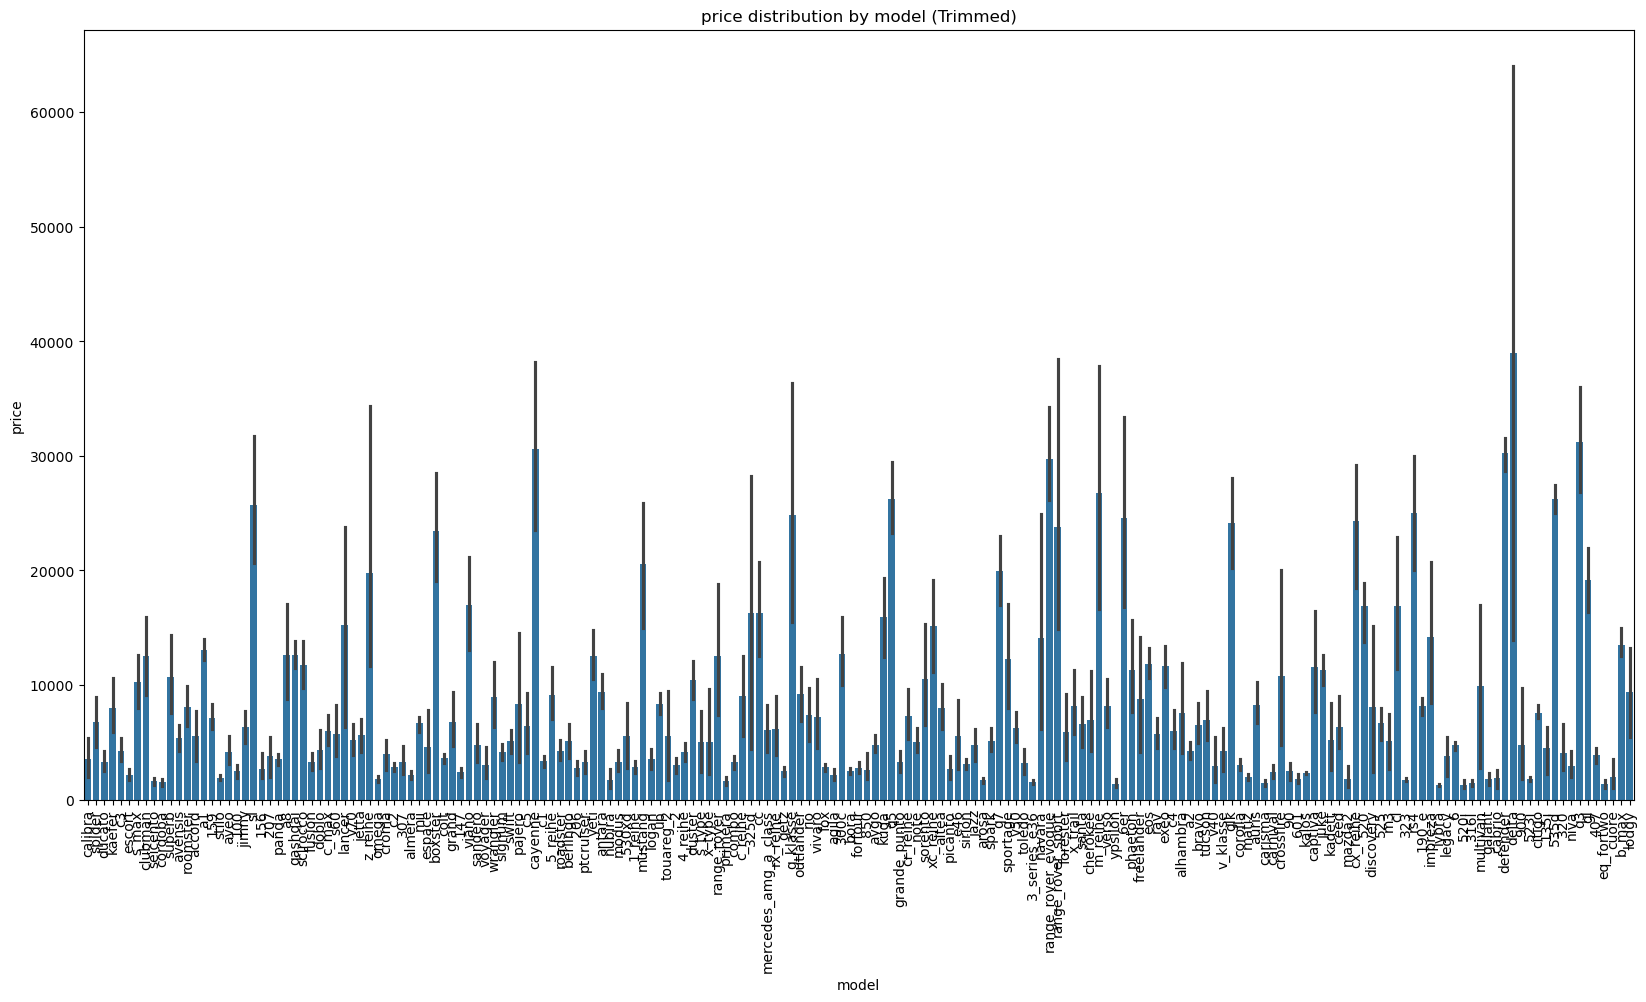

In [45]:

# Count how many times each model appears
model_counts = df['model'].value_counts()

# Determine quantile thresholds
q_low, q_high = model_counts.quantile([0.22, 0.78])

# Keep models within those frequency bounds
valid_models = model_counts[(model_counts >= q_low) & (model_counts <= q_high)].index

# Filter the DataFrame
df_trimmed = df[df['model'].isin(valid_models)]

# Plotting
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

# Model plot
sns.barplot(y='price', x='model', data=df_trimmed)
axs.set_title("price distribution by model (Trimmed)")
axs.tick_params(axis='x', rotation=90)

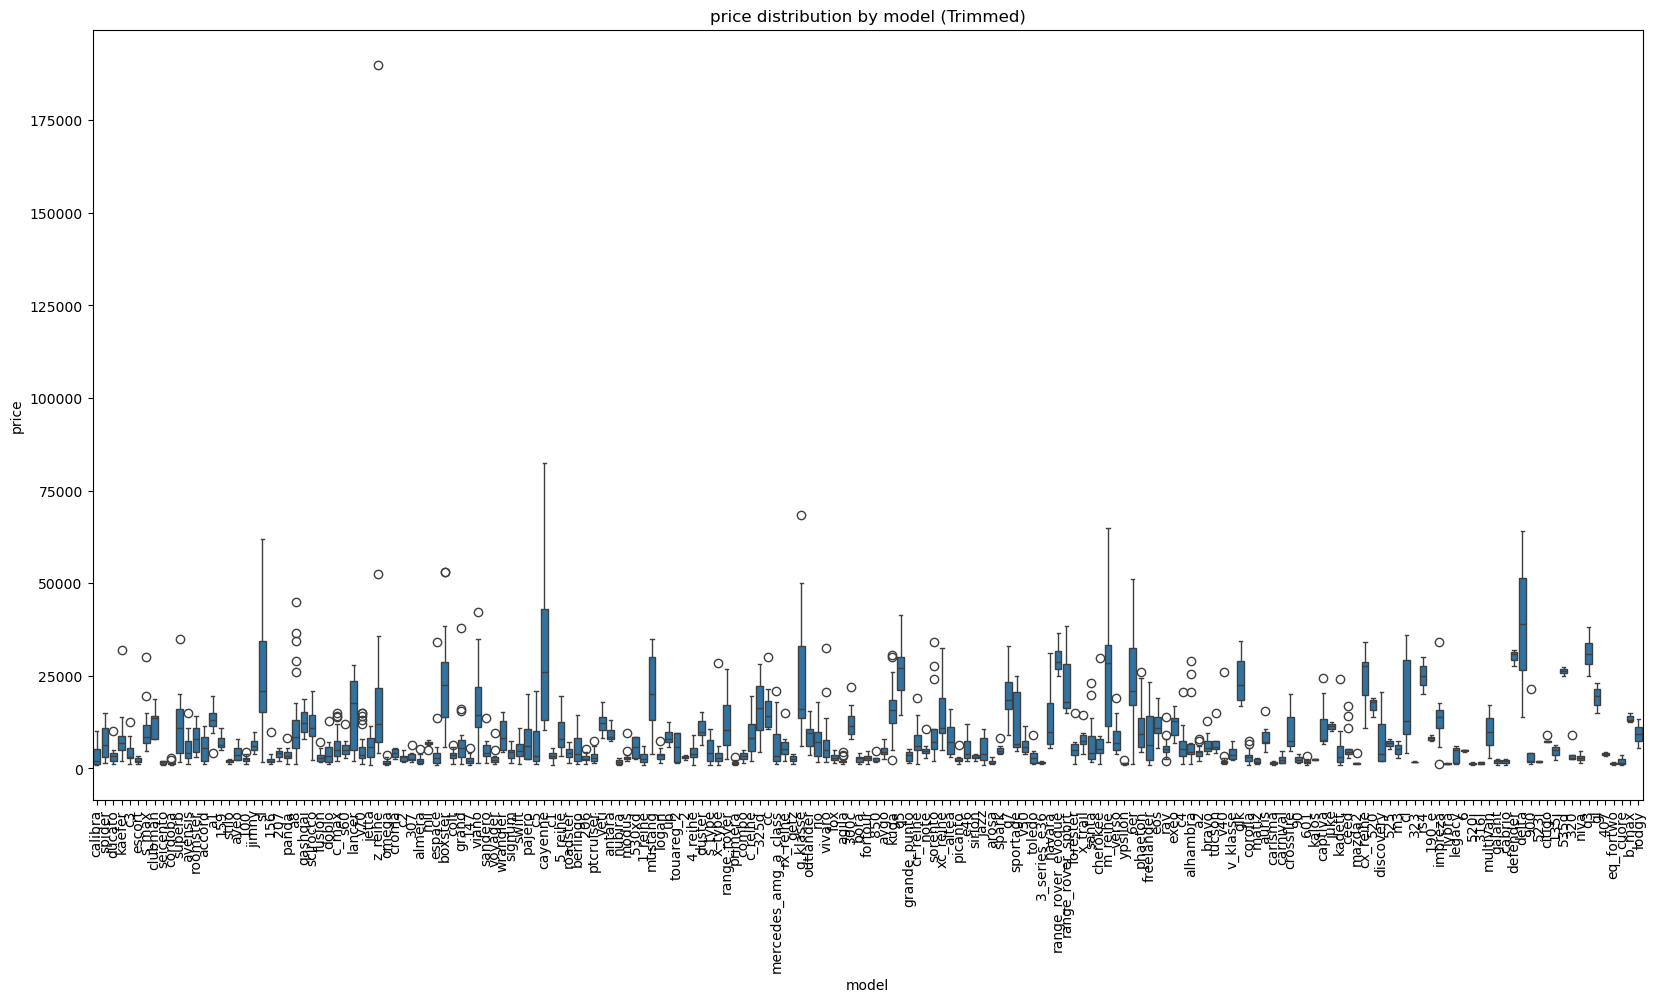

In [46]:

# Count how many times each model appears
model_counts = df['model'].value_counts()

# Determine quantile thresholds
q_low, q_high = model_counts.quantile([0.22, 0.78])

# Keep models within those frequency bounds
valid_models = model_counts[(model_counts >= q_low) & (model_counts <= q_high)].index

# Filter the DataFrame
df_trimmed = df[df['model'].isin(valid_models)]

# Plotting
nrows, ncols = 1, 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

# Model plot
sns.boxplot(y='price', x='model', data=df_trimmed)
axs.set_title("price distribution by model (Trimmed)")
axs.tick_params(axis='x', rotation=90)

* model:
   * we can see very clearly that there's a high correlation between model and price
   * for most values, there's high deviation
   * different models within the same brand vary in price, for example 911 and cayenne are both porsche
* brand:
   * we can see very clearly that there's a high correlation between brand and price
   * most brands have low deviation except for a few... this needs more investigation

#### General observations:
* perhaps the reason behind each deviation of a brand, is in it's various models
* a car of the same model might have not repaired damage, might be older, or vary in any of the rest features that have a correlation to price
* each brand or model has outliers, some more than others

In [47]:
categorical_features = ['abtest', 'vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage', 'brand', 'model']
for feature in categorical_features:
    print(df.groupby(feature)['price'].agg(['mean', 'std', 'median']))
    print(df.groupby(feature)['price'].count())
    print('='*60)

                mean          std  median
abtest                                   
control  7158.669296  8770.571902  4390.0
test     7107.316571  8373.339625  4350.0
abtest
control    6846
test       7338
Name: price, dtype: int64
                     mean           std   median
vehicleType                                     
andere        5568.545455   4998.183500   3899.0
bus           7037.977761   6685.950511   4850.0
cabrio       10757.941547  13617.895958   6625.0
coupe        12469.952685  15736.659926   7499.5
kleinwagen    3999.358163   3344.512173   2899.0
kombi         6795.054204   6694.370962   4500.0
limousine     7028.395732   7592.081096   4500.0
suv          13745.625786  11610.007514  10775.0
vehicleType
andere         121
bus           1349
cabrio        1112
coupe          782
kleinwagen    2591
kombi         2712
limousine     3889
suv            636
Name: price, dtype: int64
                   mean           std  median
gearbox                                  

In [48]:
bins_df = df.copy()
bins_df['price_category'] = pd.cut(df['price'], bins=[0, 5000, 10_000, 50_000, np.inf], labels=["low", "low average", "middle average", "high"])
bins_df.head()

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen,price_category
348986,2016-03-25 19:57:53,10000,test,coupe,1992,manuell,0,calibra,150000,10,benzin,opel,nein,2016-03-25 00:00:00,94269,2016-04-05 00:17:25,low average
32810,2016-03-24 12:57:58,3398,test,limousine,2003,manuell,102,a3,150000,3,benzin,audi,nein,2016-03-24 00:00:00,36043,2016-04-07 04:45:42,low
342339,2016-03-29 08:55:03,1400,control,limousine,1996,manuell,0,c_klasse,150000,6,benzin,mercedes_benz,NaN,2016-03-29 00:00:00,38162,2016-04-05 18:18:29,low
206349,2016-03-12 18:53:47,6900,test,kleinwagen,2006,manuell,80,polo,70000,7,benzin,volkswagen,nein,2016-03-12 00:00:00,22941,2016-03-16 00:47:02,low average
337351,2016-03-08 14:48:42,1600,test,kombi,1992,automatik,131,andere,150000,3,benzin,volvo,nein,2016-03-08 00:00:00,28844,2016-03-08 14:48:42,low


Text(0, 0.5, 'Frequency')

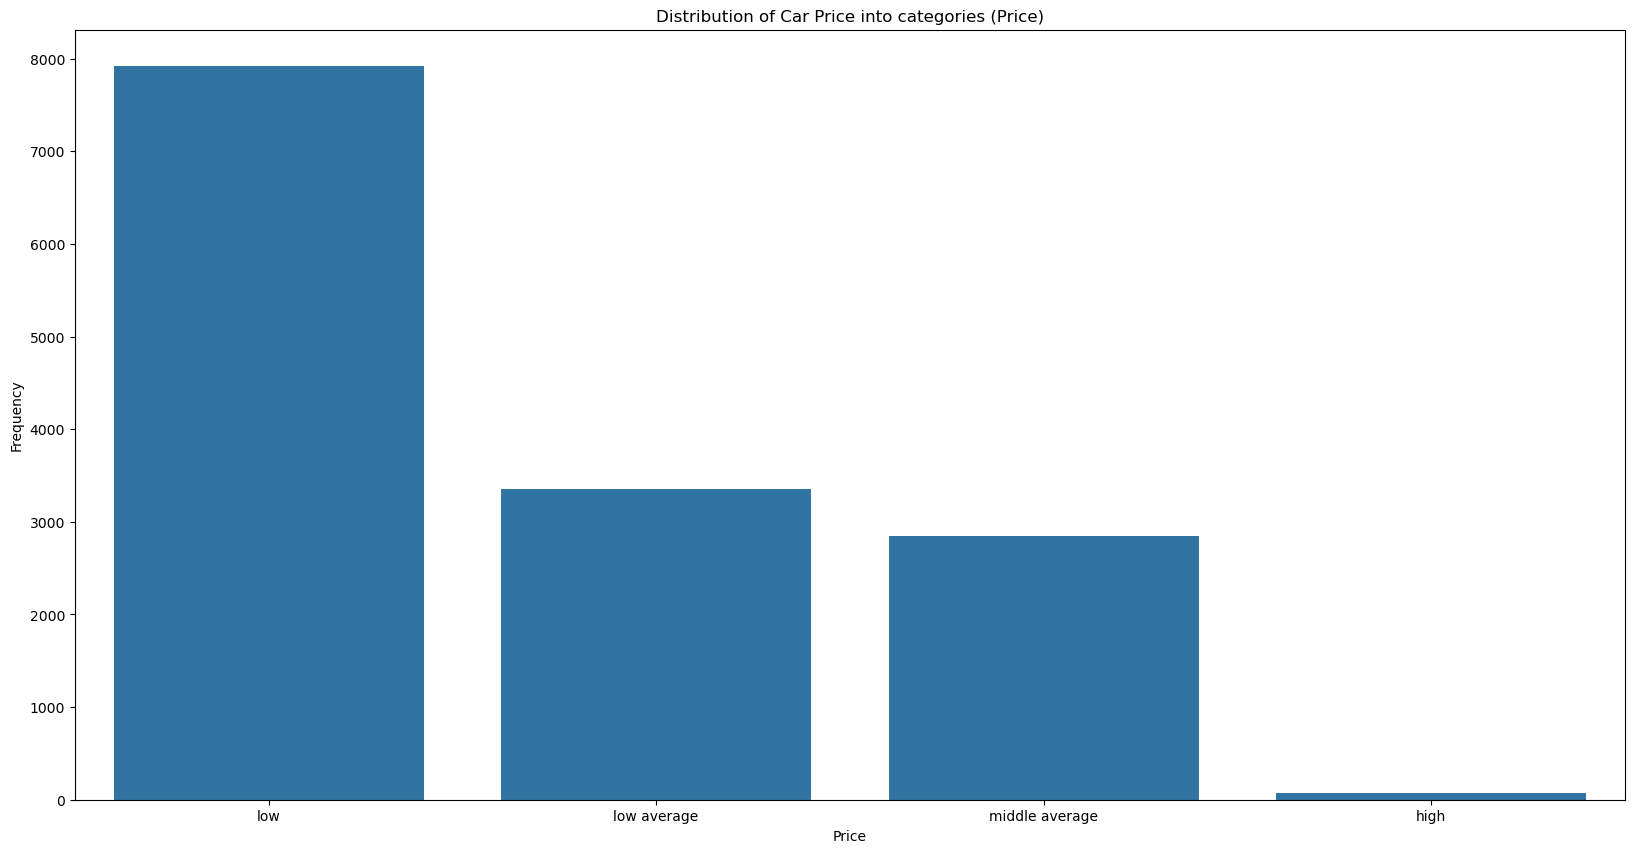

In [49]:
# distribution
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(data=bins_df, x="price_category")
ax.set_title("Distribution of Car Price into categories (Price)")
ax.set_xlabel("Price")
ax.set_ylabel("Frequency")

Dominant bin is low, meaning our model will perform better on cars with lower prices, also decent on average prices. Since we have very few high instances, our model will sruggle for such prices

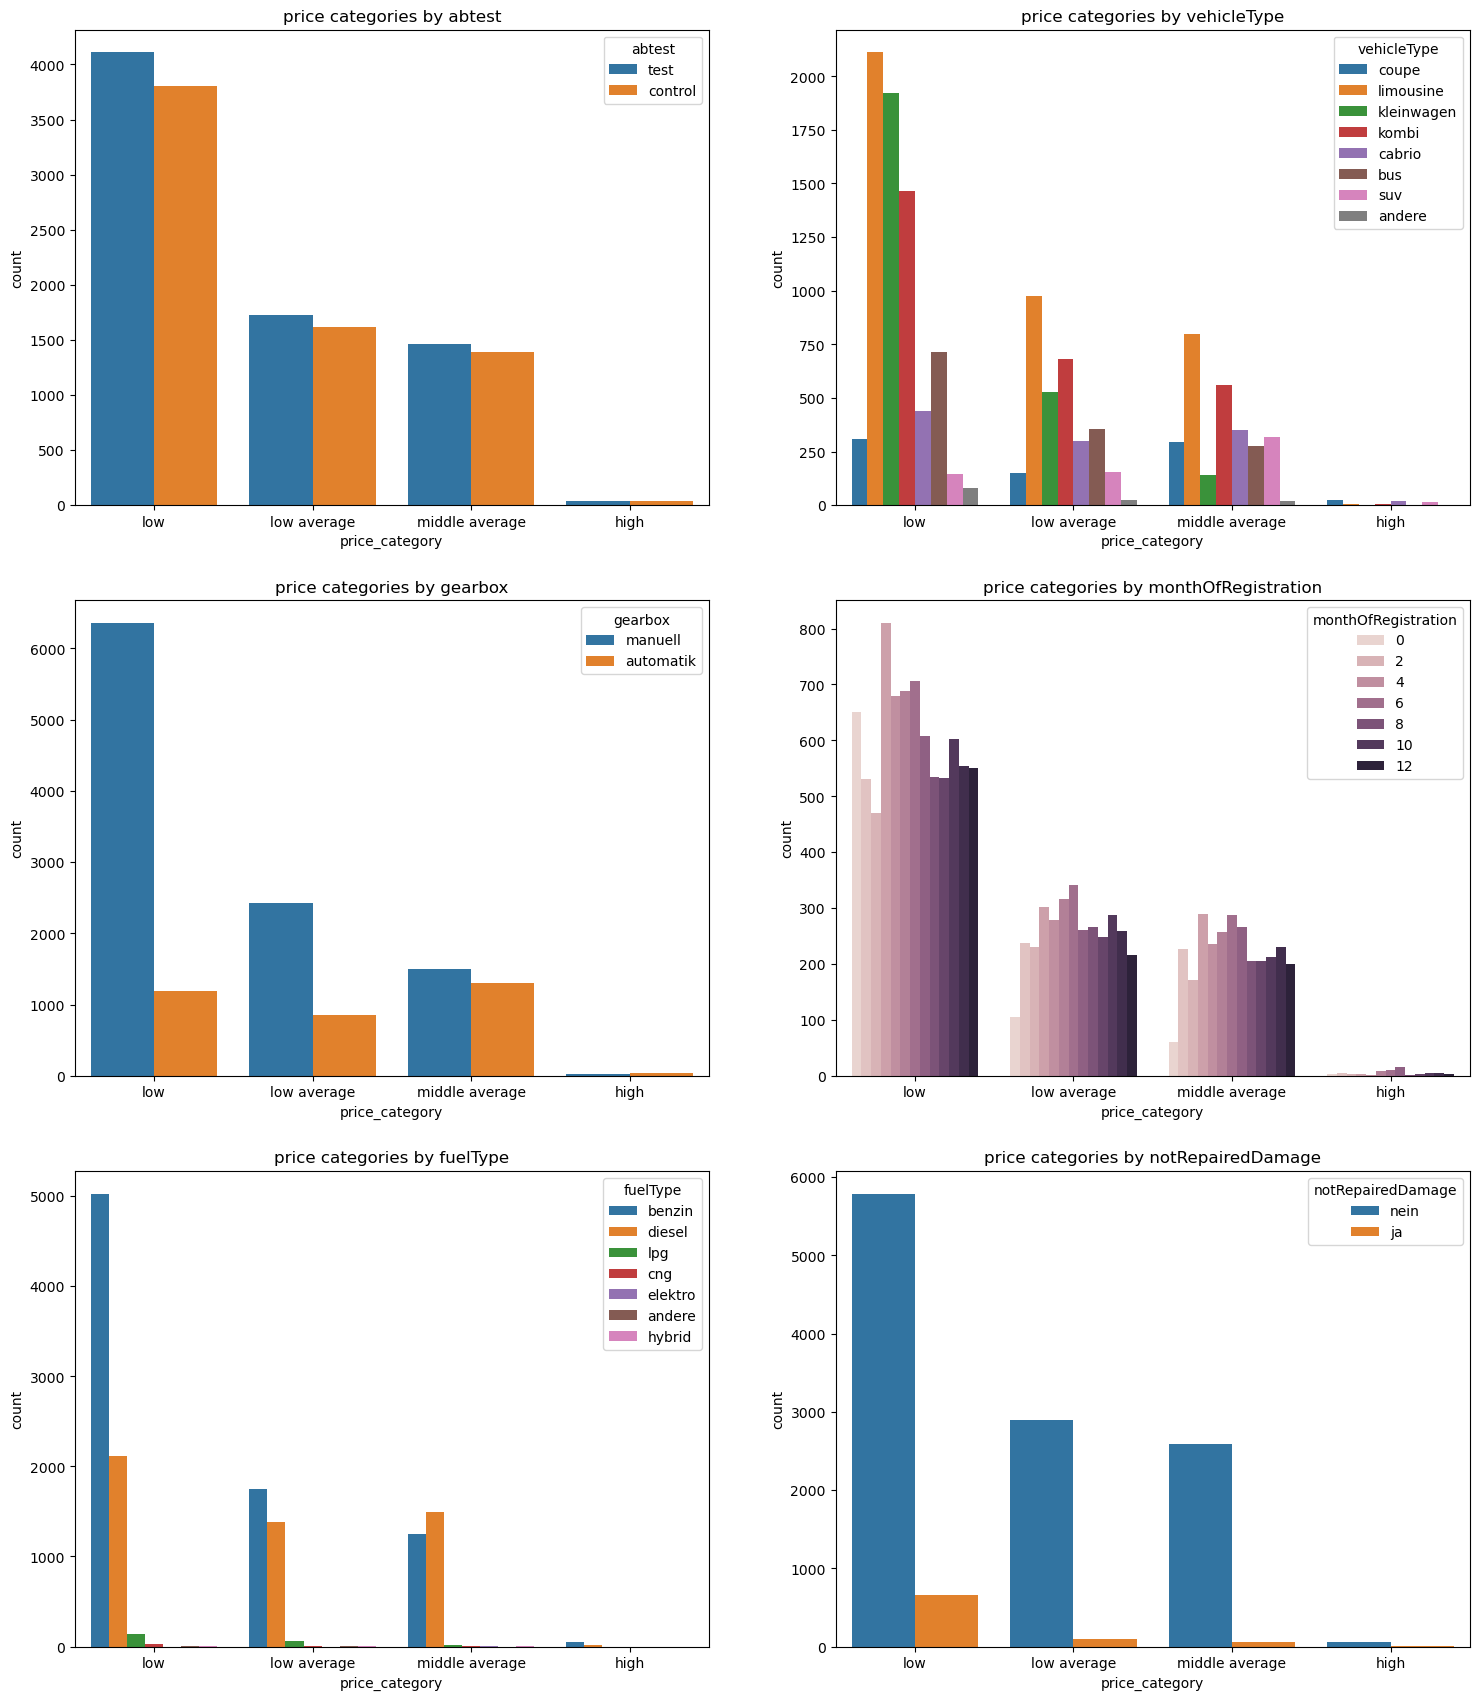

In [50]:
categorical_features = ['abtest', 'vehicleType', 'gearbox', 'monthOfRegistration', 'fuelType', 'notRepairedDamage']
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i, j = 0, 0
for feature in categorical_features:
    sns.countplot(x='price_category', hue=feature, data=bins_df, ax=axs[i,j])
    axs[i,j].set_title(f"price categories by {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

## Numerical Features Analysis

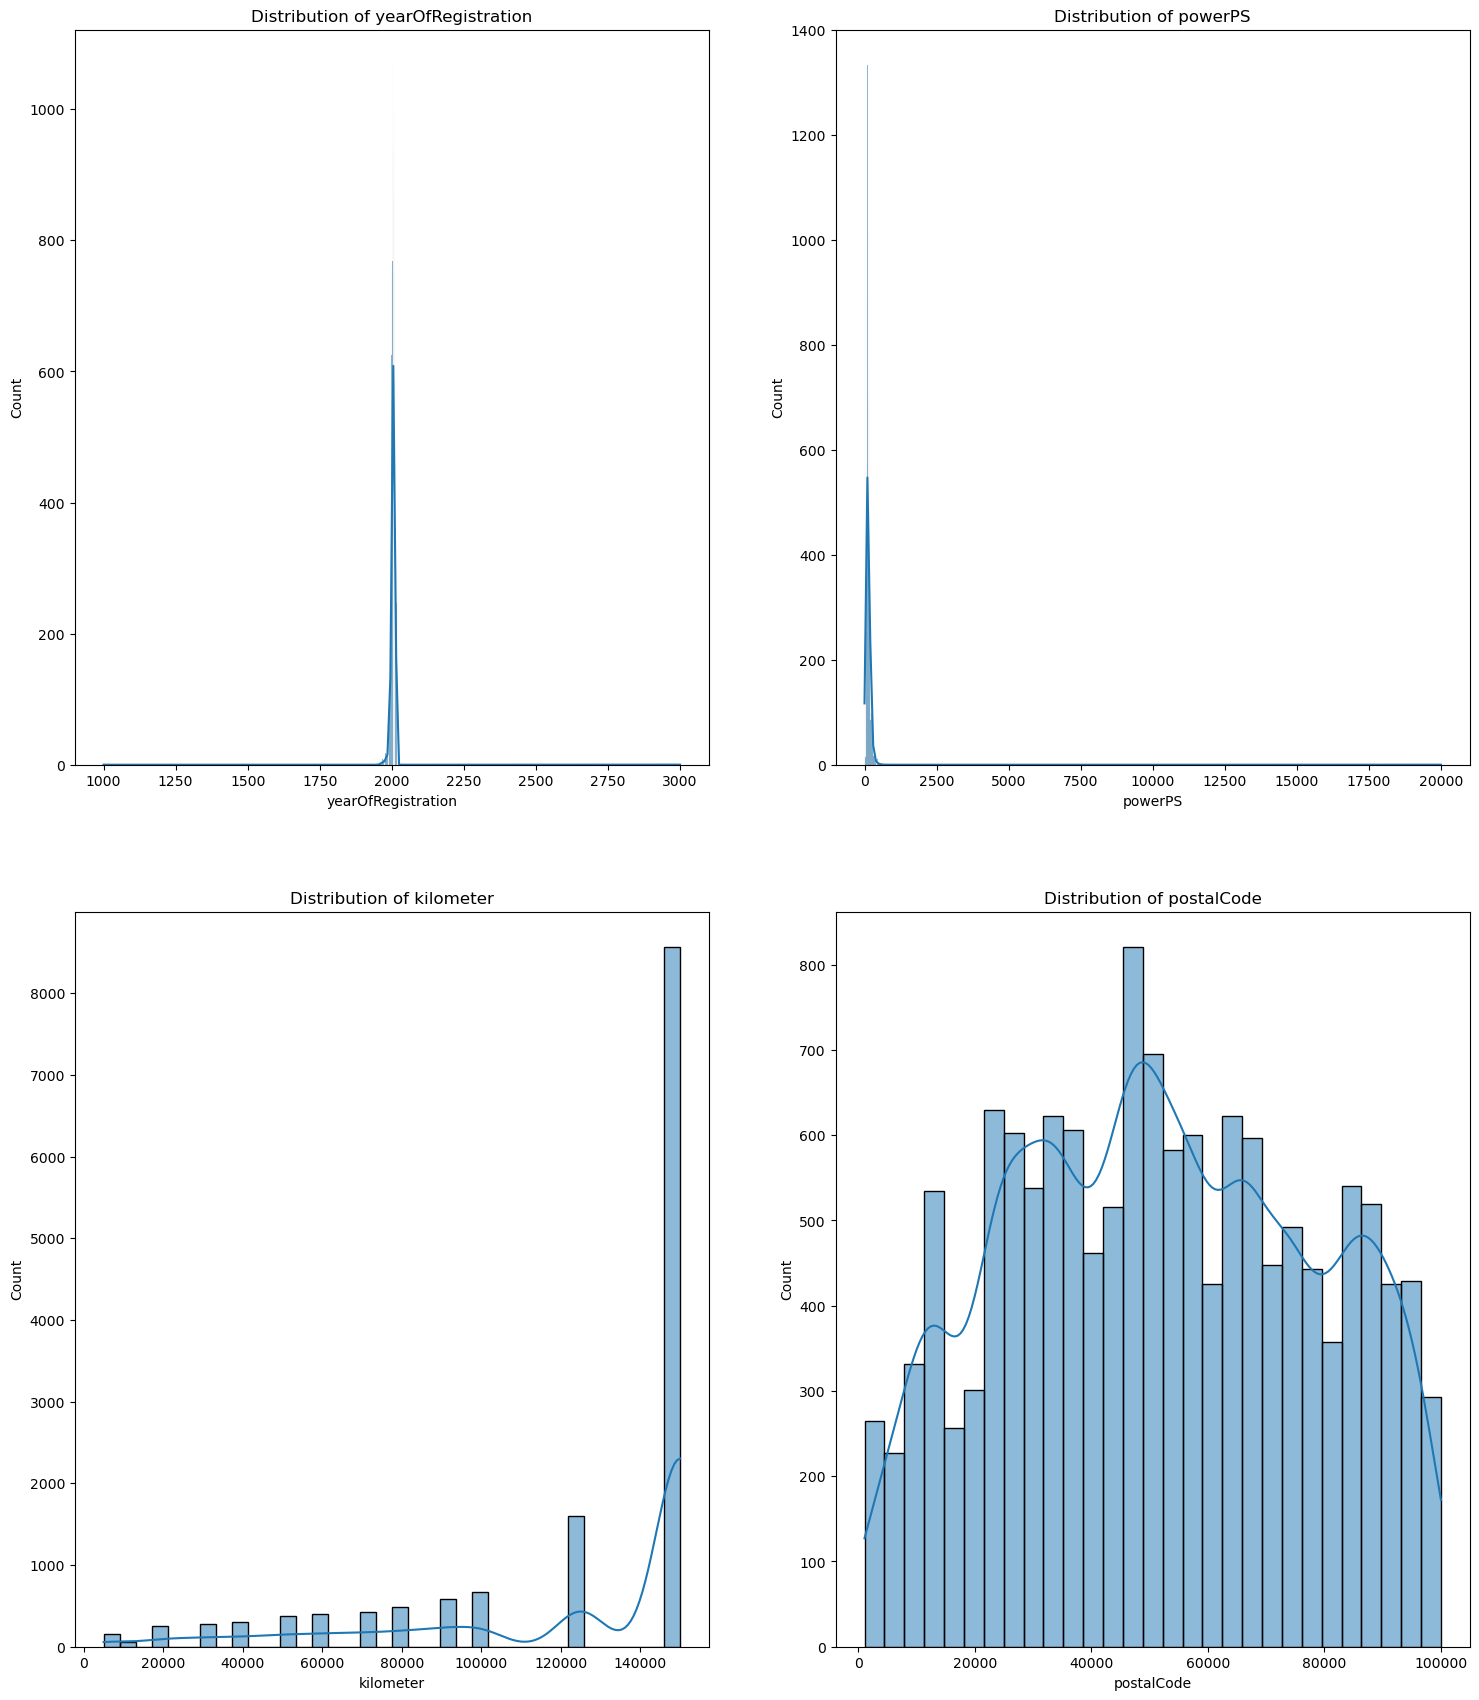

In [51]:
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
nrows,ncols = 2,2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in numerical_features:
    sns.histplot(df[feature], kde=True, ax=axs[i,j])
    axs[i,j].set_title(f"Distribution of {feature}")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

* kilometer seems to be left skewed, while postalCode doesn't skew in any particular direction.
* clearly, most cars have a very high number of kilometers

In [52]:
# all yearOfRegistration values less than 1920 are invalid (we have checked one by one)
# all values that we have checked over 1920 seem valid
tmp = df[(df['yearOfRegistration'] < 1940) & (df['yearOfRegistration'] > 1920)]
tmp

,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
82225,2016-03-08 09:56:32,39999,control,coupe,1931,automatik,247,andere,40000,6,benzin,chevrolet,ja,2016-03-08 00:00:00,88356,2016-03-28 15:47:03
354533,2016-03-05 17:45:32,7000,test,coupe,1937,manuell,85,andere,5000,8,benzin,ford,ja,2016-03-05 00:00:00,8359,2016-04-07 10:44:39


Text(0.5, 1.0, 'Distribution of yearOfRegistration')

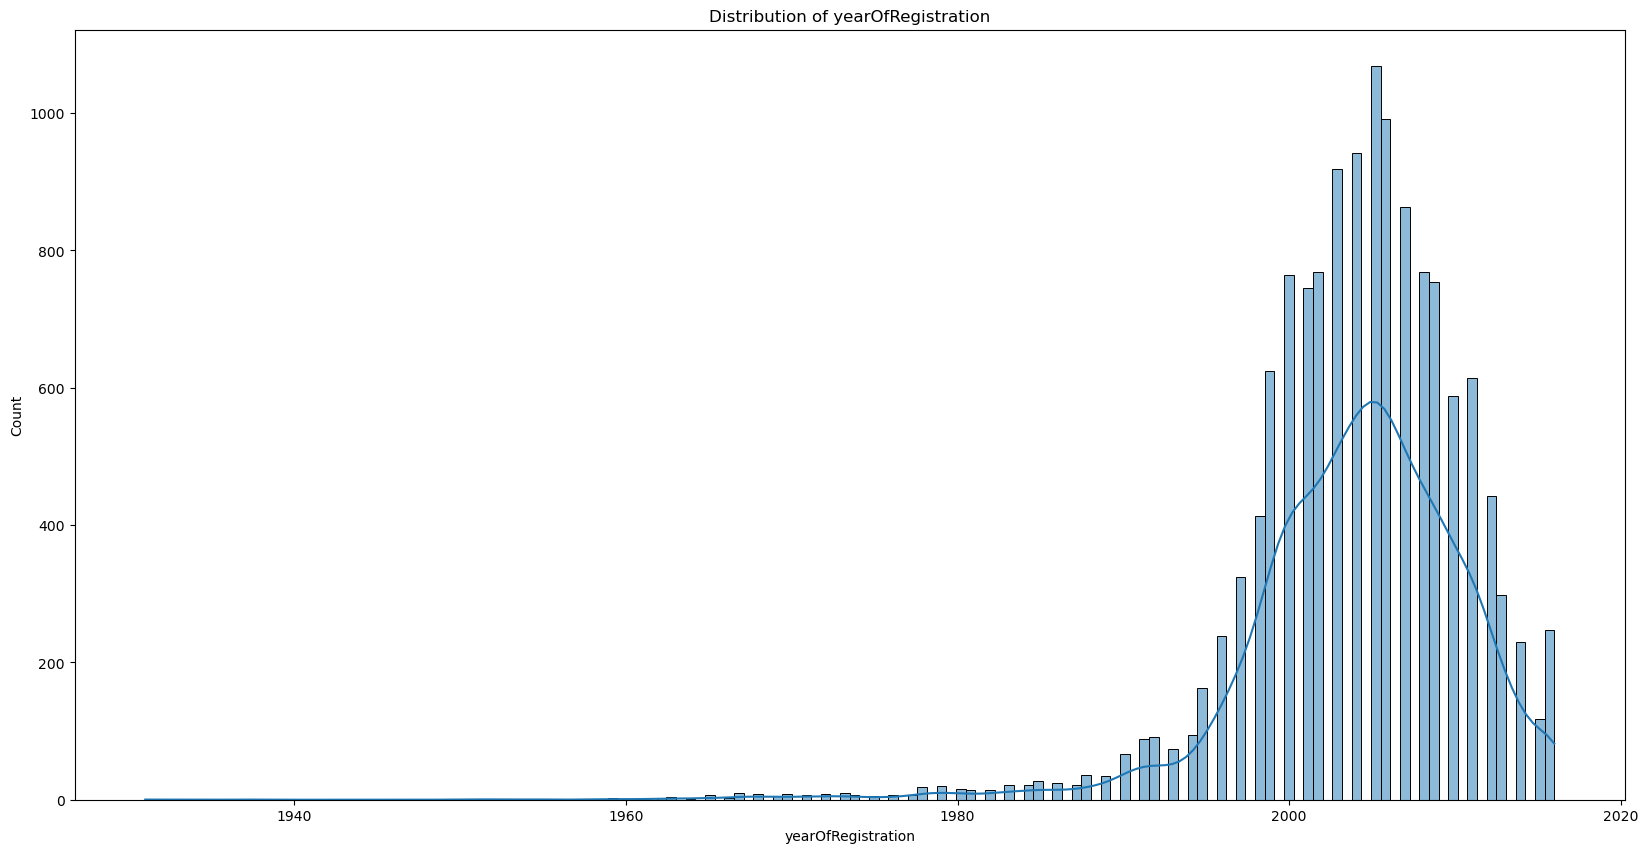

In [53]:
# For Valid year of registration
df_valid_yearOfRegistration = df[(df['yearOfRegistration'] >= 1920) & (df['yearOfRegistration'] <= 2016)]
nrows,ncols = 1,1
fig, axs = plt.subplots(nrows, ncols, figsize=(20,10))

sns.histplot(df_valid_yearOfRegistration['yearOfRegistration'], kde=True)
axs.set_title(f"Distribution of yearOfRegistration")

This looks a bit left skewed...

In [54]:
# Do not anything before split
df["yearOfRegistration"].sort_values(ascending=True).head(n=20)
df[(df["yearOfRegistration"] < 1920) | (df["yearOfRegistration"] > 2016)].count()

dateCrawled            505
price                  505
abtest                 505
vehicleType              1
yearOfRegistration     505
gearbox                452
powerPS                505
model                  505
kilometer              505
monthOfRegistration    505
fuelType               321
brand                  505
notRepairedDamage      302
dateCreated            505
postalCode             505
lastSeen               505
dtype: int64

In [55]:
# all powerPS values greater than 1500 are assumed to be invalid for cars up to 200,000 price
df["powerPS"].sort_values(ascending=True).head(n=20)
df[(df["powerPS"] > 1500) | (df["powerPS"] < 4.5)].count()

dateCrawled            1007
price                  1007
abtest                 1007
vehicleType             726
yearOfRegistration     1007
gearbox                 720
powerPS                1007
model                  1007
kilometer              1007
monthOfRegistration    1007
fuelType                811
brand                  1007
notRepairedDamage       546
dateCreated            1007
postalCode             1007
lastSeen               1007
dtype: int64

Text(0.5, 1.0, 'Distribution of powerPS')

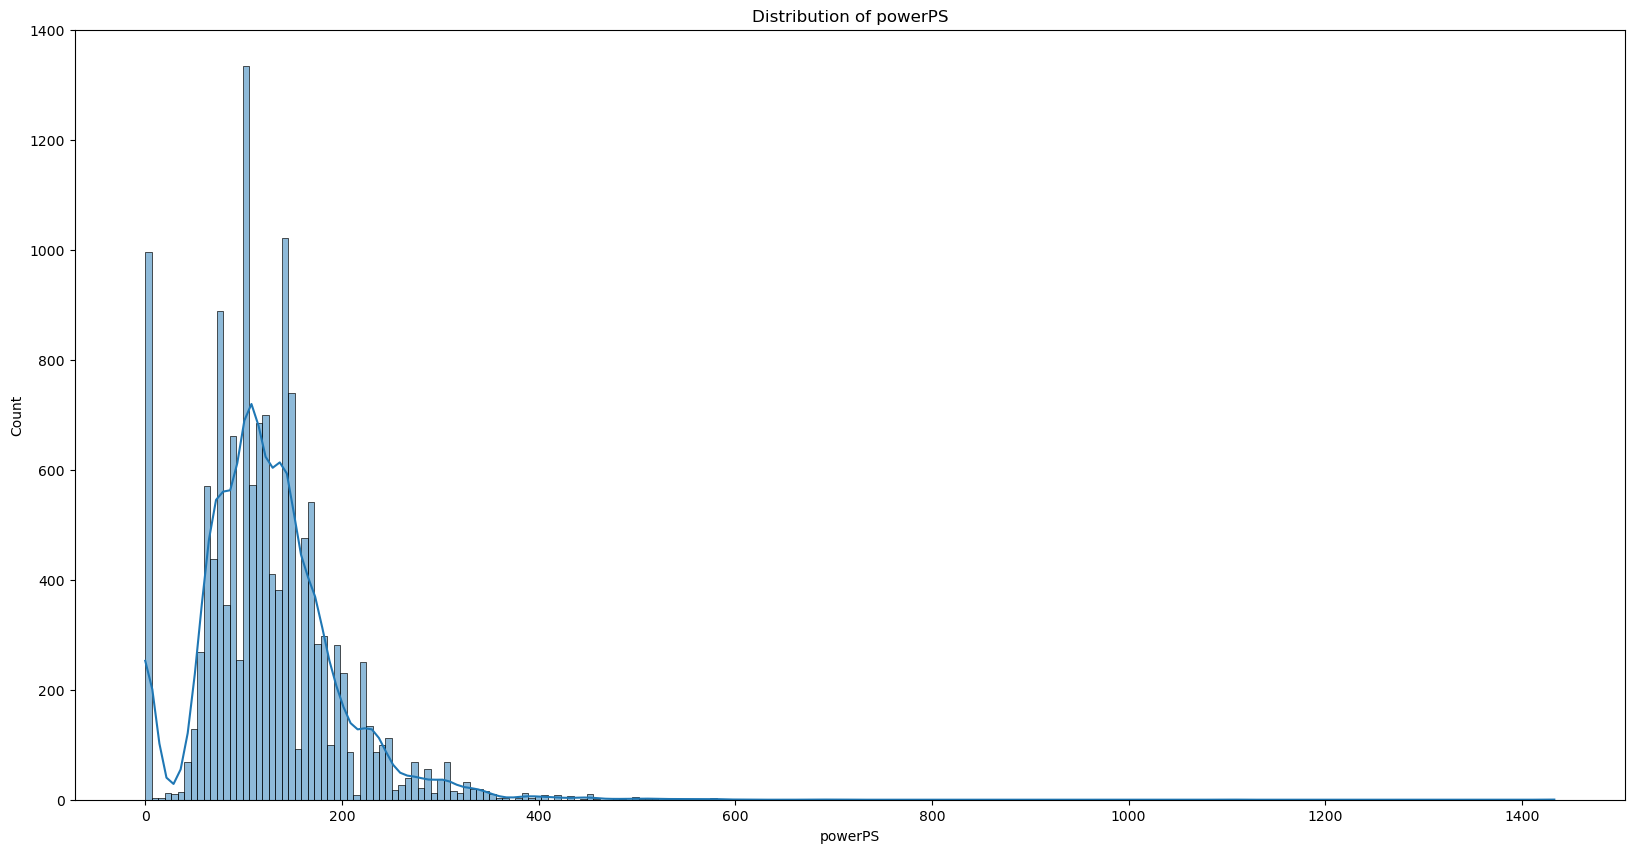

In [56]:
df_valid_powerPS = df[df['powerPS'] <= 1500]
nrows,ncols = 1,1
fig, axs = plt.subplots(nrows, ncols, figsize=(20,10))

sns.histplot(df_valid_powerPS['powerPS'], kde=True)
#sns.histplot(df['yearOfRegistration'], kde=True)
axs.set_title(f"Distribution of powerPS")

This looks a bit right skewed...

In [57]:
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
for feature in numerical_features:
    print(f"{feature} skewness:", df[feature].skew())
    print("="*50)
    
for feature in numerical_features:
    print(f"\nNormality tests for {feature}\n" + "="*50)
    results = run_normality_tests(df[feature])
    for test, result in results.items():
        print(f"{test}: {result}")

yearOfRegistration skewness: -0.9081363599182969
powerPS skewness: 65.75789429202922
kilometer skewness: -1.3204075494892664
postalCode skewness: 0.017135613627884082

Normality tests for yearOfRegistration
Anderson-Darling Test: {'Statistic': 1414.312353651576, 'Critical Values': array([0.576, 0.656, 0.787, 0.918, 1.092]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal': False}
Kolmogorov-Smirnov Test: {'Statistic': 0.21296581506453865, 'p-value': 0.0, 'Normal': False}
D’Agostino and Pearson’s Test: {'Statistic': 9668.704023040695, 'p-value': 0.0, 'Normal': False}
Jarque-Bera Test: {'Statistic': 8691753220.459137, 'p-value': 0.0, 'Normal': False}
Lilliefors Test: {'Statistic': 0.2129717036327879, 'p-value': 0.0009999999999998899, 'Normal': False}

Normality tests for powerPS
Anderson-Darling Test: {'Statistic': 2733.1732153621706, 'Critical Values': array([0.576, 0.656, 0.787, 0.918, 1.092]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal'

### General:
* postalCode is not skewed
* all other features are extremely skewed
* no feature follows a normal distribution

In [58]:
df_tmp = df.copy()
df_tmp = df_tmp[(df_tmp['yearOfRegistration'] >= 1920) & (df_tmp['yearOfRegistration'] <= 2016)]
df_tmp = df_tmp[(df_tmp['powerPS'] <= 1500) & (df_tmp['powerPS'] >= 4.5)]

numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
for feature in numerical_features:
    print(f"{feature} skewness:", df_tmp[feature].skew())
    print("="*50)
    
for feature in numerical_features:
    print(f"\nNormality tests for {feature}\n" + "="*50)
    results = run_normality_tests(df_tmp[feature])
    for test, result in results.items():
        print(f"{test}: {result}")

yearOfRegistration skewness: -1.6852275120832816
powerPS skewness: 2.559847518197446
kilometer skewness: -1.2607935958956633
postalCode skewness: -0.0064469174223895625

Normality tests for yearOfRegistration
Anderson-Darling Test: {'Statistic': 145.57387224501326, 'Critical Values': array([0.576, 0.656, 0.787, 0.918, 1.092]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal': False}
Kolmogorov-Smirnov Test: {'Statistic': 0.0845695880561988, 'p-value': 6.1787137056910626e-80, 'Normal': False}
D’Agostino and Pearson’s Test: {'Statistic': 5006.505599440772, 'p-value': 0.0, 'Normal': False}
Jarque-Bera Test: {'Statistic': 38746.91382581688, 'p-value': 0.0, 'Normal': False}
Lilliefors Test: {'Statistic': 0.08457226353271052, 'p-value': 0.0009999999999998899, 'Normal': False}

Normality tests for powerPS
Anderson-Darling Test: {'Statistic': 285.10260982068576, 'Critical Values': array([0.576, 0.656, 0.787, 0.918, 1.092]), 'Significance Levels': array([15. , 10. ,  5. , 

### Observations:
* ALL numerical features except postalCode are skewed
* NO numerical feature follows normal distribution
* Even without the extreme/erroneous values, all distributions are still skewed
* We should consider unskewing and normilizing the above features depending on the algorimths we'll test
* Scaling might also be needed, we'll see later

In [59]:
# Group by the new category and calculate mean of other variables
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
grouped_data = bins_df[numerical_features+['price_category']].groupby('price_category', observed=True).mean(numeric_only=True)
grouped_data

,yearOfRegistration,powerPS,kilometer,postalCode
price_category,,,,
low,2002.302893,106.220285,136057.850196,49887.111785
low average,2006.294627,133.171642,117216.417910,52002.987463
middle average,2008.333099,181.748333,94803.439803,55526.885574
high,2004.029412,316.838235,63088.235294,59082.220588


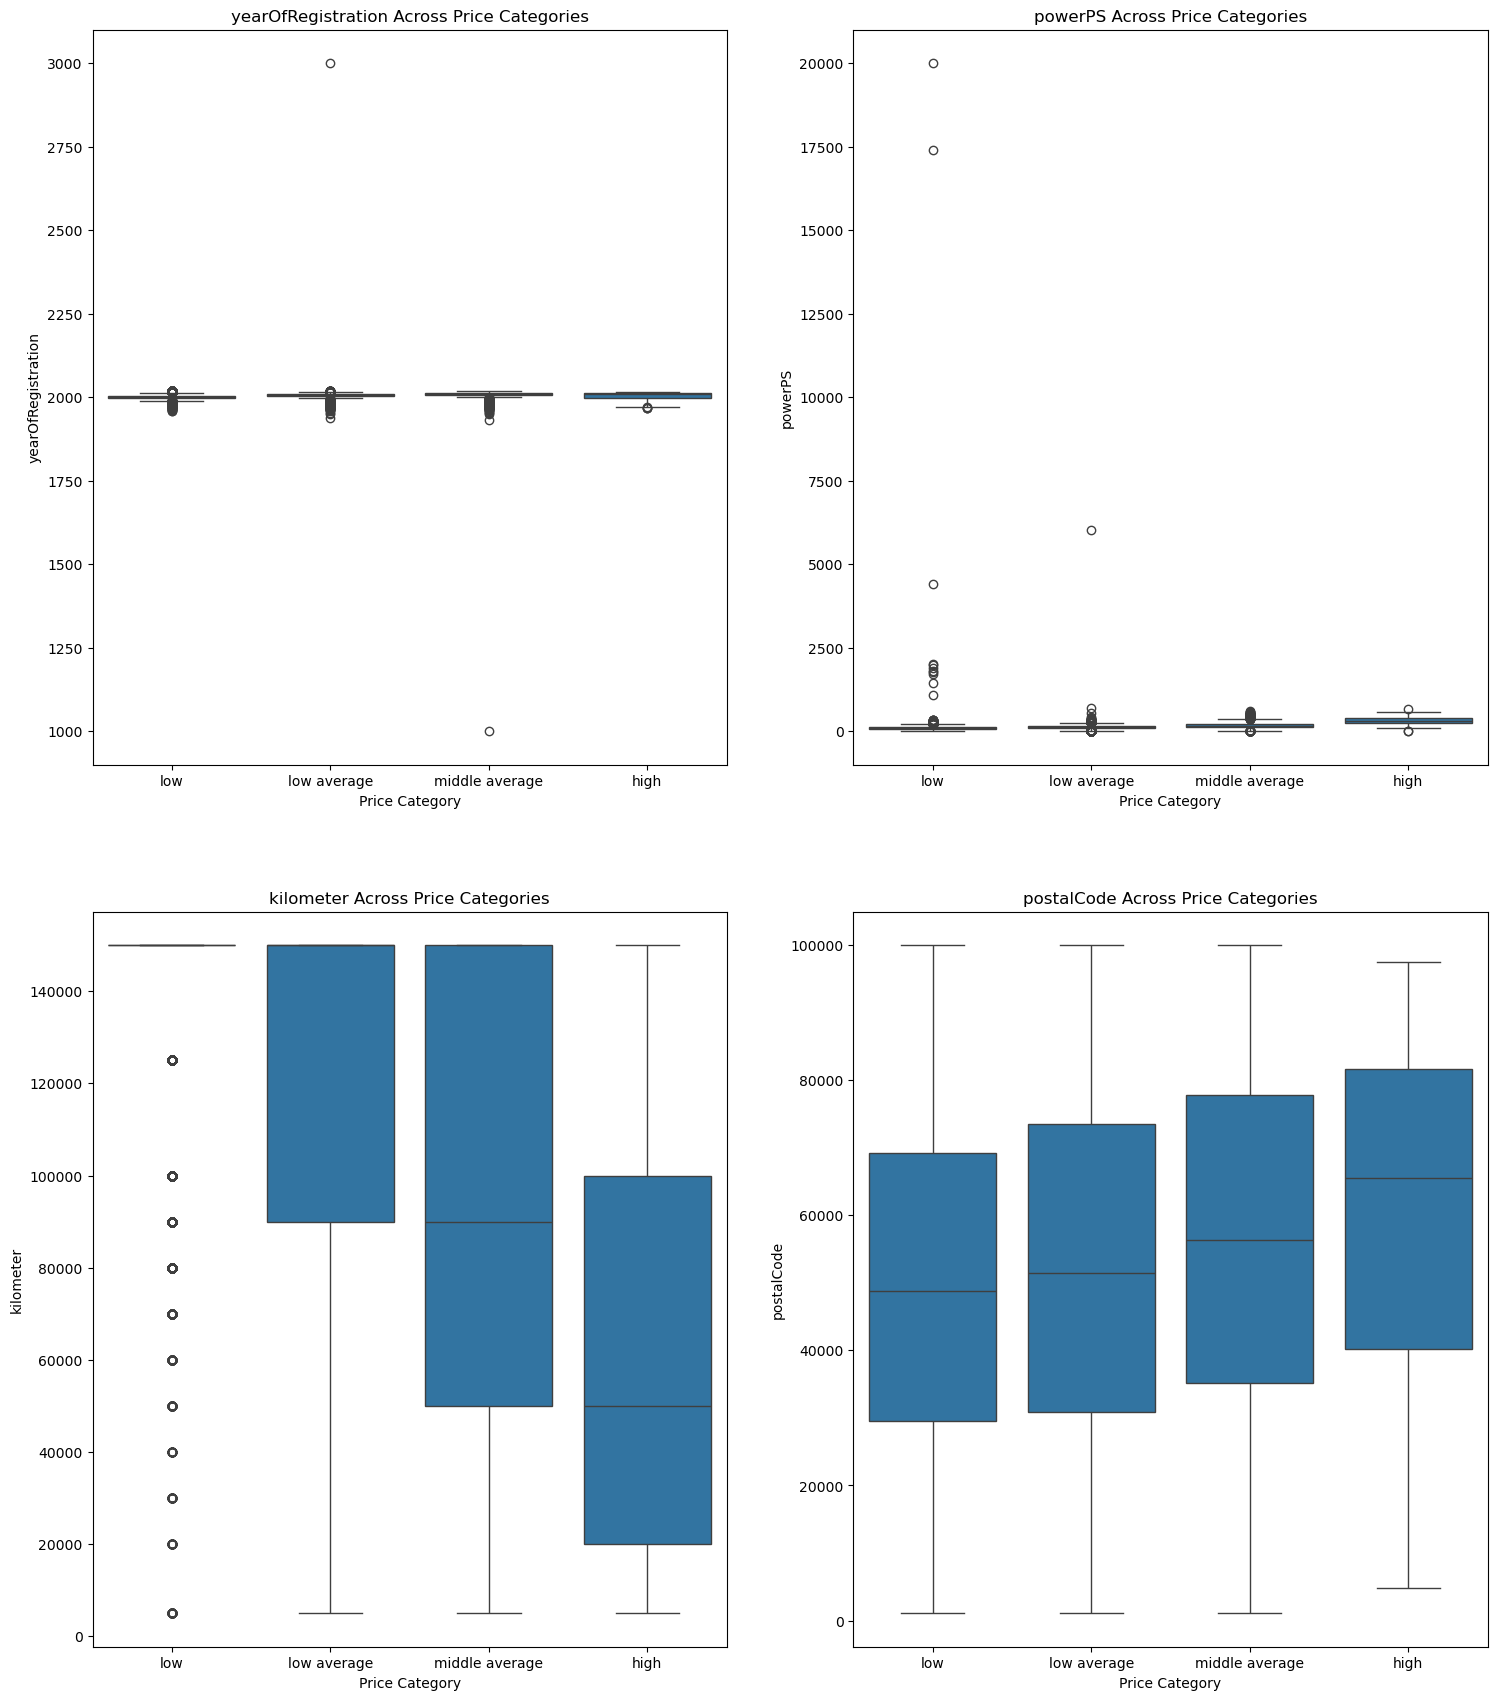

In [60]:
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
nrows,ncols = 2,2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in numerical_features:
    sns.boxplot(x='price_category', y=feature, data=bins_df, ax=axs[i,j])
    axs[i,j].set_title(f"{feature} Across Price Categories")
    axs[i,j].set_xlabel("Price Category")
    axs[i,j].set_ylabel(feature)
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

* the correlation of kilometer to price makes a lot of sense
* we're not sure whether postalCode playes a role, or whether this is random

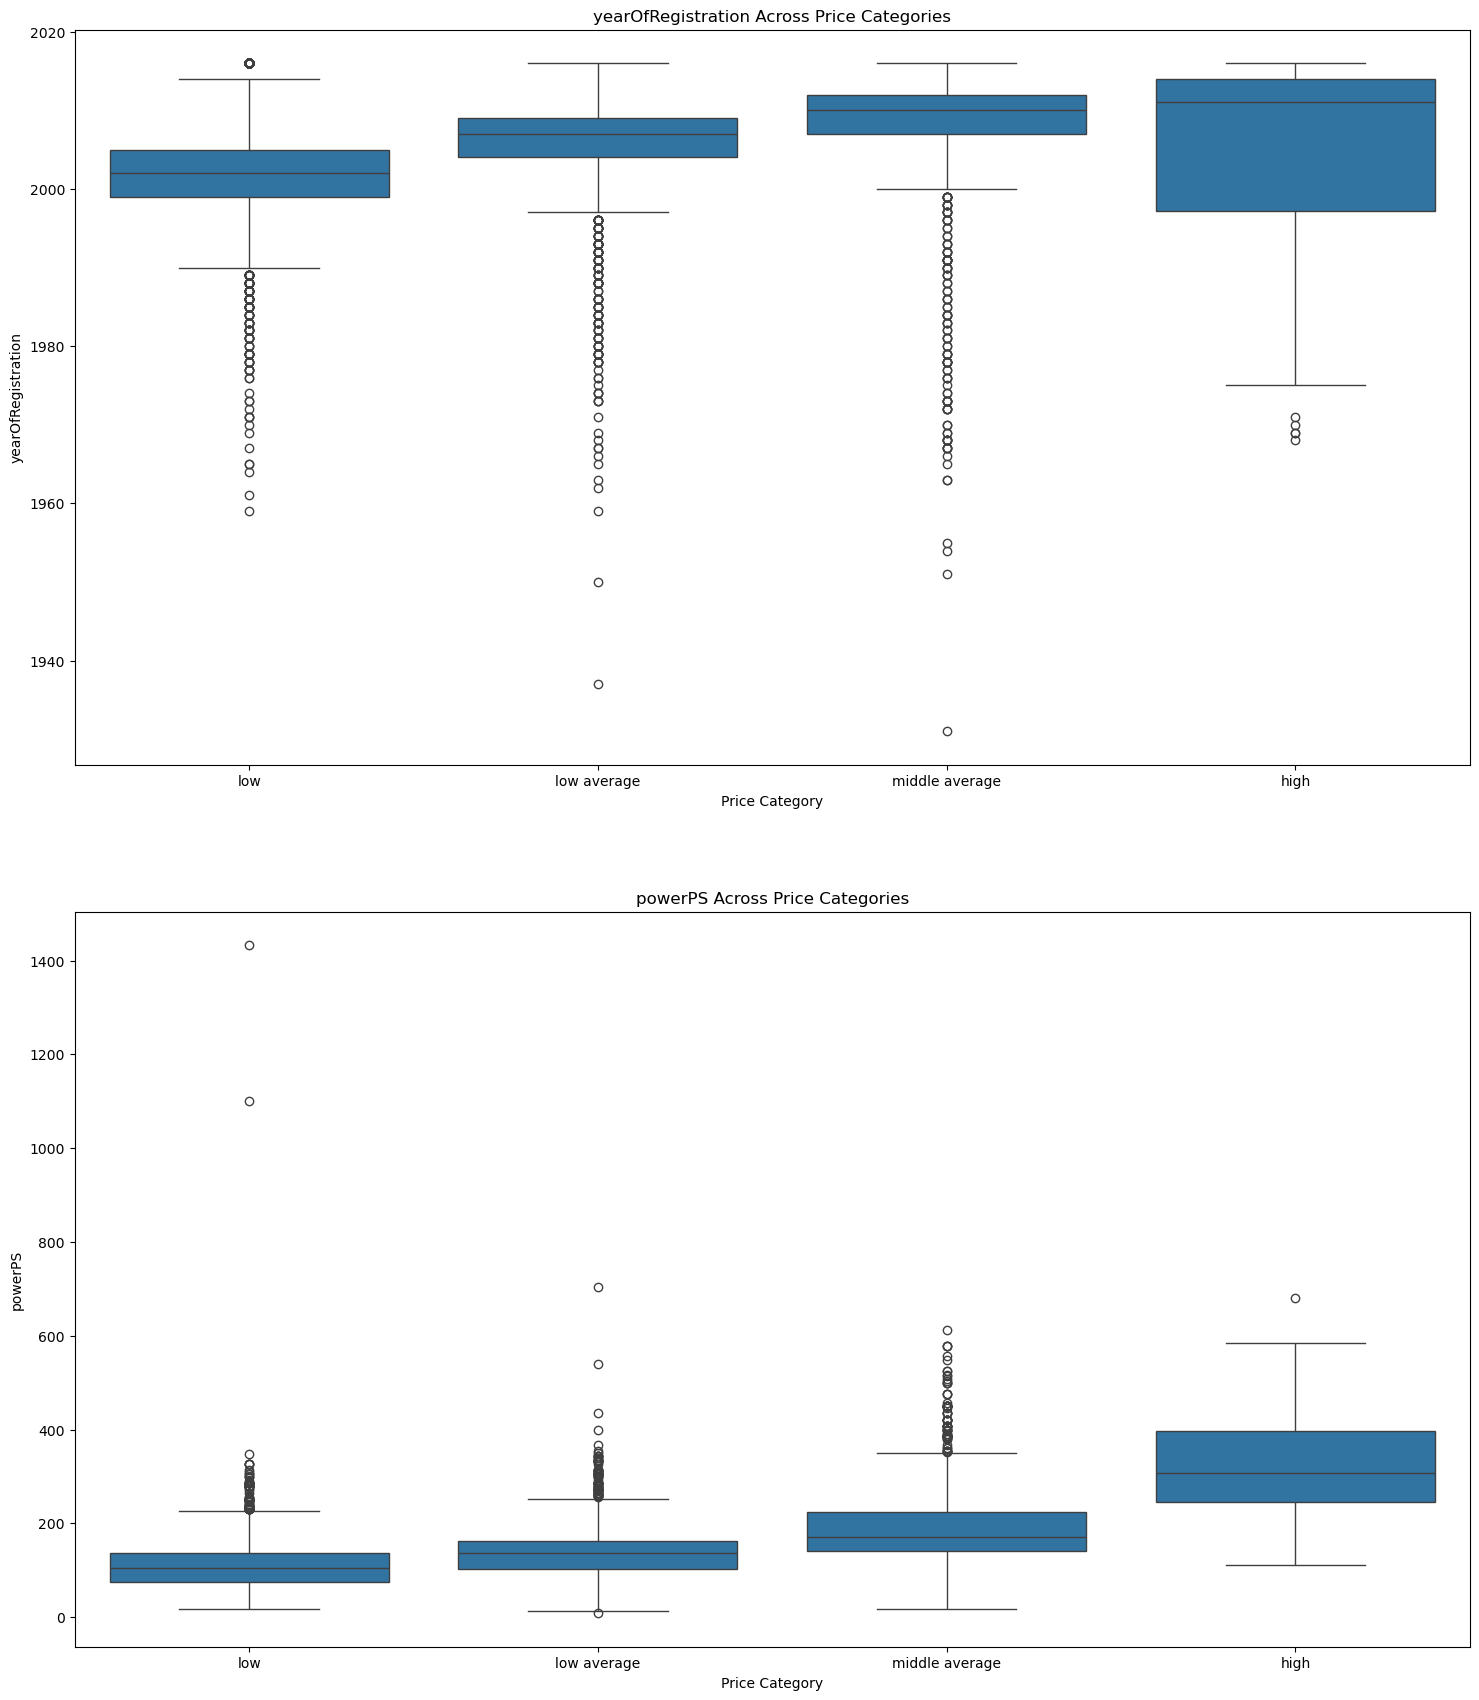

In [61]:
df_tmp = bins_df.copy()
df_tmp = df_tmp[(df_tmp['yearOfRegistration'] >= 1920) & (df_tmp['yearOfRegistration'] <= 2016)]
df_tmp = df_tmp[(df_tmp['powerPS'] <= 1500) & (df_tmp['powerPS'] >= 4.5)]

numerical_features = ['yearOfRegistration', 'powerPS']
nrows,ncols = 2,1
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i = 0
for feature in numerical_features:
    sns.boxplot(x='price_category', y=feature, data=df_tmp, ax=axs[i])
    axs[i].set_title(f"{feature} Across Price Categories")
    axs[i].set_xlabel("Price Category")
    axs[i].set_ylabel(feature)
    i = i + 1

* both graphs make appear logical

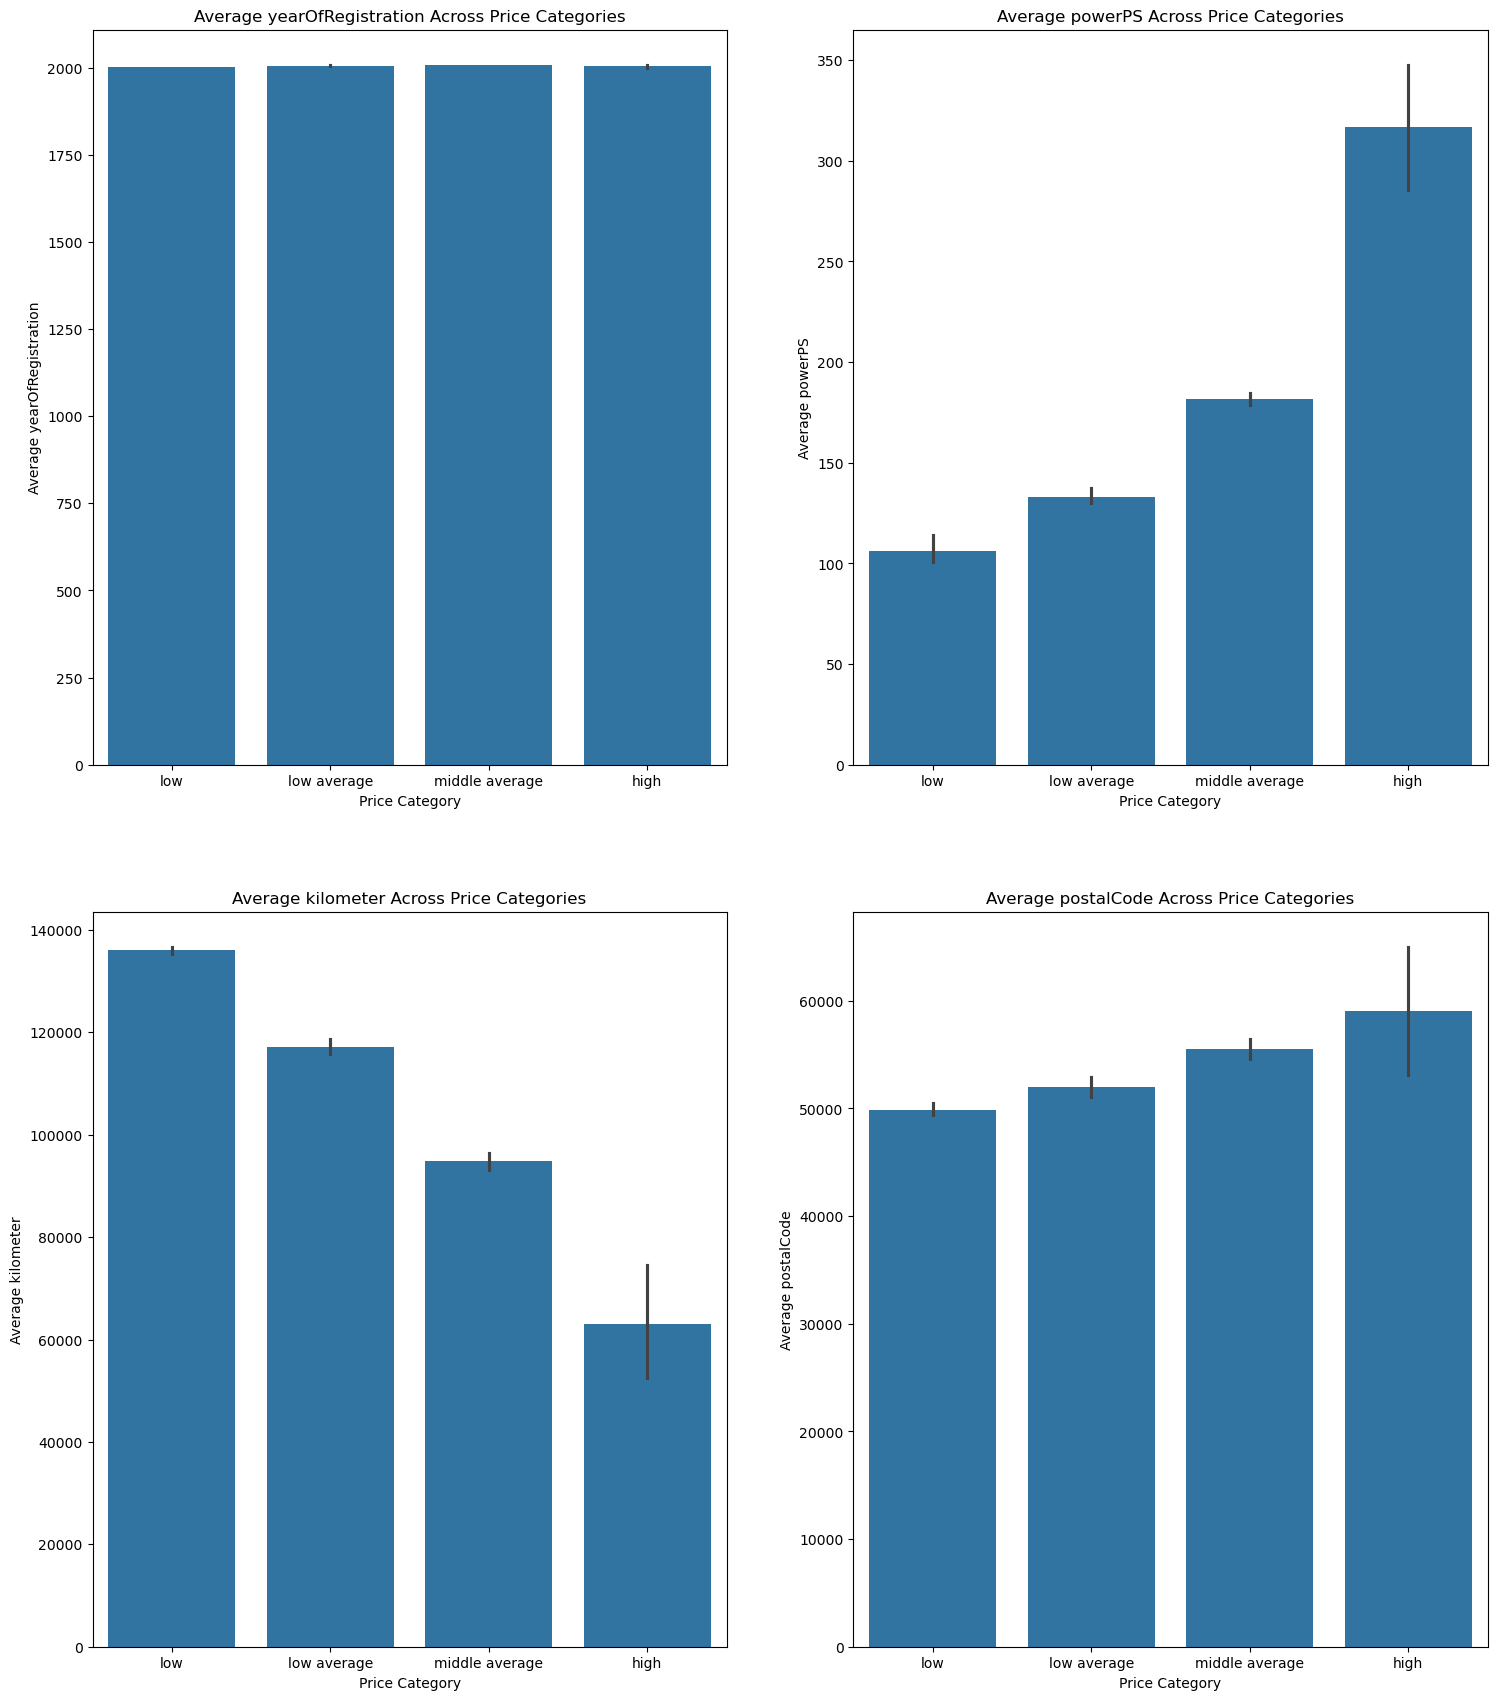

In [62]:
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
nrows,ncols = 2,2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in numerical_features:
    sns.barplot(x='price_category', y=feature, data=bins_df, ax=axs[i,j])
    axs[i,j].set_title(f"Average {feature} Across Price Categories")
    axs[i,j].set_xlabel("Price Category")
    axs[i,j].set_ylabel("Average "+feature)
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

* here we simply confirm what we saw before

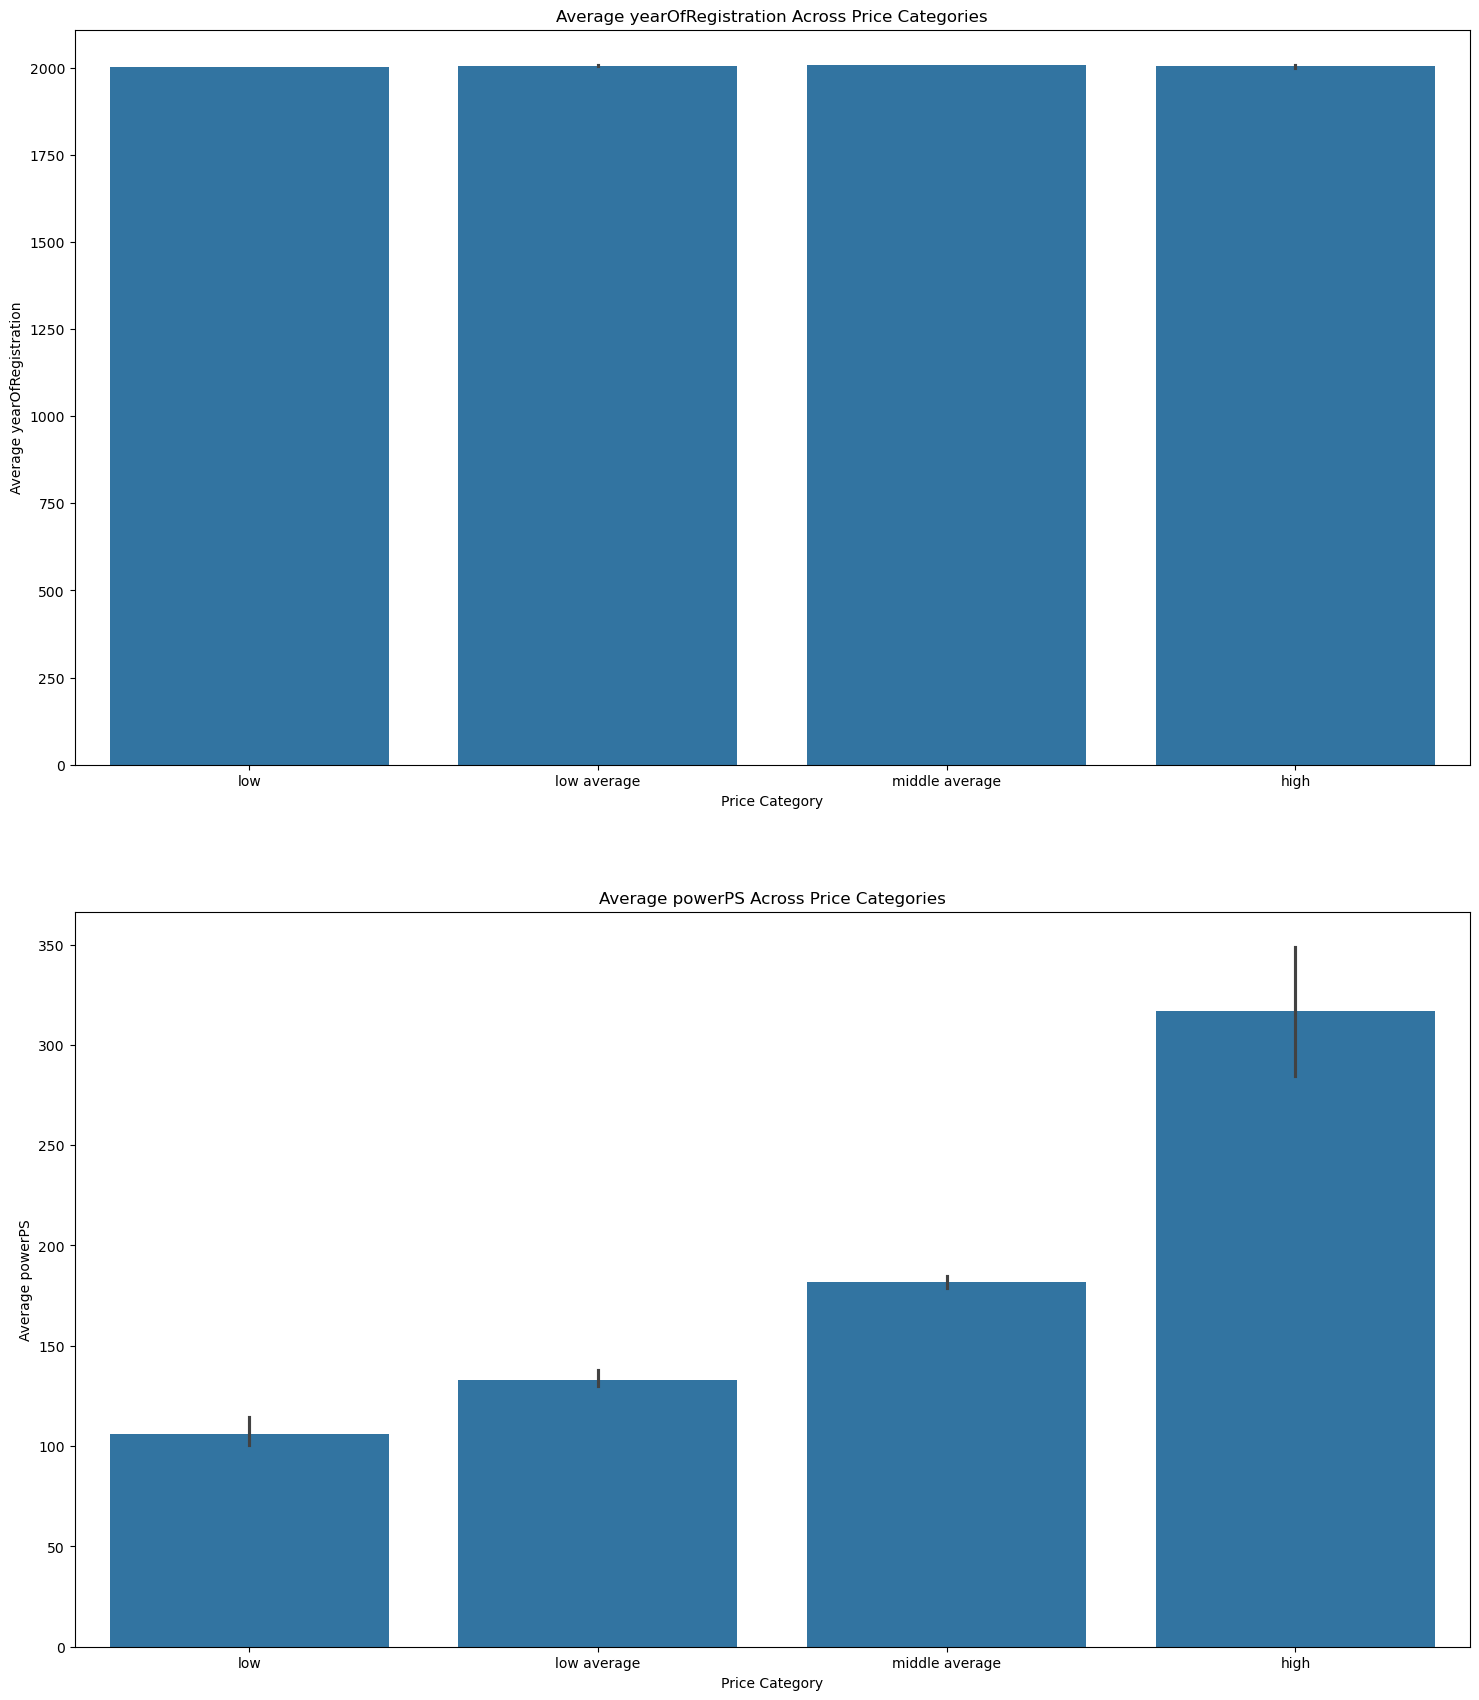

In [63]:
df_tmp = bins_df.copy()
df_tmp = df_tmp[(df_tmp['yearOfRegistration'] >= 1920) & (df_tmp['yearOfRegistration'] <= 2016)]
df_tmp = df_tmp[(df_tmp['powerPS'] <= 1500) & (df_tmp['powerPS'] >= 4.5)]

numerical_features = ['yearOfRegistration', 'powerPS']
nrows,ncols = 2,1
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i = 0
for feature in numerical_features:
    sns.barplot(x='price_category', y=feature, data=bins_df, ax=axs[i])
    axs[i].set_title(f"Average {feature} Across Price Categories")
    axs[i].set_xlabel("Price Category")
    axs[i].set_ylabel("Average "+feature)
    i = i + 1

* again, here we simply confirm what we saw before

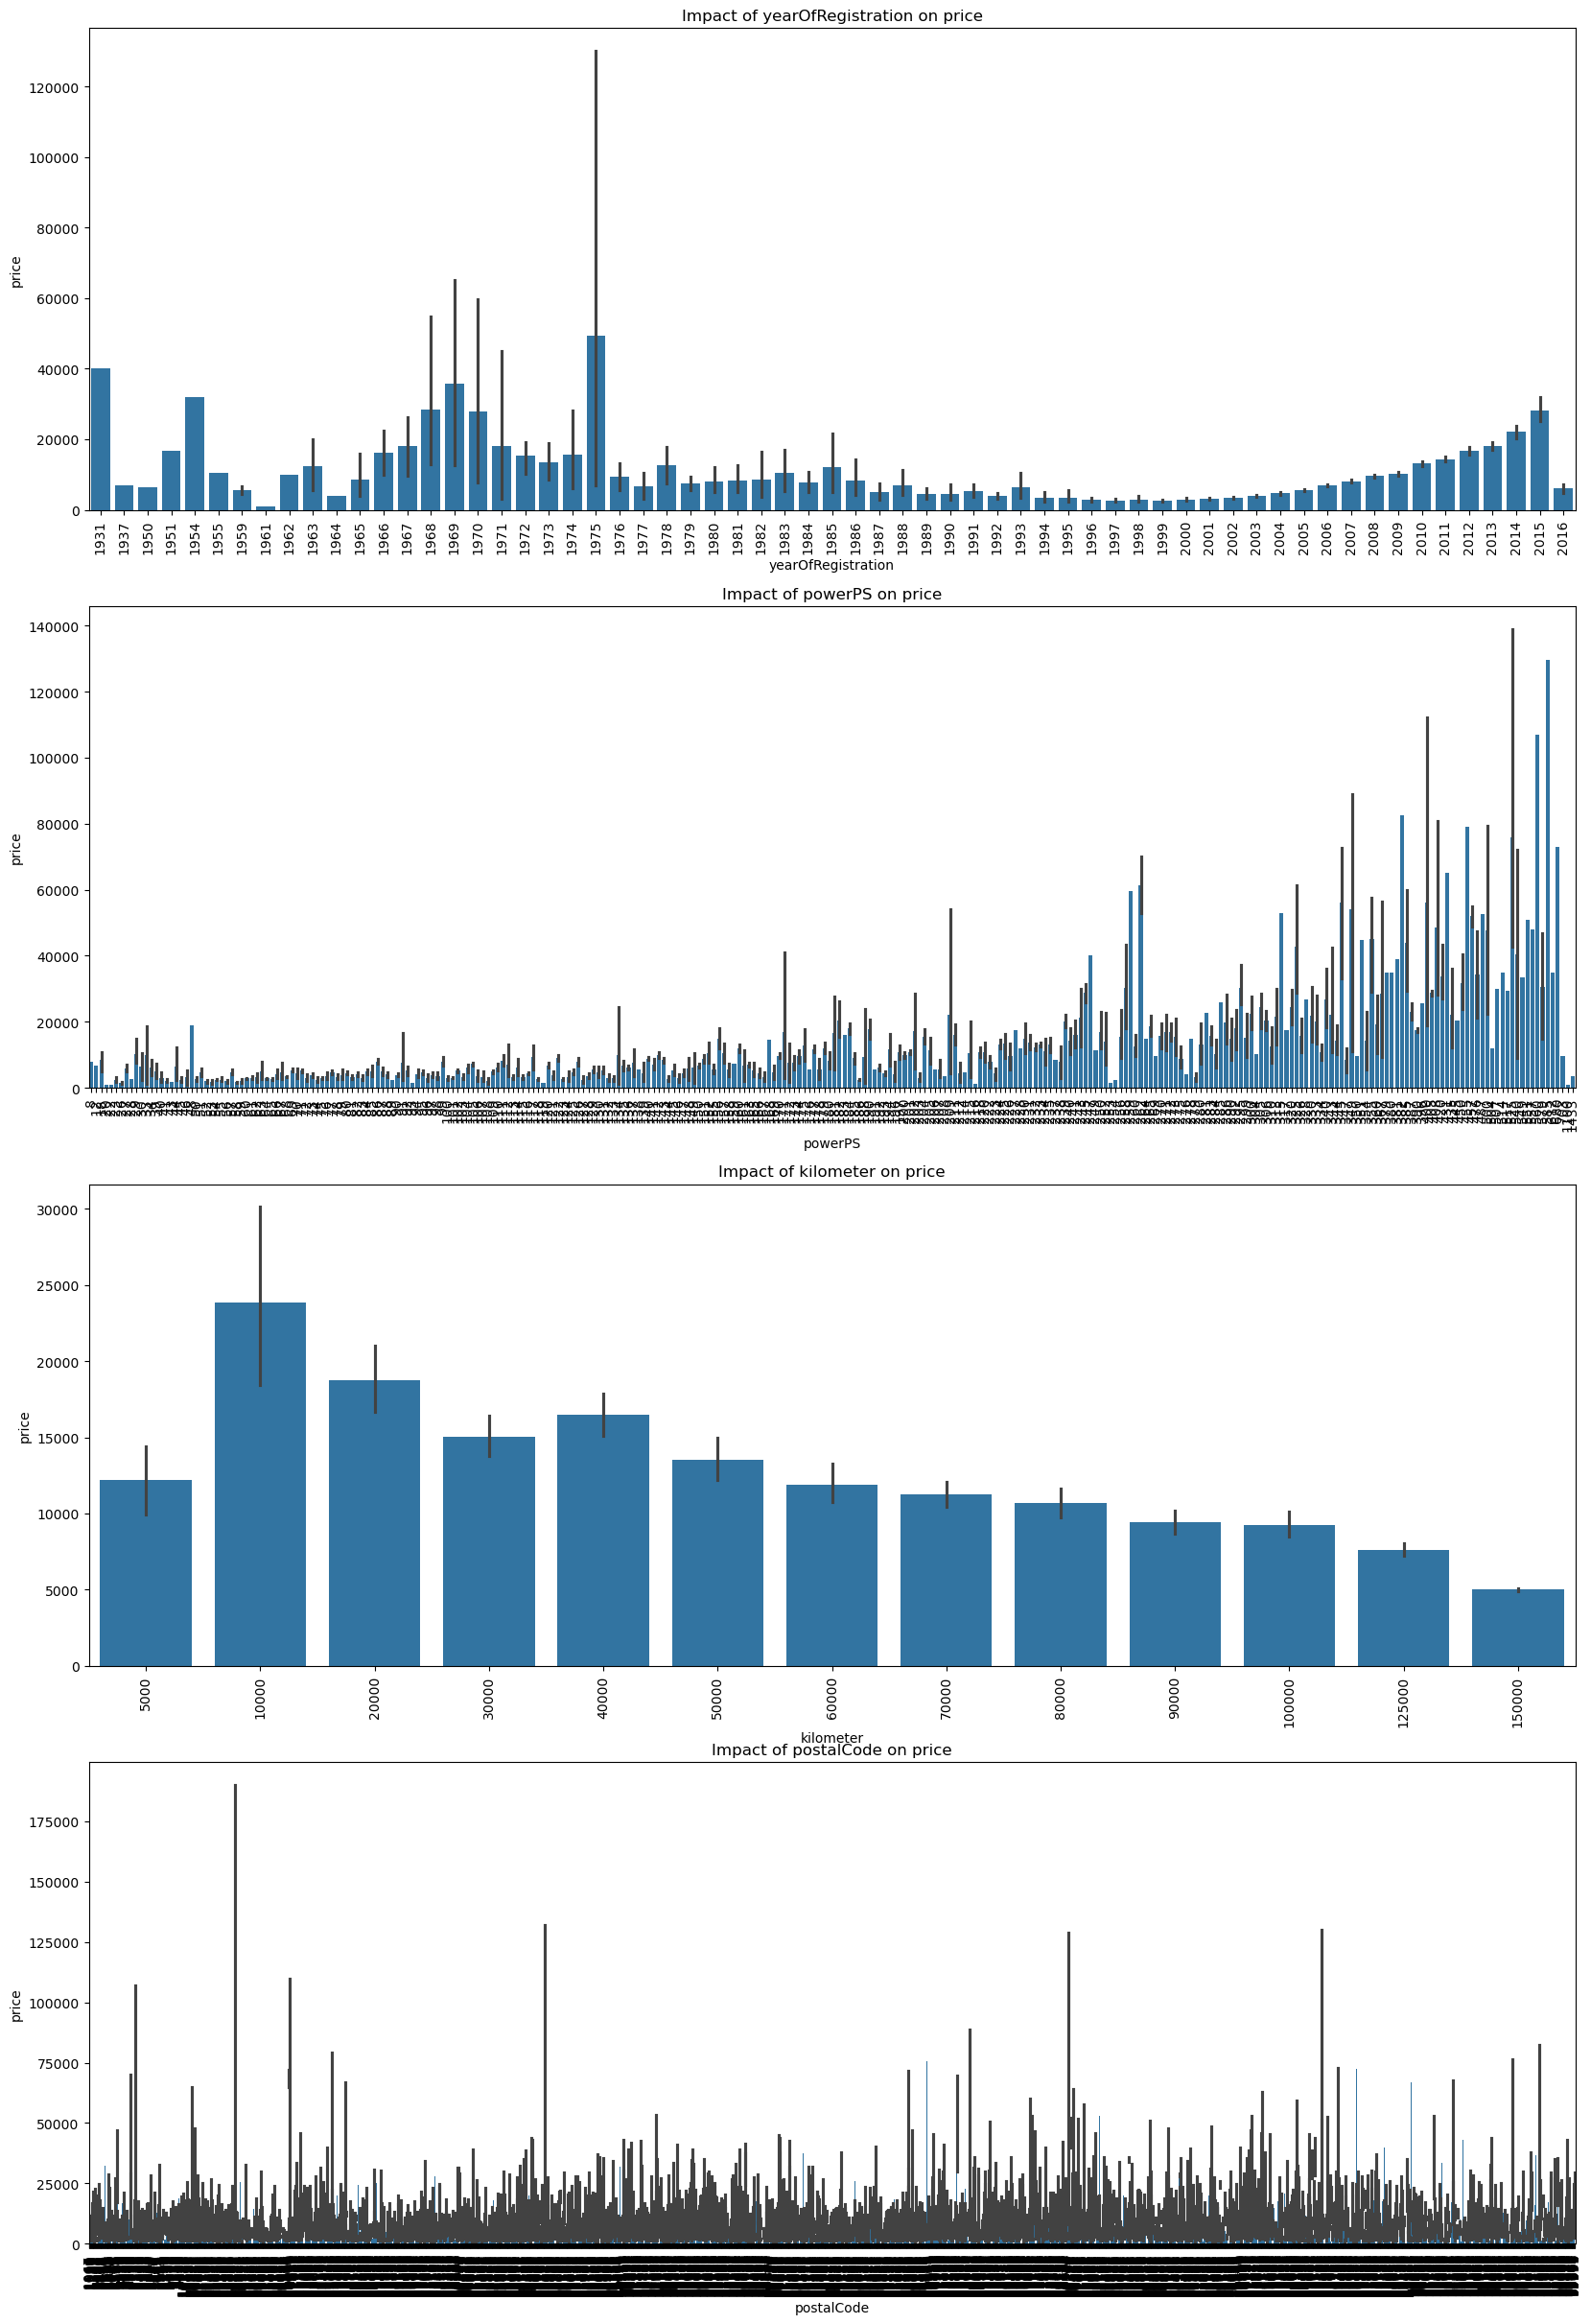

In [64]:
df_tmp = df.copy()
df_tmp = df_tmp[(df_tmp['yearOfRegistration'] >= 1920) & (df_tmp['yearOfRegistration'] <= 2016)]
df_tmp = df_tmp[(df_tmp['powerPS'] <= 1500) & (df_tmp['powerPS'] >= 4.5)]

numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
nrows,ncols = 4,1
fig, axs = plt.subplots(nrows, ncols, figsize=(20,30))
i = 0
for feature in numerical_features:
    sns.barplot(x=feature, y='price', data=df_tmp, ax=axs[i])
    axs[i].set_title(f"Impact of {feature} on price")
    axs[i].tick_params(axis='x', rotation=90)
    i = i + 1

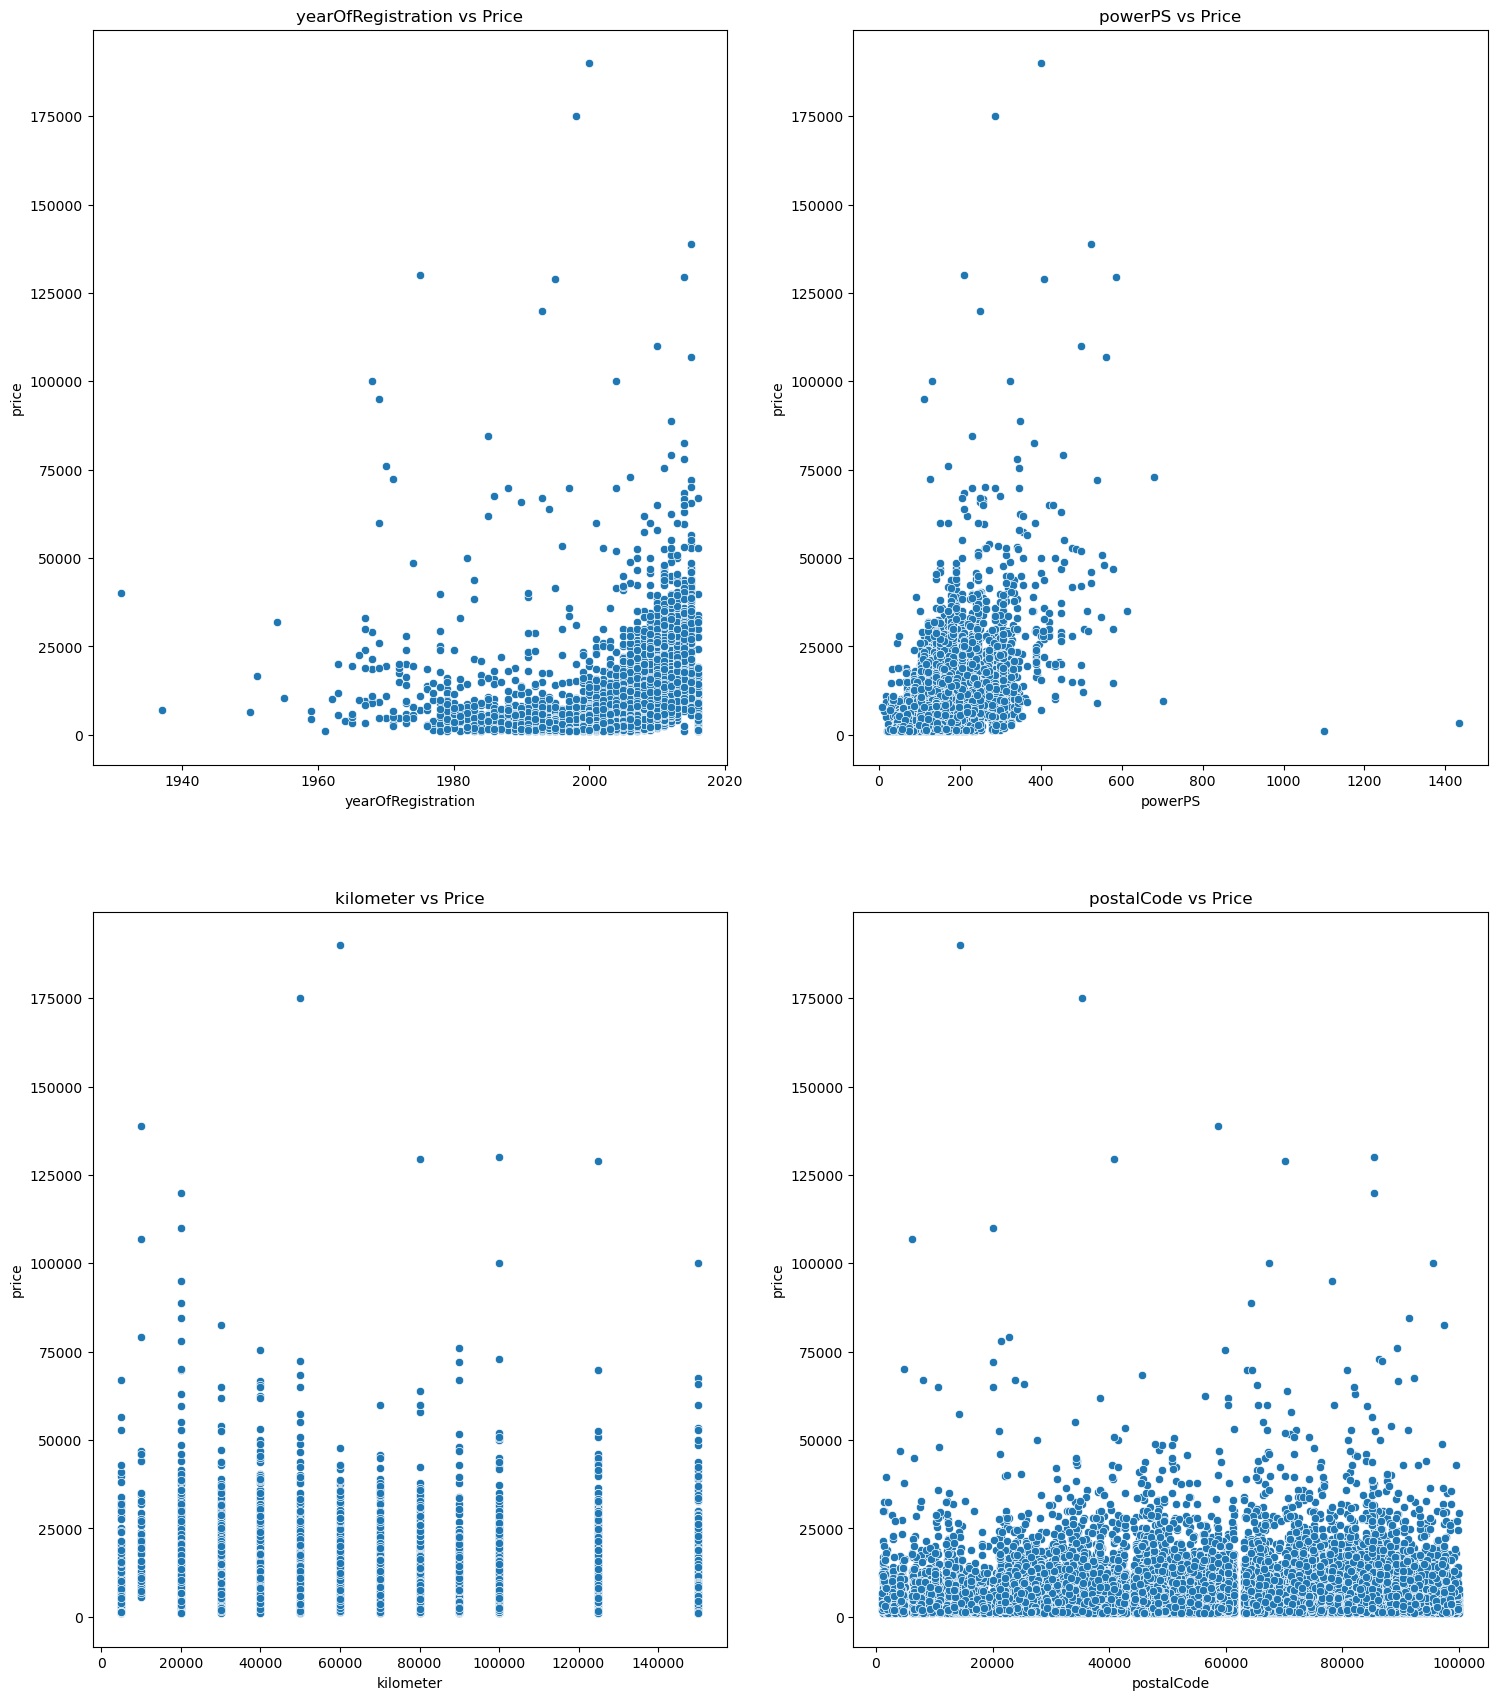

In [65]:
df_tmp = df.copy()
df_tmp = df_tmp[(df_tmp['yearOfRegistration'] >= 1920) & (df_tmp['yearOfRegistration'] <= 2016)]
df_tmp = df_tmp[(df_tmp['powerPS'] <= 1500) & (df_tmp['powerPS'] >= 4.5)]

numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer', 'postalCode']
nrows,ncols = 2,2
fig, axs = plt.subplots(nrows, ncols, figsize=(18,21))
i,j = 0,0
for feature in numerical_features:
    sns.scatterplot(x=feature, y='price', data=df_tmp, ax=axs[i,j])
    axs[i,j].set_title(f"{feature} vs Price")
    j = j + 1
    if j % ncols == 0:
        i = i + 1
        j = 0

Text(0.5, 1.0, 'Correlation Matrix')

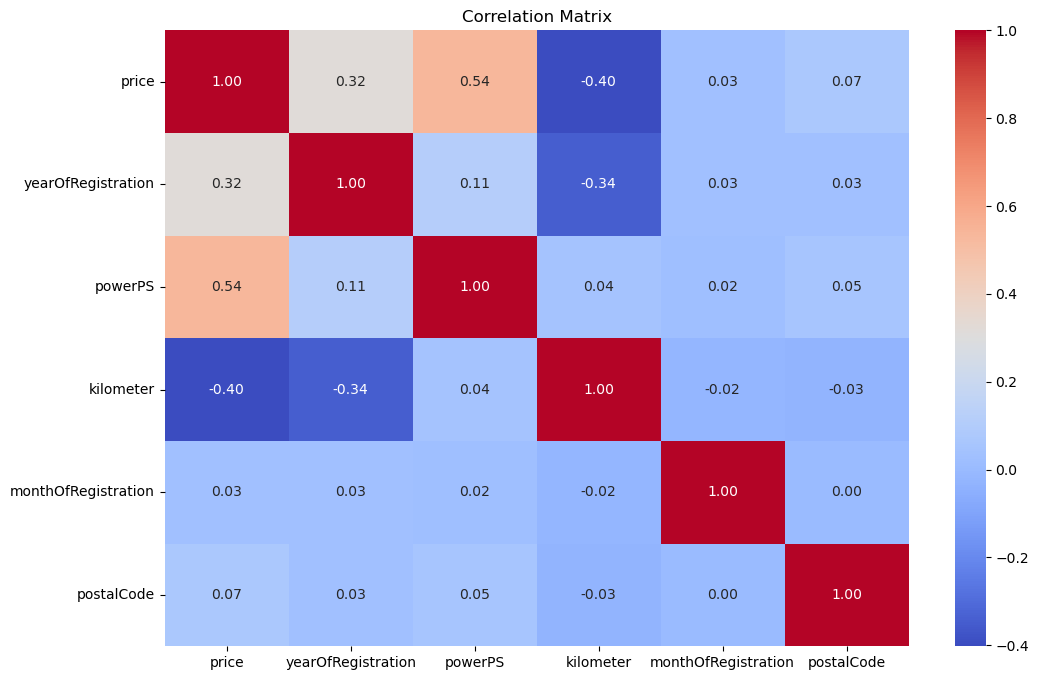

In [66]:
df_tmp = df.copy()
df_tmp = df_tmp[(df_tmp['yearOfRegistration'] >= 1920) & (df_tmp['yearOfRegistration'] <= 2016)]
df_tmp = df_tmp[(df_tmp['powerPS'] <= 1500) & (df_tmp['powerPS'] >= 4.5)]

corr_matrix = df_tmp.corr(numeric_only=True)
fig,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
ax.set_title("Correlation Matrix")

### Moderate correlation:
* yearOfRegistration has some negative correlation with kilometer. This appears logical
* price has moderate correlation both with kilometer and powerPS. This, again, appears logical

### No correlation:
* the rest of the numerical features appear to have very little to zero correlation

In [67]:
# don't delete them for now
#df.drop(columns=['monthOfRegistration', 'postalCode'], inplace=True)

In [68]:
df.drop(columns=['abtest'], inplace=True)

In [69]:
df.head()

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
348986,2016-03-25 19:57:53,10000,coupe,1992,manuell,0,calibra,150000,10,benzin,opel,nein,2016-03-25 00:00:00,94269,2016-04-05 00:17:25
32810,2016-03-24 12:57:58,3398,limousine,2003,manuell,102,a3,150000,3,benzin,audi,nein,2016-03-24 00:00:00,36043,2016-04-07 04:45:42
342339,2016-03-29 08:55:03,1400,limousine,1996,manuell,0,c_klasse,150000,6,benzin,mercedes_benz,NaN,2016-03-29 00:00:00,38162,2016-04-05 18:18:29
206349,2016-03-12 18:53:47,6900,kleinwagen,2006,manuell,80,polo,70000,7,benzin,volkswagen,nein,2016-03-12 00:00:00,22941,2016-03-16 00:47:02
337351,2016-03-08 14:48:42,1600,kombi,1992,automatik,131,andere,150000,3,benzin,volvo,nein,2016-03-08 00:00:00,28844,2016-03-08 14:48:42


# split dataset

In [70]:
# delete erroneous values, in order to later treat them as missing values
print("BEFORE")
print("yearOfRegistation")
print(df[(df["yearOfRegistration"] < 1920) | (df["yearOfRegistration"] > 2016)].count())
print("="*30)
print("powerPS")
print(df[(df["powerPS"] > 1500) | (df["powerPS"] < 4.5)].count())
print("="*30)
print("monthOfRegistration")
print(df[(df["monthOfRegistration"] == 0)].count())
print("="*30)

df.loc[(df["yearOfRegistration"] < 1920) | (df["yearOfRegistration"] > 2016), "yearOfRegistration"] = np.nan
df.loc[(df["powerPS"] > 1500) | (df["powerPS"] < 4.5), "powerPS"] = np.nan
df.loc[(df["monthOfRegistration"] == 0), "monthOfRegistration"] = np.nan

print("AFTER")
print(df[(df["yearOfRegistration"] < 1920) | (df["yearOfRegistration"] > 2016)].count())
print("yearOfRegistation")
print("="*30)
print(df[(df["powerPS"] > 1500) | (df["powerPS"] < 4.5)].count())
print("powerPS")
print("="*30)
print("monthOfRegistration")
print(df[(df["monthOfRegistration"] == 0)].count())

BEFORE
yearOfRegistation
dateCrawled            505
price                  505
vehicleType              1
yearOfRegistration     505
gearbox                452
powerPS                505
model                  505
kilometer              505
monthOfRegistration    505
fuelType               321
brand                  505
notRepairedDamage      302
dateCreated            505
postalCode             505
lastSeen               505
dtype: int64
powerPS
dateCrawled            1007
price                  1007
vehicleType             726
yearOfRegistration     1007
gearbox                 720
powerPS                1007
model                  1007
kilometer              1007
monthOfRegistration    1007
fuelType                811
brand                  1007
notRepairedDamage       546
dateCreated            1007
postalCode             1007
lastSeen               1007
dtype: int64
monthOfRegistration
dateCrawled            819
price                  819
vehicleType            541
yearOfRegistrat

In [71]:
# combine some of the categories of fuelType
print(df["fuelType"].value_counts())
print("="*23)
df["fuelType"] = df["fuelType"].replace({"lpg": "andere", "cng": "andere"})
print(df["fuelType"].value_counts())

fuelType
benzin     8069
diesel     5005
lpg         219
cng          37
hybrid       12
andere        7
elektro       4
Name: count, dtype: int64
fuelType
benzin     8069
diesel     5005
andere      263
hybrid       12
elektro       4
Name: count, dtype: int64


In [72]:
# new columns added
df["adLifespan"] = (pd.to_datetime(df["lastSeen"]) - pd.to_datetime(df["dateCrawled"])).dt.days
#df["carAge"] = pd.to_datetime(pd.to_datetime(df["dateCreated"]).dt.year - df["yearOfRegistration"]).dt.days

# First, construct full registration date using year and month of registration
df['registrationDate'] = pd.to_datetime(dict(year=df['yearOfRegistration'], month=df['monthOfRegistration'], day=1), errors='coerce')
# Convert 'dateCreated' to datetime
df['dateCreated'] = pd.to_datetime(df['dateCreated'], errors='coerce')
# Calculate age in days
df['carAge'] = (df['dateCreated'] - df['registrationDate']).dt.days

df.loc[(df["carAge"] < 0), "carAge"] = np.nan
df.loc[df['carAge'] == 0, 'carAge'] = 1

df.drop(columns=['registrationDate', 'dateCrawled', 'dateCreated', 'lastSeen'], inplace=True)
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,adLifespan,carAge
348986,10000,coupe,1992.0,manuell,NaN,calibra,150000,10.0,benzin,opel,nein,94269,10,8576.0
32810,3398,limousine,2003.0,manuell,102.0,a3,150000,3.0,benzin,audi,nein,36043,13,4772.0
342339,1400,limousine,1996.0,manuell,NaN,c_klasse,150000,6.0,benzin,mercedes_benz,NaN,38162,7,7241.0
206349,6900,kleinwagen,2006.0,manuell,80.0,polo,70000,7.0,benzin,volkswagen,nein,22941,3,3542.0
337351,1600,kombi,1992.0,automatik,131.0,andere,150000,3.0,benzin,volvo,nein,28844,0,8773.0


In [73]:
print(f"adLifespan skewness:", df['adLifespan'].skew())
print("="*50)

print(f"\nNormality tests for adLifespan\n" + "="*50)
results = run_normality_tests(df['adLifespan'])
for test, result in results.items():
    print(f"{test}: {result}")

adLifespan skewness: 0.9501968160384009

Normality tests for adLifespan
Anderson-Darling Test: {'Statistic': 563.4379451261684, 'Critical Values': array([0.576, 0.656, 0.787, 0.918, 1.092]), 'Significance Levels': array([15. , 10. ,  5. ,  2.5,  1. ]), 'Normal': False}
Kolmogorov-Smirnov Test: {'Statistic': 0.15425646078688132, 'p-value': 3.4188277011491727e-295, 'Normal': False}
D’Agostino and Pearson’s Test: {'Statistic': 1561.9836141334058, 'p-value': 0.0, 'Normal': False}
Jarque-Bera Test: {'Statistic': 2140.6957093754218, 'p-value': 0.0, 'Normal': False}
Lilliefors Test: {'Statistic': 0.1542509622768417, 'p-value': 0.0009999999999998899, 'Normal': False}


Text(0.5, 1.0, 'Correlation Matrix')

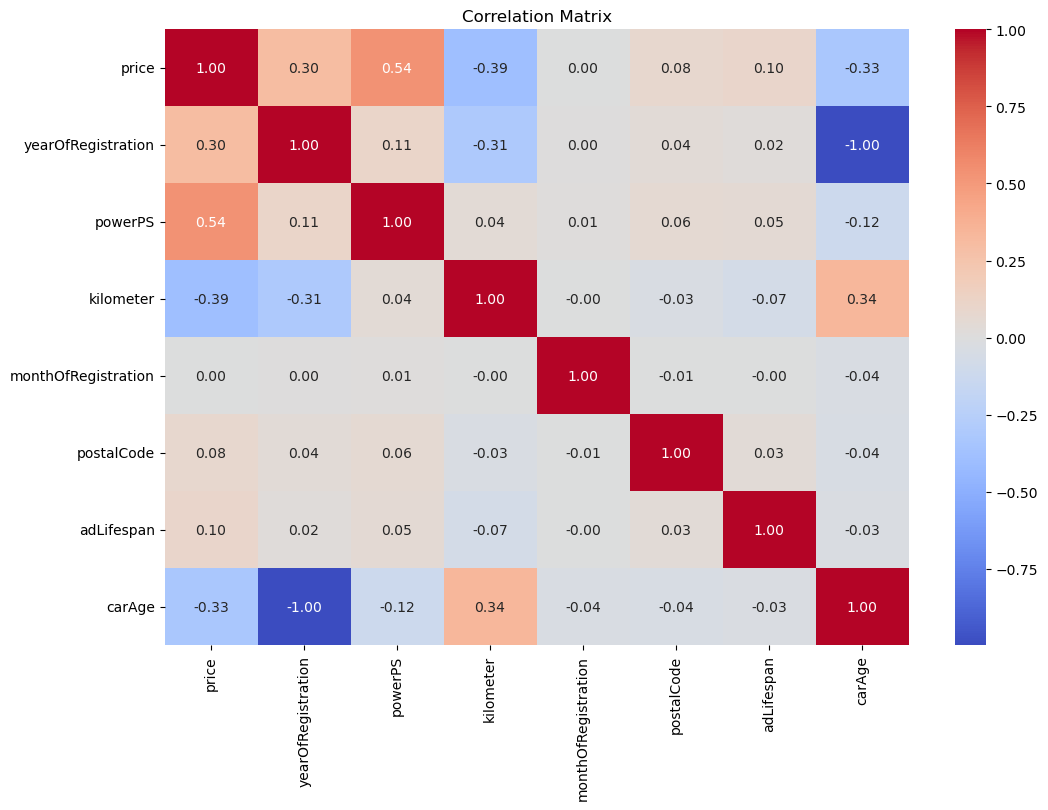

In [74]:
corr_matrix = df.corr(numeric_only=True)
fig,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
ax.set_title("Correlation Matrix")

#### now adLifespan and carAge are both in days

In [75]:
df.drop(columns=['yearOfRegistration'], inplace=True)
df.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,adLifespan,carAge
348986,10000,coupe,manuell,NaN,calibra,150000,10.0,benzin,opel,nein,94269,10,8576.0
32810,3398,limousine,manuell,102.0,a3,150000,3.0,benzin,audi,nein,36043,13,4772.0
342339,1400,limousine,manuell,NaN,c_klasse,150000,6.0,benzin,mercedes_benz,NaN,38162,7,7241.0
206349,6900,kleinwagen,manuell,80.0,polo,70000,7.0,benzin,volkswagen,nein,22941,3,3542.0
337351,1600,kombi,automatik,131.0,andere,150000,3.0,benzin,volvo,nein,28844,0,8773.0


In [76]:
df.shape

(14184, 13)

In [77]:
missing_values = df.isnull().sum()
print("Missing Values per Column:")
missing_values

Missing Values per Column:


price                     0
vehicleType             992
gearbox                 483
powerPS                1007
model                     0
kilometer                 0
monthOfRegistration     819
fuelType                831
brand                     0
notRepairedDamage      2024
postalCode                0
adLifespan                0
carAge                 1378
dtype: int64

In [78]:
X = df.drop(['price'], axis=1)
y = df['price']

In [79]:
X.head()

,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,adLifespan,carAge
348986,coupe,manuell,NaN,calibra,150000,10.0,benzin,opel,nein,94269,10,8576.0
32810,limousine,manuell,102.0,a3,150000,3.0,benzin,audi,nein,36043,13,4772.0
342339,limousine,manuell,NaN,c_klasse,150000,6.0,benzin,mercedes_benz,NaN,38162,7,7241.0
206349,kleinwagen,manuell,80.0,polo,70000,7.0,benzin,volkswagen,nein,22941,3,3542.0
337351,kombi,automatik,131.0,andere,150000,3.0,benzin,volvo,nein,28844,0,8773.0


In [80]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(11347, 12)
(11347,)


In [81]:
X_train.head()

,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,adLifespan,carAge
109992,coupe,automatik,NaN,andere,125000,2.0,benzin,mercedes_benz,nein,7554,7,7362.0
220704,limousine,manuell,163.0,3er,150000,7.0,diesel,bmw,nein,75050,30,3536.0
195331,bus,manuell,100.0,andere,150000,6.0,benzin,mitsubishi,nein,31840,0,5044.0
118710,cabrio,manuell,135.0,3_reihe,150000,NaN,benzin,peugeot,nein,53340,4,NaN
144306,NaN,manuell,140.0,tiguan,100000,2.0,diesel,volkswagen,NaN,34355,16,NaN


In [82]:
# Get rows with 'hybrid' or 'elektro' in X_train and y_train
mask = X_train["fuelType"].isin(["hybrid", "elektro"])
X_rare = X_train[mask]
y_rare = y_train[mask]

# Oversample 20x
X_oversampled = pd.concat([X_rare] * 20, ignore_index=True)
y_oversampled = pd.concat([y_rare] * 20, ignore_index=True)

# Combine with the original data
X_train_oversampled = pd.concat([X_train, X_oversampled], ignore_index=True)
y_train_oversampled = pd.concat([y_train, y_oversampled], ignore_index=True)

# Shuffle the data
shuffled_indices = np.random.RandomState(seed=42).permutation(len(X_train_oversampled))
X_train = X_train_oversampled.iloc[shuffled_indices].reset_index(drop=True)
y_train = y_train_oversampled.iloc[shuffled_indices].reset_index(drop=True)

# Confirm result
print(X_train["fuelType"].value_counts())
print(y_train.shape)
print("="*15)
print(X_train.shape)
print(y_train.shape)

fuelType
benzin     6458
diesel     4006
hybrid      210
andere      198
elektro      42
Name: count, dtype: int64
(11587,)
(11587, 12)
(11587,)


In [83]:
num_features = ['carAge', 'powerPS', 'kilometer', 'adLifespan']

transformer = RobustScaler().fit(X[num_features])
scaled_data = transformer.transform(X[num_features])
X_scaled = pd.DataFrame(scaled_data, columns=num_features)
X_scaled.std()

carAge        0.881195
powerPS       0.876029
kilometer     0.809459
adLifespan    0.700578
dtype: float64

In [84]:
# Apply PowerTransformer with bos-cox method on the target variable since all price values are positive
# later, apply methods all in cross validation
yj = PowerTransformer(method='box-cox')

# fit_transform() and transform() need 2D input data but y_train and Y_test are 1D Pandas Series. So, convert them to DataFrames with a single column.to_frame()
y_train_yj = yj.fit_transform(y_train.to_frame())  # Fit and transform training data
y_test_yj = yj.transform(y_test.to_frame())  # Transform test data

# Convert the results back to pandas Series with the original index
y_train_yj = pd.Series(y_train_yj.flatten(), index=y_train.index, name='y_train_yj')
y_test_yj = pd.Series(y_test_yj.flatten(), index=y_test.index, name='y_test_yj')

# Also apply scaling

# Approach A

#### *Dataset V1*
 1. Apply simple imputer with mean strategy on numerical features
 2. Apply simple imputer with most frequent strategy and label encoding on categorical features

In [137]:
X_train_V1 = X_train.copy()
X_test_V1 = X_test.copy()
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Apply simple imputer with mean strategy on numerical features
si1 = SimpleImputer(strategy='mean')
# fit (train) imputer on the training dataset
# apply imputation on both training and test datasets
X_train_V1[num_features] = si1.fit_transform(X_train_V1[num_features])
X_test_V1[num_features] = si1.transform(X_test_V1[num_features])

# Apply simple imputer with most_frequent strategy on categorical features
si2 = SimpleImputer(strategy='most_frequent')
X_train_V1[cat_features] = si2.fit_transform(X_train_V1[cat_features])
X_test_V1[cat_features] = si2.transform(X_test_V1[cat_features])

X_train_V1_not_encoded = X_train_V1.copy()
X_test_V1_not_encoded = X_test_V1.copy()
# Apply label encoding on categorical features
label_encoder =  OrdinalEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode unseen categories with -1
                                )
X_train_V1[cat_features] = label_encoder.fit_transform(X_train_V1[cat_features])
X_test_V1[cat_features] = label_encoder.transform(X_test_V1[cat_features])

# normalize row so it's norm equals 1.

#print(X_train_V1)
#print(X_test_V1)

#### Feature Selection

In [86]:
print(X_train_V1.shape)
print(y_train.shape)

(11587, 12)
(11587,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.7s finished

[2025-04-19 15:17:21] Features: 1/12 -- score: 0.3568170785903931[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.0s finished

[2025-04-19 15:17:22] Features: 2/12 -- score: 0.5650132596492767[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished

[2025-04-19 15:17:24] Features: 3/12 -- score: 0.704442971944809[Parallel(n_jobs=-1)]: Using backend L

best combination (ACC: 0.774): (1, 2, 3, 4, 7, 8, 11)

Selected feature names:
 Index(['gearbox', 'powerPS', 'model', 'kilometer', 'brand',
       'notRepairedDamage', 'carAge'],
      dtype='object')

Not selected feature names:
 {'vehicleType', 'postalCode', 'fuelType', 'monthOfRegistration', 'adLifespan'}

all subsets:
 {1: {'feature_idx': (2,), 'cv_scores': array([0.37518096, 0.35745257, 0.39182073, 0.33843052, 0.32746226,
       0.28473926, 0.39614439, 0.35700107, 0.37944341, 0.36049563]), 'avg_score': 0.3568170785903931, 'feature_names': ('powerPS',)}, 2: {'feature_idx': (2, 11), 'cv_scores': array([0.53945106, 0.6979503 , 0.60583735, 0.47528499, 0.49779719,
       0.58522725, 0.4324289 , 0.55771983, 0.69619143, 0.5622443 ]), 'avg_score': 0.5650132596492767, 'feature_names': ('powerPS', 'carAge')}, 3: {'feature_idx': (2, 3, 11), 'cv_scores': array([0.60924876, 0.78417951, 0.81422597, 0.56930196, 0.65736639,
       0.71251667, 0.72757638, 0.72828424, 0.75587022, 0.68585962]), 'avg


[2025-04-19 15:17:34] Features: 12/12 -- score: 0.7418597579002381

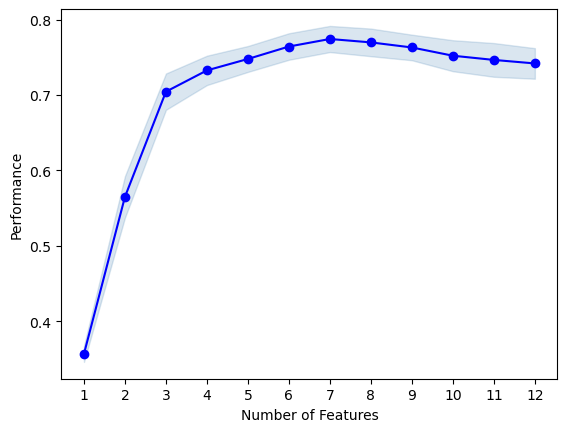

In [117]:
xgb = XGBRegressor()

# Sequential Forward Selection
sfs = SFS(xgb, 
           k_features=(5,X_train_V1.shape[1]),  
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=10,
           n_jobs=-1
         )
           
sfs = sfs.fit(X_train_V1, y_train)

selected_idx = list(sfs.k_feature_idx_)
selected_features = X_train_V1.columns[selected_idx]
all_features = set(X_train_V1.columns)
not_selected_features = all_features - set(selected_features)

V1_sfs_kfeature_idx_ = sfs.k_feature_idx_

print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
print('Selected feature names:\n', selected_features)
print('\nNot selected feature names:\n', not_selected_features)
print('\nall subsets:\n', sfs.subsets_)
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.show()

postalCode and monthOfRegistration, as expected are not included in best combination of features

## issues:
* this kills the kernel
* unable to run with large n_estimators, so results are useless
```
# Build an estimator (forest of trees) and compute the feature importances
estimator = ExtraTreesClassifier(n_estimators=5, max_features= X_train_V1.shape[1], random_state=0)
estimator.fit(X_train_V1,y_train)
# Lets get the feature importances.
# Features with high importance score higher.
importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

feat_names = X_train_V1.columns if hasattr(X_train_V1, 'columns') else [f'feature_{i}' for i in range(X_train_V1.shape[1])]
feat_df = pd.DataFrame({
    'Feature': [feat_names[i] for i in indices],
    'Importance': importances[indices],
    'STD': std[indices],
})

# Print feature ranking
print("Feature ranking:")
for idx, row in feat_df.iterrows():
    print(f"{idx + 1}. {row['Feature']} ({row['Importance']:.6f})")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), feat_df["Importance"], yerr=feat_df["STD"], color='red', align='center')
plt.xticks(range(len(importances)), feat_df["Feature"], rotation=45, ha='right')
plt.title("Feature importances", fontsize=16)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
```

- Since PCA is suitable for continuous numerical features, we cannot use it on our dataset.
This is not really an issue, since we do not have many features in the first place


- Since SVD works best for sparce metrics, is not useful for our dataset.

#### *Dataset V2 (the "best performing" selected features from V1)*

1. Apply simple imputer with mean strategy on numerical features
2. Apply simple imputer with most frequent strategy and label encoding on categorical features
3. Sequential feature selection

In [88]:
X_train_V2 = X_train_V1.iloc[:, list(sfs.k_feature_idx_)].copy()
X_test_V2 = X_test_V1.iloc[:, list(sfs.k_feature_idx_)].copy()

normalizer = Normalizer(norm='l2')
X_train_V2_array = normalizer.fit_transform(X_train_V2)
X_test_V2_array = normalizer.transform(X_test_V2)

X_train_V2 = pd.DataFrame(X_train_V2_array, columns=X_train_V1.columns[list(sfs.k_feature_idx_)], index=X_train_V1.index)
X_test_V2 = pd.DataFrame(X_test_V2_array, columns=X_test_V1.columns[list(sfs.k_feature_idx_)], index=X_test_V1.index)

X_train_V2.head()

,gearbox,powerPS,model,kilometer,brand,notRepairedDamage,carAge
0,0.000008,0.001032,0.000008,0.999590,0.000008,0.000008,0.028628
1,0.000007,0.000773,0.000013,0.999297,0.000013,0.000013,0.037474
2,0.000007,0.001000,0.000020,0.999603,0.000007,0.000013,0.028174
3,0.000007,0.000933,0.000027,0.999683,0.000020,0.000013,0.025145
4,0.000010,0.000879,0.000050,0.999403,0.000040,0.000020,0.034549


#### *Dataset V3 (the same as V1 but with unskewing on kilometer, carAge and powerPS)*
1. Apply simple imputer with mean strategy on numerical features
2. Apply Box Cox (unskewing) on kilometer, carAge and powerPS
3. Apply simple imputer with most frequent strategy and label encoding on categorical features

In [89]:
X_train_V3 = X_train_V1.copy()
X_test_V3 = X_test_V1.copy()

# applying unskewing techniques
unskew_features = ['kilometer', 'carAge', 'powerPS']
pt = PowerTransformer(method='box-cox')
X_train_V3[unskew_features] = pt.fit_transform(X_train_V3[unskew_features])
X_test_V3[unskew_features] = pt.transform(X_test_V3[unskew_features])

In [90]:
print(X_train_V3['notRepairedDamage'].isnull().sum())
print(X_train_V3['notRepairedDamage'].unique()) 

0
[1 2]


#### *Dataset V4* (the same as V3 but one hot on categorical)
1. Apply simple imputer with mean strategy on numerical features
2. Apply Box Cox (unskewing) on kilometer, carAge and powerPS
3. Apply simple imputer with most frequent strategy and one hot encoding on categorical features

In [91]:
X_train_V4 = X_train_V3.copy()
X_test_V4 = X_test_V3.copy()

onehot_cat_features = ['vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']

# Apply ordinal encoding on categorical features
onehot_encoder = OneHotEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode a new value as 0 in every dummy column
                                )
#new_cols_train = onehot_encoder.fit_transform(X_train[onehot_cat_features])
new_cols_train = onehot_encoder.fit_transform(X_train_V1_not_encoded[onehot_cat_features])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V4 = pd.concat([X_train_V4, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V4 = X_train_V4.drop(columns=onehot_cat_features)

# apply the same encoding on the test dataset
#new_cols_test = onehot_encoder.transform(X_test[onehot_cat_features])
new_cols_test = onehot_encoder.transform(X_test_V4[onehot_cat_features])
X_test_V4 = pd.concat([X_test_V4, new_cols_test], axis=1)
X_test_V4 = X_test_V4.drop(columns=onehot_cat_features)

X_train_V4.head()
#print(X_test_V4)

,powerPS,model,kilometer,monthOfRegistration,brand,postalCode,adLifespan,carAge,vehicleType_1,vehicleType_2,...,vehicleType_8,gearbox_1,gearbox_2,fuelType_1,fuelType_2,fuelType_3,fuelType_4,fuelType_5,notRepairedDamage_1,notRepairedDamage_2
0,0.140724,1,-0.150994,1,1,1,16.0,-0.160259,1,0,...,0,1,0,1,0,0,0,0,1,0
1,-0.112358,2,0.750872,2,2,2,0.0,0.710759,1,0,...,0,1,0,1,0,0,0,0,0,1
2,0.500513,3,0.750872,3,1,3,24.0,0.137991,1,0,...,0,1,0,0,1,0,0,0,0,1
3,0.335865,4,0.750872,4,3,4,5.0,-0.068727,0,1,...,0,1,0,0,1,0,0,0,0,1
4,-0.769347,5,-0.856721,5,4,5,1.0,-0.219903,0,0,...,0,1,0,1,0,0,0,0,0,1


#### *Dataset V5 (the same as V3 + scaling)*
1. Apply simple imputer with mean strategy on numerical features
2. Apply Box Cox (unskewing) on kilometer, carAge and powerPS
3. Apply simple imputer with most frequent strategy and label encoding on categorical features
4. Apply MinMax scaling on all features except age and absences

In [92]:
X_train_V5 = X_train_V3.copy()
X_test_V5 = X_test_V3.copy()

scale_features = ['kilometer', 'powerPS', 'carAge', 'adLifespan', 'monthOfRegistration', 'model', 'brand']
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_V5[scale_features] = scaler.fit_transform(X_train_V5[scale_features])
X_test_V5[scale_features] = scaler.transform(X_test_V5[scale_features])
X_train_V5.head()

,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,adLifespan,carAge
0,1,1,0.529731,0.000000,0.666600,0.000000,1,0.000000,1,1,0.484848,0.339254
1,1,1,0.509232,0.003236,1.000000,0.090909,1,0.026316,2,2,0.000000,0.426141
2,1,1,0.558872,0.006472,1.000000,0.181818,2,0.000000,2,3,0.727273,0.369005
3,2,1,0.545536,0.009709,1.000000,0.272727,2,0.052632,2,4,0.151515,0.348384
4,3,1,0.456020,0.012945,0.405709,0.363636,1,0.078947,2,5,0.030303,0.333304


#### *Dataset V6*
1. Apply iterative imputer with mean strategy on numerical features
2. Apply Box Cox (unskewing) on kilometer, carAge and powerPS
3. Apply simple imputer with most frequent strategy and label encoding on categorical features
4. Apply MinMax scaling on all features except age and absences

In [93]:
X_train_V6 = X_train.copy()
X_test_V6 = X_test.copy()
# Identify numerical and categorical features
num_features = ['carAge', 'powerPS', 'kilometer', 'adLifespan']
cat_features = ['vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage', 'model', 'brand', 'monthOfRegistration', 'postalCode']

# Apply simple imputer with mean strategy on numerical features
ii1 = IterativeImputer(random_state=42)
# fit (train) imputer on the training dataset
# apply imputation on both training and test datasets
X_train_V6[num_features] = ii1.fit_transform(X_train_V6[num_features])
X_test_V6[num_features] = ii1.transform(X_test_V6[num_features])

# Apply simple imputer with most_frequent strategy on categorical features
si2 = SimpleImputer(strategy='constant', fill_value='__unkonwn__')
X_train_V6[cat_features] = si2.fit_transform(X_train_V6[cat_features])
X_test_V6[cat_features] = si2.transform(X_test_V6[cat_features])

label_cat_features = ['model', 'brand', 'monthOfRegistration', 'postalCode']

label_encoder =  OrdinalEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode unseen categories with -1
                                )
X_train_V6[label_cat_features] = label_encoder.fit_transform(X_train_V6[label_cat_features])
X_test_V6[label_cat_features] = label_encoder.transform(X_test_V6[label_cat_features])


onehot_cat_features = ['vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']

# Apply ordinal encoding on categorical features
onehot_encoder = OneHotEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode a new value as 0 in every dummy column
                                )
#new_cols_train = onehot_encoder.fit_transform(X_train[onehot_cat_features])
new_cols_train = onehot_encoder.fit_transform(X_train_V6[onehot_cat_features])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V6 = pd.concat([X_train_V6, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V6 = X_train_V6.drop(columns=onehot_cat_features)

# apply the same encoding on the test dataset
#new_cols_test = onehot_encoder.transform(X_test[onehot_cat_features])
new_cols_test = onehot_encoder.transform(X_test_V6[onehot_cat_features])
X_test_V6 = pd.concat([X_test_V6, new_cols_test], axis=1)
X_test_V6 = X_test_V6.drop(columns=onehot_cat_features)

X_train_V6.head()

,powerPS,model,kilometer,monthOfRegistration,brand,postalCode,adLifespan,carAge,vehicleType_1,vehicleType_2,...,gearbox_3,fuelType_1,fuelType_2,fuelType_3,fuelType_4,fuelType_5,fuelType_6,notRepairedDamage_1,notRepairedDamage_2,notRepairedDamage_3
0,129.0,1,125000.0,1,1,1,16.0,3580.000000,1,0,...,0,1,0,0,0,0,0,1,0,0
1,116.0,2,150000.0,2,2,2,0.0,5625.000000,1,0,...,0,1,0,0,0,0,0,0,1,0
2,150.0,3,150000.0,3,1,3,24.0,4742.460069,1,0,...,0,0,1,0,0,0,0,0,1,0
3,140.0,4,150000.0,4,3,4,5.0,3773.000000,0,1,...,0,0,1,0,0,0,0,0,1,0
4,88.0,5,100000.0,5,4,5,1.0,3457.000000,0,0,...,0,1,0,0,0,0,0,0,1,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    1.1s finished

[2025-04-19 14:59:49] Features: 1/29 -- score: 0.356890344619751[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.2s finished

[2025-04-19 14:59:51] Features: 2/29 -- score: 0.5233200848102569[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.9s finished

[2025-04-19 14:59:54] Features: 3/29 -- score: 0.6769533216953277[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    3.5s finished

[2025-04-19 14:59:58] Features: 4/29 -- score: 0.7316776812076569[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    3.4s remaining: 

best combination (ACC: 0.787): (0, 1, 2, 4, 7, 12, 15, 17, 18, 20, 21, 23, 25, 27, 28)

Selected feature names:
 Index(['powerPS', 'model', 'kilometer', 'brand', 'carAge', 'vehicleType_5',
       'vehicleType_8', 'gearbox_1', 'gearbox_2', 'fuelType_1', 'fuelType_2',
       'fuelType_4', 'fuelType_6', 'notRepairedDamage_2',
       'notRepairedDamage_3'],
      dtype='object')

Not selected feature names:
 {'gearbox_3', 'vehicleType_1', 'postalCode', 'notRepairedDamage_1', 'vehicleType_6', 'vehicleType_3', 'vehicleType_7', 'monthOfRegistration', 'fuelType_5', 'vehicleType_4', 'fuelType_3', 'vehicleType_9', 'vehicleType_2', 'adLifespan'}

all subsets:
 {1: {'feature_idx': (0,), 'cv_scores': array([0.37544036, 0.35343808, 0.39196193, 0.33699542, 0.32511073,
       0.28222746, 0.39620298, 0.3631115 , 0.38179868, 0.3626163 ]), 'avg_score': 0.356890344619751, 'feature_names': ('powerPS',)}, 2: {'feature_idx': (0, 7), 'cv_scores': array([0.50240308, 0.69680768, 0.43137211, 0.45076424, 0.428706


[2025-04-19 15:01:12] Features: 29/29 -- score: 0.7506382048130036

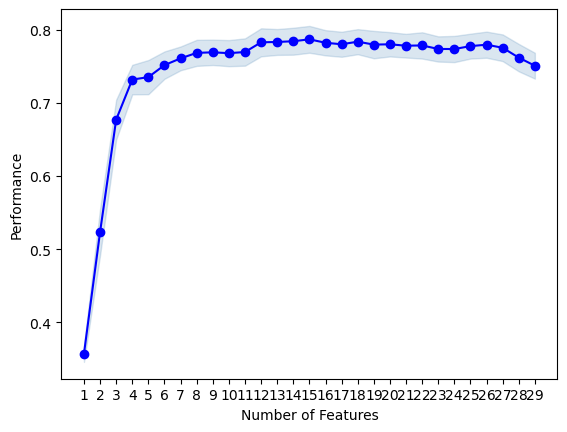

In [94]:
xgb = XGBRegressor()

# Sequential Forward Selection
sfs = SFS(xgb, 
           k_features=(5,X_train_V6.shape[1]),  
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=10,
           n_jobs=-1
         )
           
sfs = sfs.fit(X_train_V6, y_train)

selected_idx = list(sfs.k_feature_idx_)
selected_features = X_train_V6.columns[selected_idx]
all_features = set(X_train_V6.columns)
not_selected_features = all_features - set(selected_features)

print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
print('Selected feature names:\n', selected_features)
print('\nNot selected feature names:\n', not_selected_features)
print('\nall subsets:\n', sfs.subsets_)
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.show()

In [120]:
X_train_V7 = X_train.iloc[:, list(V1_sfs_kfeature_idx_)].copy()
X_test_V7 = X_test.iloc[:, list(V1_sfs_kfeature_idx_)].copy()

num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Apply simple imputer with mean strategy on numerical features
si1 = SimpleImputer(strategy='mean')
# fit (train) imputer on the training dataset
# apply imputation on both training and test datasets
X_train_V7[num_features] = si1.fit_transform(X_train_V7[num_features])
X_test_V7[num_features] = si1.transform(X_test_V7[num_features])

# Apply simple imputer with most_frequent strategy on categorical features
si2 = SimpleImputer(strategy='most_frequent')
X_train_V7[cat_features] = si2.fit_transform(X_train_V7[cat_features])
X_test_V7[cat_features] = si2.transform(X_test_V7[cat_features])

# Apply label encoding on categorical features
label_encoder =  OrdinalEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode unseen categories with -1
                                )
X_train_V7[cat_features] = label_encoder.fit_transform(X_train_V7[cat_features])
X_test_V7[cat_features] = label_encoder.transform(X_test_V7[cat_features])

scale_features = list(set(['kilometer', 'powerPS', 'carAge', 'adLifespan', 'model', 'brand']) & set(V1_sfs_kfeature_cls_))

rscaler = RobustScaler()#.fit(X_train_V7[scale_features])
# train the standardizer (find median, quantiles) and standardize the dataset
X_train_V7[scale_features] = rscaler.fit_transform(X_train_V7[scale_features])
X_test_V7[scale_features] = rscaler.transform(X_test_V7[scale_features])

X_train_V7.head()

,gearbox,powerPS,model,kilometer,brand,notRepairedDamage,carAge
0,1,0.063492,-0.500000,-0.5,-1.50,1,-0.263270
1,1,-0.142857,-0.484848,0.0,-1.25,2,0.567862
2,1,0.396825,-0.469697,0.0,-1.50,2,0.000000
3,1,0.238095,-0.454545,0.0,-1.00,2,-0.184830
4,1,-0.587302,-0.439394,-1.0,-0.75,2,-0.313259


In [122]:
X_train_V8 = X_train_V7.copy()
X_test_V8 = X_test_V7.copy()

# applying unskewing techniques
unskew_features = ['kilometer', 'carAge', 'powerPS', 'adLifespan']
pt = PowerTransformer(method='yeo-johnson')
X_train_V8[unskew_features] = pt.fit_transform(X_train_V8[unskew_features])
X_test_V8[unskew_features] = pt.transform(X_test_V8[unskew_features])

X_train_V8.head()

,gearbox,powerPS,model,kilometer,brand,notRepairedDamage,carAge
0,1,0.169811,-0.500000,-0.601867,-1.50,1,-0.155060
1,1,-0.101182,-0.484848,0.804153,-1.25,2,0.761427
2,1,0.535013,-0.469697,0.804153,-1.50,2,0.176429
3,1,0.370398,-0.454545,0.804153,-1.00,2,-0.051819
4,1,-0.817117,-0.439394,-1.116008,-0.75,2,-0.222762


#### Model Selection

Train 7 regressors using training datasets: RandomForestRegressor, AdaBoostRegressor, XGBoostRegressor, CatBoostRegressor, SVR, KNeighborsRegressor and DecisionTreeRegressor using 10-fold CV.

Make predictions using test datasets and choose the top 2 best performing models.

In [123]:
featuresets = {
    'v1': X_train_V1,
    'v2': X_train_V2, 
    'v3': X_train_V3,
    'v4': X_train_V4,
    'v5': X_train_V5,
    'v6': X_train_V6,
    'v7': X_train_V7,
    'v8': X_train_V8
}

targets = {
    'original': y_train,
    'unskewed': y_train_yj
}

# Define regressors
regressors = {
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(silent=True),
    #"SVR": SVR(),
    "KNeighbors": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
}

# Dictionary to store results
results = []

# Loop over each featureset version
for feature_name, X_data in featuresets.items():
    # loop over each target version
    for target_name, y_data in targets.items():
        # Loop over each regressor
        print(feature_name+" "+target_name+":", end=' ... ')
        for rgs_name, rgs in regressors.items():
            print(rgs_name, end=' ... ')
            # Perform 10-fold cross-validation
            scores = cross_val_score(rgs, X_data, y_data, cv=10, scoring='r2', n_jobs=-1)
            # Store the average score for this classifier and dataset version
            avg_score = scores.mean()
            results.append({
                'featureset': feature_name,
                'target': target_name,
                'regressor': rgs_name,
                'score': avg_score
            })
        print()

v1 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v1 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v2 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v2 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v3 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v3 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v4 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v4 unskewed: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... DecisionTree ... 
v5 original: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVR ... KNeighbors ... D

In [124]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

,featureset,target,regressor,score
0,v1,original,RandomForest,0.720628
1,v1,original,AdaBoost,-0.708360
2,v1,original,XGBoost,0.741860
3,v1,original,CatBoost,0.786371
4,v1,original,SVR,-0.058999
...,...,...,...,...
107,v8,unskewed,XGBoost,0.803208
108,v8,unskewed,CatBoost,0.813935
109,v8,unskewed,SVR,0.737228
110,v8,unskewed,KNeighbors,0.745805


In [125]:
# Best performing regressors: CatBoost, RandomForest, and XGBoost (almost same performance) mostly on the unskewed target variable
results_df.groupby(['regressor', 'target'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,,mean
regressor,target,
CatBoost,unskewed,0.818596
XGBoost,unskewed,0.803800
RandomForest,unskewed,0.782232
CatBoost,original,0.767552
XGBoost,original,0.741263
RandomForest,original,0.714573
DecisionTree,unskewed,0.584699
AdaBoost,unskewed,0.582700
DecisionTree,original,0.431971


In [126]:
# Best performing featuresets: v8, v7 only when the target variable is unskewed
results_df.groupby(['featureset', 'target'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,,mean
featureset,target,
v8,unskewed,0.724715
v7,unskewed,0.724520
v1,unskewed,0.632891
v6,unskewed,0.624147
v2,unskewed,0.588319
v3,unskewed,0.502424
v4,unskewed,0.500667
v5,unskewed,0.499483
v8,original,0.420955


In [ ]:
num_features = X_train_V7.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train_V7.select_dtypes(include=['object']).columns
features_to_transform = ['kilometer', 'carAge', 'powerPS', 'adLifespan']

# Preprocessing pipeline for numerical features that need only imputing (not scaling, nor unskewing)
num_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

# Preprocessing pipeline for numerical features that need imputing + unskewing
num_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('unskewer', PowerTransformer(method='yeo-johnson'))
])

# Preprocessing pipeline for categorical features (ordinal encoding)
cat_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='value'))
])

# preprocessing pipeline for creating featureset v7
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', num_pipeline1, X.iloc[:, list(V1_sfs_kfeature_idx_)].select_dtypes(include=['int64', 'float64']).columns),  # all numerical features that were selected by sfs
        ('cat', cat_pipeline1, X.iloc[:, list(V1_sfs_kfeature_idx_)].select_dtypes(include=['object']).columns)             # all categorical features that were selected by sfs
    ],
    remainder='passthrough'
)

# preprocessing pipeline for creating featureset v8
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num1', num_pipeline1, list(set(num_features) - set(features_to_transform))),  # all numerical features minus features to be unskewed
        ('num2', num_pipeline2, features_to_transform),                                 # numerical features to be unskewed
        ('cat', cat_pipeline1, cat_features)            # all categorical features
    ],
    remainder='passthrough'
)

# IMPORTANT NOTICE: avoid using multiple consecutive column transformers since they alter column order

rgs_rf = TransformedTargetRegressor(
    regressor=RandomForestRegressor(),
    transformer=PowerTransformer(method='yeo-johnson')
)

rgs_cb = TransformedTargetRegressor(
    regressor=CatBoostRegressor(verbose=0),
    transformer=PowerTransformer(method='yeo-johnson')
)       

# Create 4 pipelines with different preprocessing steps
pipeline_rf_v7 = Pipeline([
    ('preprocessor', preprocessor1),
    ('estimator', rgs_rf)
])

pipeline_cb_v7 = Pipeline([
    ('preprocessor', preprocessor1),
    ('estimator', rgs_cb)
])

pipeline_rf_v8 = Pipeline([
    ('preprocessor', preprocessor2),
    ('estimator', rgs_rf)
])

pipeline_cb_v8 = Pipeline([
    ('preprocessor', preprocessor2),
    ('estimator', rgs_cb)
])

# Define different pipelines with different regressors and preprocessing steps
pipelines = {
    'rf_v7_pipeline': pipeline_rf_v7,
    'cb_v7_pipeline': pipeline_cb_v7,
    'rf_v8_pipeline': pipeline_rf_v8,
    'cb_v8_pipeline': pipeline_cb_v8,
}

# Set up parameter grid for GridSearchCV to explore both pipelines
param_grid1 = [
    {
        'estimator__regressor__n_estimators': [100, 200, 500],         # Number of trees
        'estimator__regressor__max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
        'estimator__regressor__min_samples_split': [2, 5, 10],         # Minimum number of samples to split a node
        'estimator__regressor__min_samples_leaf': [1, 2, 4],           # Minimum samples in leaf nodes
        'estimator__regressor__max_features': ['sqrt', 'log2', None],  # Features to consider for best split
        'estimator__regressor__bootstrap': [True, False]               # Use bootstrap sampling
    }
]

param_grid2 = [
    {
        'regressor__regressor__iterations': [100, 200, 500],
        'regressor__regressor__depth': [4, 6, 10],
        'regressor__regressor__learning_rate': [0.01, 0.1],
        'regressor__regressor__l2_leaf_reg': [1, 3, 5]
    }
]

param_grids = {
    'rf_v7_pipeline': param_grid1,
    'cb_v7_pipeline': param_grid2,
    'rf_v8_pipeline': param_grid1,
    'cb_v8_pipeline': param_grid2
}

# create 2 input featesets: the first contains ony the features selected in sfs, and the second all features
X_train_all = {
    'rf_v7_pipeline': X_train_V7,
    'cb_v7_pipeline': X_train_V7,
    'rf_v8_pipeline': X_train_V8,
    'cb_v8_pipeline': X_train_V8
}

X_test_all = {
    'rf_v7_pipeline': X_test_V7,
    'cb_v7_pipeline': X_test_V7,
    'rf_v8_pipeline': X_test_V8,
    'cb_v8_pipeline': X_test_V8
}

# Loop through each pipeline and perform GridSearchCV
best_estimators = {}
for pipeline_name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {pipeline_name}...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[pipeline_name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_all[pipeline_name], y_train)
    
    # Store the best estimator and results for each pipeline
    best_estimators[pipeline_name] = grid_search.best_estimator_
    print(f"Best Parameters for {pipeline_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Score for {pipeline_name}: {grid_search.best_score_}")
    
    # Make predictions using the best estimator
    y_pred = grid_search.best_estimator_.predict(X_test_all[pipeline_name])  # Use X_test for evaluation
    print(f"Performance on the test dataset: {r2_score(y_test, y_pred)}") # Evaluate on the test dataset
    print("")

Running GridSearchCV for rf_v7_pipeline...


/home/hollow/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Μeasure the performance of the best model

In [ ]:
# Create the best model (using the best hyper-parameter values)
best_model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=20, bootstrap=True)
# train the model on the dataset that achieves the highest score
best_model.fit(X_train_V_2, y_train_yj)
# make prediction on the train dataset in order to check for overfitting 
# (overfitting arises when high performance on training dataset and low performance on test dataset => model does not generalize
y_train_pred = best_model.predict(X_train_V_2)
print("R2 score on training dataset:", r2_score(y_train_yj, y_train_pred))

# make prediction on the test dataset
y_test_pred = best_model.predict(X_test_V_2)
print("R2 score on training dataset:", r2_score(y_test_yj, y_test_pred))

# incase we do classification, use LDA